In [12]:
#@title
import copy
import math
import random
from math import exp

import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

z = []  # [3, 4] (m服务, n服务器) zik
y = []  # [3, 2, 4] (m服务, l基站，n服务器) yijk


def is_feasible(x):
    for j in range(m):
        if np.sum(x[:, j]) == 0:  #至少部署一个
            return False

    for i in range(n):
        sum = 0
        for j in range(m):
            sum += x[i][j] * s[j]
        if sum > c[i]:            #资源不超限制
            return False

    return True

def add_z(i, k, val, x):          #将z整合到变量val
    # [m, n]
    x[i * n + k] += val


def add_y(i, j, k, val, x):       #将y整合到变量val
    # [m, l, n]
    x[n * m + i * l * n + j * n + k] += val


def solve_yz(greedy=False):
    N = (l + 1) * n * m
    A_ub = []
    B_ub = []
    A_eq = []
    B_eq = []

    def eq_1():
        """
        any i,j: sum(y[i][j][k]) = 1
        :return: size=l*n
        """
        vs = []
        b = []
        for j in range(l):
            for k in range(n):
                v = [0] * N
                for i in range(m):
                    add_y(i, j, k, 1, v)
                vs += [v]
                b += [1]

        return vs, b

    def ineq_1():
        """
        any k: sum(z[i][k]) <= f[k]
        :return: size=n
        """
        vs = []
        b = []
        for k in range(n):
            v = [0] * N
            for i in range(m):
                add_z(i, k, 1, v)
            vs += [v]
            b += [f[k] * max(x[k, :])]

        return vs, b
    
    def ineq_2():
        """
        any k: z[i][k] <= x[i][k] * f[k]
        :return: size=n
        """
        vs = []
        b = []
        for k in range(n):
            for i in range(m):
                v = [0] * N
                add_z(i, k, 1, v)
                vs += [v]
                b += [x[k][i] * f[k]]

        return vs, b

    def ineq_3():
        """
        any i,j,k: -y[i][j][k]) <= 0
        :return: size=l*m*n
        """
        vs = []
        b = []
        for i in range(m):
            for k in range(n):
                for j in range(l):
                    v = [0] * N
                    add_y(i, j, k, -1, v)
                    b += [0]
                    vs += [v]

        return vs, b

    def ineq_4():
        """
        any i,j,k: y[i][j][k]) <= x[i][k]
        :return: size=l*m*n
        """
        vs = []
        b = []
        for i in range(m):
            for k in range(n):
                for j in range(l):
                    v = [0] * N
                    add_y(i, j, k, 1, v)
                    b += [x[k][i]]
                    vs += [v]

        return vs, b

    def ineq_5():
        """
        sum_j(y[i][j][k] * la[i][j]) - z[i][k] / r[i] < 0
        :return: n*m
        """
        vs = []
        b = []
        for i in range(m):
            for k in range(n):
                v = [0] * N
                for j in range(l):
                    add_y(i, j, k, la[i][j], v)
                add_z(i, k, -1.0 / r[i], v)
                vs += [v]
                b += [0]

        return vs, b

    def ineq_6():
        """
        if x[k][i] == 1:
        T[j][k] + 1 / (z[i][k] / r[i] - sum_j(y[i][j][k] * la[i][j])) <= d[i] 
        :return: l*m*n
        """
        vs = []
        b = []
        for i in range(m):
            for k in range(n):
                if x[k][i] == 1:
                    for j in range(l):
                        v = [0] * N
                        for o in range(l):
                            add_y(i, o, k, la[i][o] * (d[i] - t[j][k]), v)
                        add_z(i, k, (t[j][k] - d[i]) / r[i], v)
                        vs += [v]
                        b += [-1]

        return vs, b

    def cost():
        v = [0] * N
        for i in range(m):
            for k in range(n):
                add_z(i, k, x[k][i] * Pf[k] / f[k], v)

        return v

    eq_greedy = ineq_1

    if greedy:
        eqs = [eq_1(), eq_greedy()]
        ineqs = [ineq_2(), ineq_3(), ineq_4(), ineq_5(), ineq_6()]
    else:
        eqs = [eq_1()]
        ineqs = [ineq_1(), ineq_2(), ineq_3(), ineq_4(), ineq_5(), ineq_6()]

    for ineq in ineqs:
        A_ub += ineq[0]
        B_ub += ineq[1]

    for eq in eqs:
        A_eq += eq[0]
        B_eq += eq[1]

    res = optimize.linprog(cost(), A_ub=A_ub, b_ub=B_ub, A_eq=A_eq, b_eq=B_eq)
    # calc_duration(x, res)
    return res

def total_cost(x, g):
    z = np.reshape(g.x[:n * m], (m, n))

    cost = 0
    for k in range(n):
        for i in range(m):
            cost += x[k][i] * (Pc[k] * s[i] / c[k] + Pf[k] * z[i][k] / f[k])

    return cost


def guess_x_gibbs(epochs, omega=1e-6, greedy=False):
    global x

    cost_list = []
    best_g = None

    # init X_0
    while True:
        x = np.random.randint(2, size=(n, m))
        if is_feasible(x):
          g = solve_yz(greedy)
          if g.success:
              best_g = g
              break
          #else:
            #print("no success g!")
        #else:
          #print("no feasible x!")

    print("[INIT]\t\t: cost=%s" % (total_cost(x, g)))

    for i in range(epochs):
        choice_idx = random.randint(0, n - 1)
        old_x = copy.deepcopy(x)
        x[choice_idx, :] = np.random.randint(2, size=m)
        new_g = solve_yz(greedy)

        if new_g.success and is_feasible(x):
            old_cost = total_cost(old_x, g)
            new_cost = total_cost(x, new_g)
            delta = new_cost - old_cost
            trans_prob = 1.0 / (1.0 + np.exp(1.0 * delta / omega))

            if random.random() <= trans_prob:
                print("[%3d][CHANGE]\t: new_cost=%s, old_cost=%s, prob=%s -- %s" % (i, new_cost, old_cost, trans_prob, new_cost))
                g = new_g
                best_g = g
            else:
                print("[%3d][KEEP]\t\t: new_cost=%s, old_cost=%s, prob=%s -- %s" % (i, new_cost, old_cost, trans_prob, old_cost))
                x = old_x
        else:
            print("[%3d][SKIP]\t\t: %s" % (i, new_g.success))
            x = old_x

        cost_list.append(total_cost(x, g))

    return cost_list #, resource_usage_rate(best_g)


def guess_x_random(nums, greedy=False):
    global x

    best_g = None 
    
    # init X_0
    while True:
        x = np.random.randint(2, size=(n, m))
        if is_feasible(x):
          g = solve_yz(greedy)
          if g.success:
              best_g = g
              break
          else:
            print("no success g!")
        else:
          print("not feasible x!")

    print("INIT x = %s" % x)
    min_cost = total_cost(x, g)
    cost_list = []

    for i in range(nums):
        x = np.random.randint(2, size=(n, m))
        g = solve_yz(greedy)
        if g.success and is_feasible(x):
            cur_cost = total_cost(x, g)
            if cur_cost < min_cost:
                min_cost = cur_cost
                best_g = g

        cost_list.append(min_cost)
        print("[%3d]: %s --- %s" % (i, g.fun, min_cost))

    return cost_list #, resource_usage_rate(best_g)

def resource_usage_rate(g):
    z = np.reshape(g.x[:n * m], (m, n))
    
    usages = []
    for j in range(n): 
        sum = 0
        for i in range(m):
            sum += z[i][j]
        usages.append(sum / f[j])
    
    return usages
    
# result_gibbs = guess_x_gibbs(300, 1e-3, greedy=True)
# guess_x_random(1000, True)


In [3]:
n = 10 #server 5,4,1
m = 8 #service
s = np.array([10, 5, 5, 15, 10, 15, 20, 25])
c = np.array([50, 70, 60, 65, 55, 130, 100, 160, 140, 200])
Pc = np.array([25, 30, 30, 32, 22, 33, 29, 38, 35, 40])
f = np.array([50, 55, 80, 53, 60, 75, 125, 130, 100, 150])
Pf = np.array([24, 22, 28, 25, 30, 39, 40, 50, 34, 48])
d = np.array([0.045, 0.02, 0.035, 0.04, 0.03, 0.045, 0.038, 0.04])
r = np.array([0.1, 0.2, 0.1, 0.3, 0.15, 0.2, 0.25, 0.14])
l = 5 #base station
t = np.array([[0.005,0.006,0.001,0.004,0.005, 0.011,0.013,0.010,0.012, 0.015],
        [0.001,0.002,0.005,0.005,0.004, 0.010,0.010,0.014,0.013, 0.015],
        [0.003,0.004,0.006,0.001,0.002, 0.013,0.010,0.011,0.013, 0.015],
        [0.006,0.001,0.003,0.004,0.005, 0.011,0.014,0.012,0.010, 0.015],
        [0.002,0.003,0.004,0.005,0.001, 0.012,0.013,0.010,0.010, 0.015]]) #l * n
la = np.array([[50,59,70,69,57],[69,50,50,60,57],[69,50,56,61,70],[70,59,63,54,60],[56,62,57,60,50],[50,57,60,51,70],[61,50,52,70,55],[50,69,56,70,61]]) # m * l

total_iters = 5000
result_gibbs_greedy = guess_x_gibbs(total_iters, 1e-6, greedy=True)
#result_gibbs_ondemand  = guess_x_gibbs(total_iters, 1e-6, greedy=False)
result_random_ondemand = guess_x_random(total_iters, greedy=False)

[INIT]		: cost=486.68021972710557
[  0][KEEP]		: new_cost=494.6802153971952, old_cost=486.68021972710557, prob=0.0 -- 486.68021972710557


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:241: RuntimeWarning: overflow encountered in exp


[  1][KEEP]		: new_cost=486.6802197030463, old_cost=486.68021972710557, prob=0.5060145251905993 -- 486.68021972710557
[  2][CHANGE]	: new_cost=470.73019958144124, old_cost=486.68021972710557, prob=1.0 -- 470.73019958144124
[  3][SKIP]		: False
[  4][KEEP]		: new_cost=493.9302142231922, old_cost=470.73019958144124, prob=0.0 -- 470.73019958144124
[  5][KEEP]		: new_cost=486.68021974434004, old_cost=470.73019958144124, prob=0.0 -- 470.73019958144124
[  6][KEEP]		: new_cost=487.87307685504965, old_cost=470.73019958144124, prob=0.0 -- 470.73019958144124
[  7][KEEP]		: new_cost=474.73021274331956, old_cost=470.73019958144124, prob=0.0 -- 470.73019958144124
[  8][SKIP]		: True
[  9][CHANGE]	: new_cost=460.7302197099292, old_cost=470.73019958144124, prob=1.0 -- 460.7302197099292
[ 10][SKIP]		: False
[ 11][CHANGE]	: new_cost=456.98021970745083, old_cost=460.7302197099292, prob=1.0 -- 456.98021970745083
[ 12][SKIP]		: False
[ 13][KEEP]		: new_cost=458.9802099241185, old_cost=456.98021970745083, 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting

[ 17][KEEP]		: new_cost=459.5186813071531, old_cost=456.98021970745083, prob=0.0 -- 456.98021970745083
[ 18][KEEP]		: new_cost=467.1340659286158, old_cost=456.98021970745083, prob=0.0 -- 456.98021970745083
[ 19][KEEP]		: new_cost=458.9801902663363, old_cost=456.98021970745083, prob=0.0 -- 456.98021970745083
[ 20][SKIP]		: True
[ 21][KEEP]		: new_cost=459.3552196849032, old_cost=456.98021970745083, prob=0.0 -- 456.98021970745083
[ 22][SKIP]		: False
[ 23][KEEP]		: new_cost=460.73021970673204, old_cost=456.98021970745083, prob=0.0 -- 456.98021970745083
[ 24][SKIP]		: True
[ 25][CHANGE]	: new_cost=451.98021969251744, old_cost=456.98021970745083, prob=1.0 -- 451.98021969251744
[ 26][SKIP]		: False
[ 27][KEEP]		: new_cost=461.9802197222413, old_cost=451.98021969251744, prob=0.0 -- 451.98021969251744
[ 28][KEEP]		: new_cost=456.3302197033417, old_cost=451.98021969251744, prob=0.0 -- 451.98021969251744
[ 29][SKIP]		: False
[ 30][KEEP]		: new_cost=459.4802196820117, old_cost=451.98021969251744

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.23222e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[ 67][KEEP]		: new_cost=445.21675823851837, old_cost=442.31675823889464, prob=0.0 -- 442.31675823889464
[ 68][KEEP]		: new_cost=449.5667582389003, old_cost=442.31675823889464, prob=0.0 -- 442.31675823889464
[ 69][CHANGE]	: new_cost=439.8167582391139, old_cost=442.31675823889464, prob=1.0 -- 439.8167582391139
[ 70][KEEP]		: new_cost=454.3167582365077, old_cost=439.8167582391139, prob=0.0 -- 439.8167582391139
[ 71][KEEP]		: new_cost=455.76675823610105, old_cost=439.8167582391139, prob=0.0 -- 439.8167582391139
[ 72][KEEP]		: new_cost=443.56675823974456, old_cost=439.8167582391139, prob=0.0 -- 439.8167582391139
[ 73][KEEP]		: new_cost=445.61675823665036, old_cost=439.8167582391139, prob=0.0 -- 439.8167582391139
[ 74][SKIP]		: False
[ 75][KEEP]		: new_cost=455.7667582378617, old_cost=439.8167582391139, prob=0.0 -- 439.8167582391139
[ 76][KEEP]		: new_cost=464.4667574942571, old_cost=439.8167582391139, prob=0.0 -- 439.8167582391139
[ 77][CHANGE]	: new_cost=439.81675823931727, old_cost=439.81

[303][SKIP]		: False
[304][KEEP]		: new_cost=418.25219779304433, old_cost=408.2521977415511, prob=0.0 -- 408.2521977415511
[305][KEEP]		: new_cost=408.2521977415511, old_cost=408.2521977415511, prob=0.5 -- 408.2521977415511
[306][SKIP]		: False
[307][SKIP]		: False
[308][SKIP]		: False
[309][KEEP]		: new_cost=419.2521745807727, old_cost=408.2521977415511, prob=0.0 -- 408.2521977415511
[310][SKIP]		: False
[311][SKIP]		: False
[312][KEEP]		: new_cost=420.12719774225144, old_cost=408.2521977415511, prob=0.0 -- 408.2521977415511
[313][SKIP]		: False
[314][SKIP]		: False
[315][KEEP]		: new_cost=416.25216273487774, old_cost=408.2521977415511, prob=0.0 -- 408.2521977415511
[316][SKIP]		: False
[317][SKIP]		: True
[318][SKIP]		: False
[319][KEEP]		: new_cost=418.40219774571, old_cost=408.2521977415511, prob=0.0 -- 408.2521977415511
[320][SKIP]		: False
[321][KEEP]		: new_cost=420.12719774504444, old_cost=408.2521977415511, prob=0.0 -- 408.2521977415511
[322][SKIP]		: False
[323][SKIP]		: Fals

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.


[428][SKIP]		: False
[429][KEEP]		: new_cost=431.8521547676973, old_cost=405.75219250572724, prob=0.0 -- 405.75219250572724
[430][SKIP]		: False
[431][KEEP]		: new_cost=419.7521740360403, old_cost=405.75219250572724, prob=0.0 -- 405.75219250572724
[432][KEEP]		: new_cost=413.7521903152146, old_cost=405.75219250572724, prob=0.0 -- 405.75219250572724
[433][SKIP]		: False
[434][SKIP]		: True
[435][SKIP]		: False
[436][KEEP]		: new_cost=417.35219087426003, old_cost=405.75219250572724, prob=0.0 -- 405.75219250572724
[437][CHANGE]	: new_cost=405.7521923349764, old_cost=405.75219250572724, prob=0.5425842874522009 -- 405.7521923349764
[438][KEEP]		: new_cost=423.2521897192247, old_cost=405.7521923349764, prob=0.0 -- 405.7521923349764
[439][CHANGE]	: new_cost=403.252188978836, old_cost=405.7521923349764, prob=1.0 -- 403.252188978836
[440][SKIP]		: True
[441][KEEP]		: new_cost=412.7521977893519, old_cost=403.252188978836, prob=0.0 -- 403.252188978836
[442][SKIP]		: True
[443][SKIP]		: True
[444]

[572][SKIP]		: False
[573][SKIP]		: False
[574][SKIP]		: True
[575][SKIP]		: True
[576][SKIP]		: False
[577][SKIP]		: False
[578][SKIP]		: False
[579][SKIP]		: False
[580][SKIP]		: False
[581][SKIP]		: True
[582][KEEP]		: new_cost=428.25219778897025, old_cost=403.252188978836, prob=0.0 -- 403.252188978836
[583][SKIP]		: True
[584][KEEP]		: new_cost=416.1093401442966, old_cost=403.252188978836, prob=0.0 -- 403.252188978836
[585][KEEP]		: new_cost=413.2521976146684, old_cost=403.252188978836, prob=0.0 -- 403.252188978836
[586][SKIP]		: True
[587][SKIP]		: False
[588][KEEP]		: new_cost=413.2521892657572, old_cost=403.252188978836, prob=0.0 -- 403.252188978836
[589][SKIP]		: False
[590][KEEP]		: new_cost=422.25216170126737, old_cost=403.252188978836, prob=0.0 -- 403.252188978836
[591][SKIP]		: True
[592][KEEP]		: new_cost=416.2521977957567, old_cost=403.252188978836, prob=0.0 -- 403.252188978836
[593][SKIP]		: False
[594][SKIP]		: False
[595][SKIP]		: False
[596][SKIP]		: True
[597][KEEP]	

[703][KEEP]		: new_cost=415.25219345373756, old_cost=400.7521977992513, prob=0.0 -- 400.7521977992513
[704][SKIP]		: True
[705][SKIP]		: True
[706][KEEP]		: new_cost=404.75219779465556, old_cost=400.7521977992513, prob=0.0 -- 400.7521977992513
[707][KEEP]		: new_cost=411.75219778994324, old_cost=400.7521977992513, prob=0.0 -- 400.7521977992513
[708][KEEP]		: new_cost=404.55989006168016, old_cost=400.7521977992513, prob=0.0 -- 400.7521977992513
[709][SKIP]		: True
[710][KEEP]		: new_cost=410.7521977944504, old_cost=400.7521977992513, prob=0.0 -- 400.7521977992513
[711][SKIP]		: False
[712][SKIP]		: False
[713][SKIP]		: False
[714][KEEP]		: new_cost=420.7521972443098, old_cost=400.7521977992513, prob=0.0 -- 400.7521977992513
[715][KEEP]		: new_cost=414.7521977909734, old_cost=400.7521977992513, prob=0.0 -- 400.7521977992513
[716][SKIP]		: True
[717][SKIP]		: True
[718][SKIP]		: True
[719][KEEP]		: new_cost=403.6521940448817, old_cost=400.7521977992513, prob=0.0 -- 400.7521977992513
[720]

[842][SKIP]		: True
[843][KEEP]		: new_cost=411.2906560255516, old_cost=396.290659330397, prob=0.0 -- 396.290659330397
[844][SKIP]		: False
[845][SKIP]		: False
[846][SKIP]		: True
[847][KEEP]		: new_cost=408.2906562563738, old_cost=396.290659330397, prob=0.0 -- 396.290659330397
[848][SKIP]		: False
[849][SKIP]		: False
[850][KEEP]		: new_cost=416.2906593280682, old_cost=396.290659330397, prob=0.0 -- 396.290659330397
[851][KEEP]		: new_cost=410.2906593344377, old_cost=396.290659330397, prob=0.0 -- 396.290659330397
[852][KEEP]		: new_cost=403.79065933488783, old_cost=396.290659330397, prob=0.0 -- 396.290659330397
[853][SKIP]		: False
[854][SKIP]		: False
[855][KEEP]		: new_cost=405.7906590959511, old_cost=396.290659330397, prob=0.0 -- 396.290659330397
[856][KEEP]		: new_cost=406.44065933768866, old_cost=396.290659330397, prob=0.0 -- 396.290659330397
[857][KEEP]		: new_cost=415.1406395801278, old_cost=396.290659330397, prob=0.0 -- 396.290659330397
[858][CHANGE]	: new_cost=392.00490965545

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.13289e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[902][KEEP]		: new_cost=394.543406506144, old_cost=392.00490965545373, prob=0.0 -- 392.00490965545373
[903][SKIP]		: True
[904][KEEP]		: new_cost=402.6924448676588, old_cost=392.00490965545373, prob=0.0 -- 392.00490965545373
[905][KEEP]		: new_cost=398.35109890581043, old_cost=392.00490965545373, prob=0.0 -- 392.00490965545373
[906][KEEP]		: new_cost=407.00494480707624, old_cost=392.00490965545373, prob=0.0 -- 392.00490965545373
[907][KEEP]		: new_cost=400.70493595361927, old_cost=392.00490965545373, prob=0.0 -- 392.00490965545373
[908][KEEP]		: new_cost=405.0549423348755, old_cost=392.00490965545373, prob=0.0 -- 392.00490965545373
[909][SKIP]		: False
[910][SKIP]		: False
[911][SKIP]		: True
[912][SKIP]		: True
[913][KEEP]		: new_cost=393.25491058273883, old_cost=392.00490965545373, prob=0.0 -- 392.00490965545373
[914][SKIP]		: False
[915][KEEP]		: new_cost=402.15494498896754, old_cost=392.00490965545373, prob=0.0 -- 392.00490965545373
[916][SKIP]		: True
[917][KEEP]		: new_cost=407.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=7.19585e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[946][SKIP]		: True
[947][KEEP]		: new_cost=408.2549416438149, old_cost=392.00490965545373, prob=0.0 -- 392.00490965545373
[948][SKIP]		: False
[949][SKIP]		: False
[950][KEEP]		: new_cost=402.0049195275815, old_cost=392.00490965545373, prob=0.0 -- 392.00490965545373
[951][SKIP]		: True
[952][SKIP]		: True
[953][SKIP]		: True
[954][SKIP]		: True
[955][KEEP]		: new_cost=403.25494504459357, old_cost=392.00490965545373, prob=0.0 -- 392.00490965545373
[956][SKIP]		: False
[957][KEEP]		: new_cost=397.00490835868624, old_cost=392.00490965545373, prob=0.0 -- 392.00490965545373
[958][SKIP]		: False
[959][SKIP]		: False
[960][SKIP]		: False
[961][KEEP]		: new_cost=400.004914101402, old_cost=392.00490965545373, prob=0.0 -- 392.00490965545373
[962][SKIP]		: True
[963][KEEP]		: new_cost=407.9549331888391, old_cost=392.00490965545373, prob=0.0 -- 392.00490965545373
[964][SKIP]		: True
[965][KEEP]		: new_cost=397.80493349530303, old_cost=392.00490965545373, prob=0.0 -- 392.00490965545373
[966][SKIP]

[1091][KEEP]		: new_cost=394.25494501552134, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1092][KEEP]		: new_cost=398.204934264602, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1093][KEEP]		: new_cost=408.35493731358076, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1094][KEEP]		: new_cost=395.30493612645984, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1095][KEEP]		: new_cost=398.20493578901085, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1096][SKIP]		: False
[1097][KEEP]		: new_cost=405.4549341728467, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1098][KEEP]		: new_cost=409.50491084024304, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1099][SKIP]		: True
[1100][SKIP]		: False
[1101][SKIP]		: False
[1102][SKIP]		: True
[1103][SKIP]		: True
[1104][SKIP]		: True
[1105][SKIP]		: True
[1106][KEEP]		: new_cost=403.5049382228797, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1107][KE

[1220][SKIP]		: True
[1221][KEEP]		: new_cost=401.1049340573655, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1222][KEEP]		: new_cost=400.7549450525055, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1223][SKIP]		: True
[1224][KEEP]		: new_cost=390.50494504487267, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1225][SKIP]		: False
[1226][SKIP]		: True
[1227][KEEP]		: new_cost=404.0049352198003, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1228][KEEP]		: new_cost=404.504942879659, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1229][KEEP]		: new_cost=396.5049171753853, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1230][SKIP]		: True
[1231][SKIP]		: False
[1232][SKIP]		: False
[1233][SKIP]		: False
[1234][KEEP]		: new_cost=396.5049177704543, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1235][SKIP]		: True
[1236][SKIP]		: True
[1237][KEEP]		: new_cost=403.25493831170814, old_cost=389.5048978685298,

[1364][SKIP]		: True
[1365][SKIP]		: False
[1366][KEEP]		: new_cost=402.0049069154552, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1367][SKIP]		: False
[1368][KEEP]		: new_cost=401.10493349815255, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1369][SKIP]		: True
[1370][KEEP]		: new_cost=392.4049370699255, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1371][KEEP]		: new_cost=390.754895192439, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1372][KEEP]		: new_cost=408.35490140669094, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1373][KEEP]		: new_cost=411.25494504798337, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1374][SKIP]		: False
[1375][KEEP]		: new_cost=409.50489972551713, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1376][SKIP]		: False
[1377][SKIP]		: True
[1378][KEEP]		: new_cost=404.504938663451, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1379][SKIP]		: True
[1380][SKI

[1651][KEEP]		: new_cost=403.5049407643554, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1652][SKIP]		: True
[1653][SKIP]		: True
[1654][SKIP]		: True
[1655][SKIP]		: False
[1656][KEEP]		: new_cost=401.5049357927483, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1657][SKIP]		: False
[1658][SKIP]		: True
[1659][SKIP]		: True
[1660][KEEP]		: new_cost=394.5048935451879, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1661][SKIP]		: False
[1662][SKIP]		: True
[1663][KEEP]		: new_cost=396.50490378389867, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1664][KEEP]		: new_cost=389.50494357712535, old_cost=389.5048978685298, prob=1.4093185579900666e-20 -- 389.5048978685298
[1665][SKIP]		: False
[1666][SKIP]		: False
[1667][SKIP]		: True
[1668][KEEP]		: new_cost=400.75494485236544, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1669][SKIP]		: True
[1670][KEEP]		: new_cost=402.0049450293761, old_cost=389.5048978685298, prob=0.0 -- 389.

[1783][SKIP]		: False
[1784][KEEP]		: new_cost=401.1049311909476, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1785][KEEP]		: new_cost=405.454902762561, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1786][KEEP]		: new_cost=409.50494144067176, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1787][KEEP]		: new_cost=398.20493578901085, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1788][KEEP]		: new_cost=400.7549450525055, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1789][KEEP]		: new_cost=397.50490209738547, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1790][SKIP]		: True
[1791][SKIP]		: False
[1792][SKIP]		: False
[1793][SKIP]		: True
[1794][SKIP]		: False
[1795][SKIP]		: False
[1796][KEEP]		: new_cost=399.0049450762174, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1797][SKIP]		: False
[1798][SKIP]		: True
[1799][SKIP]		: True
[1800][KEEP]		: new_cost=395.8510988937187, old_cost=389.50489786852

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=1.39229e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[1903][SKIP]		: True
[1904][KEEP]		: new_cost=397.00489713420177, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1905][SKIP]		: True
[1906][KEEP]		: new_cost=401.10490914769696, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1907][SKIP]		: True
[1908][SKIP]		: True
[1909][KEEP]		: new_cost=399.6549450416625, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1910][SKIP]		: False
[1911][SKIP]		: True
[1912][SKIP]		: False
[1913][KEEP]		: new_cost=398.50490646788415, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1914][KEEP]		: new_cost=412.7049187859352, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1915][SKIP]		: True
[1916][SKIP]		: True
[1917][SKIP]		: False
[1918][KEEP]		: new_cost=399.5049450358725, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1919][KEEP]		: new_cost=402.5049450552249, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[1920][KEEP]		: new_cost=397.50489464871185, old_cost=389.504897868529

[2043][KEEP]		: new_cost=396.7549343560932, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2044][SKIP]		: True
[2045][KEEP]		: new_cost=397.8174448783308, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2046][SKIP]		: False
[2047][SKIP]		: False
[2048][SKIP]		: True
[2049][KEEP]		: new_cost=391.96646120330126, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2050][KEEP]		: new_cost=397.50489630091994, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2051][SKIP]		: True
[2052][SKIP]		: True
[2053][SKIP]		: True
[2054][SKIP]		: True
[2055][SKIP]		: False
[2056][SKIP]		: True
[2057][SKIP]		: True
[2058][SKIP]		: False
[2059][SKIP]		: False
[2060][KEEP]		: new_cost=405.5049449911378, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2061][KEEP]		: new_cost=414.5049450527951, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2062][SKIP]		: False
[2063][KEEP]		: new_cost=392.00490965545373, old_cost=389.5048978685298, prob=0.0 -- 3

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=4.72138e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


[2067][KEEP]		: new_cost=398.25491907371185, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2068][SKIP]		: False
[2069][KEEP]		: new_cost=395.4424450571915, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2070][KEEP]		: new_cost=412.0049059538648, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2071][KEEP]		: new_cost=399.504940766406, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2072][KEEP]		: new_cost=405.7549450064329, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2073][SKIP]		: True
[2074][SKIP]		: False
[2075][KEEP]		: new_cost=389.50494357712535, old_cost=389.5048978685298, prob=1.4093185579900666e-20 -- 389.5048978685298
[2076][KEEP]		: new_cost=407.5049449224504, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2077][KEEP]		: new_cost=414.50494504562664, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2078][SKIP]		: False
[2079][SKIP]		: False
[2080][KEEP]		: new_cost=407.50494505079155, old_cost=

[2211][SKIP]		: True
[2212][KEEP]		: new_cost=408.3549358652472, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2213][SKIP]		: True
[2214][KEEP]		: new_cost=406.64777455690364, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2215][KEEP]		: new_cost=409.80494504552905, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2216][SKIP]		: True
[2217][KEEP]		: new_cost=390.75490223680254, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2218][SKIP]		: False
[2219][SKIP]		: False
[2220][KEEP]		: new_cost=406.5049450484305, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2221][KEEP]		: new_cost=395.7549139918457, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2222][KEEP]		: new_cost=401.10493417984856, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2223][SKIP]		: True
[2224][SKIP]		: True
[2225][KEEP]		: new_cost=402.55493374970223, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2226][KEEP]		: new_cost=409.5

[2355][SKIP]		: False
[2356][SKIP]		: False
[2357][KEEP]		: new_cost=413.0763730583629, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2358][SKIP]		: False
[2359][SKIP]		: False
[2360][KEEP]		: new_cost=412.0049450343874, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2361][SKIP]		: False
[2362][KEEP]		: new_cost=405.4549177949027, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2363][SKIP]		: False
[2364][SKIP]		: True
[2365][CHANGE]	: new_cost=389.5048978685298, old_cost=389.5048978685298, prob=0.5 -- 389.5048978685298
[2366][KEEP]		: new_cost=409.80491594669707, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2367][KEEP]		: new_cost=394.5049033541292, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2368][KEEP]		: new_cost=412.004945042203, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2369][KEEP]		: new_cost=402.36208698134146, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2370][SKIP]		: True
[2371][S

[2490][KEEP]		: new_cost=407.0049430549474, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2491][SKIP]		: False
[2492][KEEP]		: new_cost=404.0049342782706, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2493][SKIP]		: False
[2494][KEEP]		: new_cost=404.50494427000564, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2495][SKIP]		: True
[2496][KEEP]		: new_cost=397.0049448617131, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2497][KEEP]		: new_cost=399.6549341883807, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2498][KEEP]		: new_cost=407.00494395409055, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2499][KEEP]		: new_cost=401.5049420642833, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2500][SKIP]		: False
[2501][SKIP]		: True
[2502][KEEP]		: new_cost=395.3049365384835, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2503][KEEP]		: new_cost=414.1549440349619, old_cost=389.5048978685298, pr

[2627][SKIP]		: False
[2628][SKIP]		: True
[2629][SKIP]		: False
[2630][KEEP]		: new_cost=399.5049450358725, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2631][SKIP]		: True
[2632][KEEP]		: new_cost=397.1203039398371, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2633][KEEP]		: new_cost=392.0049434223987, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2634][SKIP]		: True
[2635][SKIP]		: False
[2636][KEEP]		: new_cost=405.75494126780933, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2637][SKIP]		: False
[2638][SKIP]		: True
[2639][KEEP]		: new_cost=400.7549441096238, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2640][SKIP]		: True
[2641][SKIP]		: True
[2642][KEEP]		: new_cost=399.5049450437268, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2643][SKIP]		: True
[2644][SKIP]		: False
[2645][KEEP]		: new_cost=405.45493464828894, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2646][KEEP]		: new_cost=40

[2779][SKIP]		: True
[2780][SKIP]		: True
[2781][KEEP]		: new_cost=404.5049393755318, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2782][KEEP]		: new_cost=409.50493374834303, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2783][KEEP]		: new_cost=398.2049366628148, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2784][KEEP]		: new_cost=397.81739046545067, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2785][KEEP]		: new_cost=405.50494509706726, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2786][KEEP]		: new_cost=403.754944443391, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2787][KEEP]		: new_cost=393.85491980256273, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2788][KEEP]		: new_cost=401.50490758281774, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2789][SKIP]		: False
[2790][SKIP]		: True
[2791][KEEP]		: new_cost=412.0049450343874, old_cost=389.5048978685298, prob=0.0 -- 389.5048978

[2906][SKIP]		: False
[2907][KEEP]		: new_cost=407.50494480007825, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2908][SKIP]		: False
[2909][SKIP]		: False
[2910][KEEP]		: new_cost=408.3549007341977, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2911][KEEP]		: new_cost=391.5048916698406, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2912][SKIP]		: True
[2913][SKIP]		: True
[2914][SKIP]		: True
[2915][KEEP]		: new_cost=397.5049130991765, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2916][SKIP]		: True
[2917][SKIP]		: False
[2918][KEEP]		: new_cost=407.5049449224504, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2919][SKIP]		: False
[2920][KEEP]		: new_cost=406.0049394462501, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2921][SKIP]		: True
[2922][SKIP]		: False
[2923][SKIP]		: False
[2924][KEEP]		: new_cost=394.50489934998575, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[2925][SKIP]		: False
[29

[3051][SKIP]		: False
[3052][KEEP]		: new_cost=393.0674016309287, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3053][SKIP]		: False
[3054][KEEP]		: new_cost=405.5049033726745, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3055][SKIP]		: True
[3056][KEEP]		: new_cost=396.5049080172885, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3057][KEEP]		: new_cost=395.30493372403686, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3058][SKIP]		: True
[3059][SKIP]		: False
[3060][KEEP]		: new_cost=402.1972513009206, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3061][KEEP]		: new_cost=404.5049406493742, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3062][KEEP]		: new_cost=395.30493571776844, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3063][SKIP]		: True
[3064][KEEP]		: new_cost=399.00494484597505, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3065][SKIP]		: False
[3066][KEEP]		: new_cost=399.5

[3184][SKIP]		: False
[3185][SKIP]		: True
[3186][SKIP]		: True
[3187][KEEP]		: new_cost=399.50494503666266, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3188][SKIP]		: False
[3189][SKIP]		: True
[3190][KEEP]		: new_cost=401.1049347762929, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3191][KEEP]		: new_cost=398.5049187036513, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3192][SKIP]		: True
[3193][SKIP]		: True
[3194][KEEP]		: new_cost=396.50491336148974, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3195][SKIP]		: False
[3196][SKIP]		: True
[3197][SKIP]		: True
[3198][KEEP]		: new_cost=404.5049414959386, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3199][SKIP]		: False
[3200][SKIP]		: True
[3201][SKIP]		: True
[3202][KEEP]		: new_cost=397.50489464871185, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3203][KEEP]		: new_cost=400.5049236594544, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3204]

[3332][KEEP]		: new_cost=407.3174412930057, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3333][SKIP]		: False
[3334][KEEP]		: new_cost=401.5049420642833, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3335][SKIP]		: True
[3336][KEEP]		: new_cost=403.25494504014137, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3337][KEEP]		: new_cost=403.50494495178015, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3338][SKIP]		: False
[3339][SKIP]		: True
[3340][SKIP]		: True
[3341][KEEP]		: new_cost=393.5048967491614, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3342][KEEP]		: new_cost=412.00494455720263, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3343][KEEP]		: new_cost=397.0049016339577, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3344][SKIP]		: False
[3345][KEEP]		: new_cost=402.0049417856699, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3346][SKIP]		: False
[3347][KEEP]		: new_cost=393.0

[3465][SKIP]		: False
[3466][KEEP]		: new_cost=398.20493492535604, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3467][SKIP]		: True
[3468][SKIP]		: False
[3469][KEEP]		: new_cost=405.50494509706726, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3470][SKIP]		: False
[3471][KEEP]		: new_cost=409.50494465793975, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3472][SKIP]		: True
[3473][KEEP]		: new_cost=391.5049093726834, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3474][KEEP]		: new_cost=400.5049449894237, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3475][KEEP]		: new_cost=409.80494503771155, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3476][SKIP]		: False
[3477][SKIP]		: True
[3478][SKIP]		: True
[3479][KEEP]		: new_cost=398.076312167371, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3480][KEEP]		: new_cost=404.5049450300366, old_cost=389.5048978685298, prob=0.0 -- 389.5048978685298
[3481][SK

[3609][KEEP]		: new_cost=395.3174429551886, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3610][SKIP]		: True
[3611][SKIP]		: True
[3612][SKIP]		: False
[3613][SKIP]		: True
[3614][SKIP]		: True
[3615][SKIP]		: False
[3616][SKIP]		: True
[3617][KEEP]		: new_cost=397.6924205588835, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3618][KEEP]		: new_cost=395.8895592831876, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3619][KEEP]		: new_cost=400.05494433060437, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3620][KEEP]		: new_cost=395.0049434279565, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3621][SKIP]		: False
[3622][KEEP]		: new_cost=395.70494403995065, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3623][SKIP]		: False
[3624][SKIP]		: True
[3625][KEEP]		: new_cost=407.3049413978633, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3626][KEEP]		: new_cost=397.0049379748077, old_cost=387.0049435458591

[3758][SKIP]		: True
[3759][KEEP]		: new_cost=402.00490763699196, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3760][KEEP]		: new_cost=409.5049442171387, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3761][SKIP]		: False
[3762][KEEP]		: new_cost=409.5049387235952, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3763][SKIP]		: True
[3764][SKIP]		: False
[3765][KEEP]		: new_cost=401.50494242243764, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3766][KEEP]		: new_cost=408.75491894867326, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3767][SKIP]		: False
[3768][SKIP]		: True
[3769][SKIP]		: False
[3770][KEEP]		: new_cost=390.75494350266393, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3771][SKIP]		: False
[3772][SKIP]		: True
[3773][SKIP]		: False
[3774][SKIP]		: False
[3775][SKIP]		: True
[3776][SKIP]		: False
[3777][SKIP]		: True
[3778][KEEP]		: new_cost=399.69722236709765, old_cost=387.0049435458591, prob=0.0 

[3900][SKIP]		: True
[3901][KEEP]		: new_cost=401.0049449620331, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3902][SKIP]		: False
[3903][KEEP]		: new_cost=401.5049442916676, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3904][SKIP]		: False
[3905][KEEP]		: new_cost=399.00494346933823, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3906][SKIP]		: False
[3907][SKIP]		: False
[3908][KEEP]		: new_cost=412.0049362916469, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3909][SKIP]		: False
[3910][KEEP]		: new_cost=405.7549449511023, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3911][SKIP]		: False
[3912][SKIP]		: True
[3913][KEEP]		: new_cost=398.2549292570517, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3914][SKIP]		: True
[3915][SKIP]		: True
[3916][KEEP]		: new_cost=404.5049450541337, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[3917][KEEP]		: new_cost=394.25494408386203, old_cost=387.00494354585

[4048][SKIP]		: False
[4049][SKIP]		: True
[4050][SKIP]		: True
[4051][SKIP]		: True
[4052][KEEP]		: new_cost=394.25494399951276, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4053][SKIP]		: True
[4054][KEEP]		: new_cost=402.00494066410846, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4055][SKIP]		: False
[4056][KEEP]		: new_cost=407.3049313570084, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4057][SKIP]		: True
[4058][SKIP]		: True
[4059][SKIP]		: False
[4060][SKIP]		: False
[4061][SKIP]		: False
[4062][SKIP]		: False
[4063][KEEP]		: new_cost=391.3549440548535, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4064][SKIP]		: False
[4065][SKIP]		: False
[4066][SKIP]		: True
[4067][KEEP]		: new_cost=395.3174320069372, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4068][SKIP]		: True
[4069][KEEP]		: new_cost=400.754943945664, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4070][SKIP]		: True
[4071][SKIP]		: True
[

[4200][KEEP]		: new_cost=402.0049430546442, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4201][SKIP]		: True
[4202][KEEP]		: new_cost=401.50494409141913, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4203][KEEP]		: new_cost=397.0049419865639, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4204][SKIP]		: True
[4205][KEEP]		: new_cost=389.0049437756243, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4206][KEEP]		: new_cost=403.2549417695343, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4207][SKIP]		: True
[4208][KEEP]		: new_cost=402.0049404723822, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4209][KEEP]		: new_cost=395.88955667735877, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4210][SKIP]		: False
[4211][SKIP]		: True
[4212][KEEP]		: new_cost=397.69244504703715, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4213][KEEP]		: new_cost=398.0049443846358, old_cost=387.0049435458591, pro

[4338][KEEP]		: new_cost=395.70494392273145, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4339][SKIP]		: True
[4340][SKIP]		: False
[4341][SKIP]		: True
[4342][KEEP]		: new_cost=406.29065240408994, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4343][SKIP]		: True
[4344][KEEP]		: new_cost=398.6049440822493, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4345][SKIP]		: True
[4346][KEEP]		: new_cost=398.6049436112358, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4347][SKIP]		: False
[4348][SKIP]		: False
[4349][SKIP]		: False
[4350][SKIP]		: False
[4351][KEEP]		: new_cost=397.6924238532108, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4352][KEEP]		: new_cost=399.5049099655243, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4353][SKIP]		: False
[4354][KEEP]		: new_cost=400.7549208217222, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4355][KEEP]		: new_cost=398.42802197061513, old_cost=387.0049435458

[4494][KEEP]		: new_cost=396.0049434973827, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4495][SKIP]		: False
[4496][SKIP]		: False
[4497][SKIP]		: True
[4498][SKIP]		: False
[4499][SKIP]		: False
[4500][SKIP]		: False
[4501][KEEP]		: new_cost=398.25494229252774, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4502][KEEP]		: new_cost=392.8049443165325, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4503][KEEP]		: new_cost=405.85494408394527, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4504][KEEP]		: new_cost=403.25494076168536, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4505][SKIP]		: False
[4506][KEEP]		: new_cost=399.004936286529, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4507][KEEP]		: new_cost=392.00494055662494, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4508][SKIP]		: True
[4509][SKIP]		: True
[4510][KEEP]		: new_cost=402.44243926155116, old_cost=387.0049435458591, prob=0.0 -- 387

[4640][KEEP]		: new_cost=395.8895592831876, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4641][SKIP]		: True
[4642][SKIP]		: False
[4643][KEEP]		: new_cost=400.06744494482234, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4644][SKIP]		: True
[4645][KEEP]		: new_cost=400.05494414759653, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4646][KEEP]		: new_cost=407.3049428285796, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4647][KEEP]		: new_cost=401.5049421359654, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4648][SKIP]		: True
[4649][SKIP]		: True
[4650][SKIP]		: False
[4651][SKIP]		: True
[4652][SKIP]		: True
[4653][KEEP]		: new_cost=397.0049450477928, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4654][KEEP]		: new_cost=400.0549413029119, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4655][KEEP]		: new_cost=399.5049450489661, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4656][KEEP]

[4784][KEEP]		: new_cost=408.75491011005056, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4785][KEEP]		: new_cost=404.50493956413305, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4786][KEEP]		: new_cost=389.1478005360541, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4787][SKIP]		: False
[4788][SKIP]		: False
[4789][KEEP]		: new_cost=391.7549431409884, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4790][KEEP]		: new_cost=389.5049437281408, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4791][KEEP]		: new_cost=391.75494308543216, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4792][SKIP]		: False
[4793][SKIP]		: False
[4794][SKIP]		: True
[4795][KEEP]		: new_cost=396.50494277263397, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4796][KEEP]		: new_cost=392.08185753179373, old_cost=387.0049435458591, prob=0.0 -- 387.0049435458591
[4797][SKIP]		: False
[4798][SKIP]		: True
[4799][KEEP]		: new_cost=39

no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no success g!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
not feasible x!
no succe

[151]: 212.40033580316341 --- 396.936452897249
[152]: 161.61604024593268 --- 396.936452897249
[153]: 208.6589444795922 --- 396.936452897249
[154]: 204.09749015592547 --- 396.936452897249
[155]: 256.8345884384081 --- 396.936452897249
[156]: 24.247050562467905 --- 396.936452897249
[157]: 283.6098979830994 --- 396.936452897249
[158]: 307.86033569623055 --- 396.936452897249
[159]: 200.58015079910874 --- 396.936452897249
[160]: 267.1221400843456 --- 396.936452897249
[161]: 267.1752075238733 --- 396.936452897249
[162]: 259.0787627926295 --- 396.936452897249
[163]: 0.0 --- 396.936452897249
[164]: 219.57190765087563 --- 396.936452897249
[165]: 264.374807879796 --- 396.936452897249
[166]: 19.94030836730924 --- 396.936452897249
[167]: 291.39432705668025 --- 396.936452897249
[168]: 156.3020732284886 --- 396.936452897249
[169]: 248.53112531668864 --- 396.936452897249
[170]: 197.1982313604127 --- 396.936452897249
[171]: 253.21474968650497 --- 396.936452897249
[172]: 268.84391080093235 --- 396.93645

[326]: 242.9291949497786 --- 382.5907401558746
[327]: 200.9940484418441 --- 382.5907401558746
[328]: 288.9819705369016 --- 382.5907401558746
[329]: 191.05447774681681 --- 382.5907401558746
[330]: 250.38560304858083 --- 382.5907401558746
[331]: 254.44103382089156 --- 382.5907401558746
[332]: 124.93255007789924 --- 382.5907401558746
[333]: 26.628375004798972 --- 382.5907401558746
[334]: 113.21728245011957 --- 382.5907401558746
[335]: 17.390108632281915 --- 382.5907401558746
[336]: 214.09661735577018 --- 382.5907401558746
[337]: 284.8174740583219 --- 382.5907401558746
[338]: 243.8824190238738 --- 382.5907401558746
[339]: 236.1671556368367 --- 382.5907401558746
[340]: 160.6367258826075 --- 382.5907401558746
[341]: 284.7299114312725 --- 382.5907401558746
[342]: 216.45519243465478 --- 382.5907401558746
[343]: 140.15580218645462 --- 382.5907401558746
[344]: 241.82293979899129 --- 382.5907401558746
[345]: 276.2418290979805 --- 382.5907401558746
[346]: 232.91238930710585 --- 382.5907401558746
[

[500]: 260.6171551063221 --- 382.5907401558746
[501]: 306.7463170994952 --- 382.5907401558746
[502]: 17.479791454269364 --- 382.5907401558746
[503]: 240.54493101035007 --- 382.5907401558746
[504]: 190.47163630586095 --- 382.5907401558746
[505]: 249.36509075831555 --- 382.5907401558746
[506]: 268.29397257239674 --- 382.5907401558746
[507]: 223.26769053783784 --- 382.5907401558746
[508]: 192.26848646045903 --- 382.5907401558746
[509]: 0.0 --- 382.5907401558746
[510]: 281.02640005087585 --- 382.5907401558746
[511]: 231.46787100753272 --- 382.5907401558746
[512]: 233.85107831633354 --- 382.5907401558746
[513]: 314.029034339673 --- 382.5907401558746
[514]: 265.7787203670798 --- 382.5907401558746
[515]: 60.91079700462666 --- 382.5907401558746
[516]: 255.13574361883212 --- 382.5907401558746
[517]: 241.90971773139907 --- 382.5907401558746
[518]: 241.12325139819018 --- 382.5907401558746
[519]: 303.74963816257304 --- 382.5907401558746
[520]: 281.57118381491 --- 382.5907401558746
[521]: 248.27324

[674]: 41.613841916173925 --- 382.5907401558746
[675]: 296.020097697244 --- 382.5907401558746
[676]: 286.9847657172983 --- 382.5907401558746
[677]: 301.2124580308592 --- 382.5907401558746
[678]: 267.589829307137 --- 382.5907401558746
[679]: 302.3503931870869 --- 382.5907401558746
[680]: 273.6663356395229 --- 382.5907401558746
[681]: 222.48837809747562 --- 382.5907401558746
[682]: 274.6866139821645 --- 382.5907401558746
[683]: 268.50096719048946 --- 382.5907401558746
[684]: 19.44966667273465 --- 382.5907401558746
[685]: 268.30402121709767 --- 382.5907401558746
[686]: 237.22633902955235 --- 382.5907401558746
[687]: 250.11851693175316 --- 382.5907401558746
[688]: 247.64894420953593 --- 382.5907401558746
[689]: 286.85714253037 --- 382.5907401558746
[690]: 209.76502694437823 --- 382.5907401558746
[691]: 201.16861938766687 --- 382.5907401558746
[692]: 259.75610609174015 --- 382.5907401558746
[693]: 0.0 --- 382.5907401558746
[694]: 255.72577274292556 --- 382.5907401558746
[695]: 187.516438837

[848]: 192.22163398379257 --- 382.5907401558746
[849]: 214.45518972986986 --- 382.5907401558746
[850]: 243.6394405536966 --- 382.5907401558746
[851]: 265.13648429559794 --- 382.5907401558746
[852]: 306.49659726232085 --- 382.5907401558746
[853]: 209.2899694331167 --- 382.5907401558746
[854]: 293.1772212022415 --- 382.5907401558746
[855]: 242.09373208725435 --- 382.5907401558746
[856]: 237.4572320006812 --- 382.5907401558746
[857]: 126.79991001688754 --- 382.5907401558746
[858]: 179.18935458724678 --- 382.5907401558746
[859]: 260.350490458189 --- 382.5907401558746
[860]: 281.6113913907431 --- 382.5907401558746
[861]: 285.0693879897771 --- 382.5907401558746
[862]: 24.46105857308733 --- 382.5907401558746
[863]: 299.45650658454593 --- 382.5907401558746
[864]: 276.46433440689646 --- 382.5907401558746
[865]: 209.457159044739 --- 382.5907401558746
[866]: 165.551273042195 --- 382.5907401558746
[867]: 267.9729705853389 --- 382.5907401558746
[868]: 201.25194842429266 --- 382.5907401558746
[869]:

[1023]: 250.73306933883228 --- 382.5907401558746
[1024]: 286.04479243590157 --- 382.5907401558746
[1025]: 146.37864590541506 --- 382.5907401558746
[1026]: 238.0458547033386 --- 382.5907401558746
[1027]: 300.2967455999114 --- 382.5907401558746
[1028]: 231.37176816196774 --- 382.5907401558746
[1029]: 256.98265157088304 --- 382.5907401558746
[1030]: 273.22976260629264 --- 382.5907401558746
[1031]: 164.9596271127428 --- 382.5907401558746
[1032]: 26.411229605063774 --- 382.5907401558746
[1033]: 211.39730724365344 --- 382.5907401558746
[1034]: 194.5786745488477 --- 382.5907401558746
[1035]: 293.53084642716175 --- 382.5907401558746
[1036]: 256.4421646074637 --- 382.5907401558746
[1037]: 302.0583174384245 --- 382.5907401558746
[1038]: 286.7717004697235 --- 382.5907401558746
[1039]: 213.9751475477866 --- 382.5907401558746
[1040]: 0.0 --- 382.5907401558746
[1041]: 258.89054039523825 --- 382.5907401558746
[1042]: 321.4026854097873 --- 382.5907401558746
[1043]: 190.71123179776365 --- 382.590740155

[1193]: 261.1803813596048 --- 382.5907401558746
[1194]: 268.26291006878876 --- 382.5907401558746
[1195]: 0.0 --- 382.5907401558746
[1196]: 298.1273921582118 --- 382.5907401558746
[1197]: 234.62430730872742 --- 382.5907401558746
[1198]: 228.92114352766419 --- 382.5907401558746
[1199]: 282.88451788467347 --- 382.5907401558746
[1200]: 271.5781964375471 --- 382.5907401558746
[1201]: 237.87327883541252 --- 382.5907401558746
[1202]: 194.11000085074468 --- 382.5907401558746
[1203]: 245.45133984813725 --- 382.5907401558746
[1204]: 293.060449395481 --- 382.5907401558746
[1205]: 313.23289078353207 --- 382.5907401558746
[1206]: 202.9191246989432 --- 382.5907401558746
[1207]: 201.12044060451677 --- 382.5907401558746
[1208]: 310.170655737484 --- 382.5907401558746
[1209]: 283.98149866726254 --- 382.5907401558746
[1210]: 246.06859705333267 --- 382.5907401558746
[1211]: 268.31028970626073 --- 382.5907401558746
[1212]: 156.58367791958102 --- 382.5907401558746
[1213]: 202.5160367139258 --- 382.590740155

[1365]: 276.0755440185503 --- 382.5907401558746
[1366]: 196.61298429563604 --- 382.5907401558746
[1367]: 247.94499749218804 --- 382.5907401558746
[1368]: 229.41232752287505 --- 382.5907401558746
[1369]: 267.3976997068045 --- 382.5907401558746
[1370]: 272.84204727981984 --- 382.5907401558746
[1371]: 197.5694164650435 --- 382.5907401558746
[1372]: 238.9735576640586 --- 382.5907401558746
[1373]: 278.29604049813975 --- 382.5907401558746
[1374]: 216.64882894418668 --- 382.5907401558746
[1375]: 252.67816459281056 --- 382.5907401558746
[1376]: 320.52018412861906 --- 382.5907401558746
[1377]: 264.5346957283883 --- 382.5907401558746
[1378]: 200.87821117693625 --- 382.5907401558746
[1379]: 266.0874514443801 --- 382.5907401558746
[1380]: 210.96334483920623 --- 382.5907401558746
[1381]: 274.4220650529775 --- 382.5907401558746
[1382]: 283.46150606063355 --- 382.5907401558746
[1383]: 189.73302655028732 --- 382.5907401558746
[1384]: 271.89412758642516 --- 382.5907401558746
[1385]: 106.85052947734658 

[1535]: 266.04720720361365 --- 382.5907401558746
[1536]: 204.04954432332883 --- 382.5907401558746
[1537]: 248.4289963618658 --- 382.5907401558746
[1538]: 212.78554596295163 --- 382.5907401558746
[1539]: 32.98381356957286 --- 382.5907401558746
[1540]: 167.9879458849381 --- 382.5907401558746
[1541]: 318.1518151878639 --- 382.5907401558746
[1542]: 19.86513378195403 --- 382.5907401558746
[1543]: 272.40578622665976 --- 382.5907401558746
[1544]: 173.00149979962126 --- 382.5907401558746
[1545]: 24.276323897005035 --- 382.5907401558746
[1546]: 202.8728390232592 --- 382.5907401558746
[1547]: 251.73007665739925 --- 382.5907401558746
[1548]: 210.40933814135383 --- 382.5907401558746
[1549]: 126.53473467073009 --- 382.5907401558746
[1550]: 239.59731152626404 --- 382.5907401558746
[1551]: 203.354719832297 --- 382.5907401558746
[1552]: 274.3808887686187 --- 382.5907401558746
[1553]: 296.220829251109 --- 382.5907401558746
[1554]: 265.12205792516 --- 382.5907401558746
[1555]: 286.0758049911859 --- 382.

[1706]: 237.84571548790515 --- 382.5907401558746
[1707]: 268.72798757781135 --- 382.5907401558746
[1708]: 302.6627834114164 --- 382.5907401558746
[1709]: 282.61298247895337 --- 382.5907401558746
[1710]: 220.40135406963395 --- 382.5907401558746
[1711]: 241.0194316241351 --- 382.5907401558746
[1712]: 294.8153678797266 --- 382.5907401558746
[1713]: 205.8987888646972 --- 382.5907401558746
[1714]: 270.35513035499804 --- 382.5907401558746
[1715]: 304.19836846281714 --- 382.5907401558746
[1716]: 288.2263879264384 --- 382.5907401558746
[1717]: 284.08576546851236 --- 382.5907401558746
[1718]: 231.93915583765926 --- 382.5907401558746
[1719]: 184.82624109886524 --- 382.5907401558746
[1720]: 239.63297605876934 --- 382.5907401558746
[1721]: 0.0 --- 382.5907401558746
[1722]: 31.400440489341683 --- 382.5907401558746
[1723]: 251.9774932594909 --- 382.5907401558746
[1724]: 288.18388429451363 --- 382.5907401558746
[1725]: 289.0441951707044 --- 382.5907401558746
[1726]: 249.7943133066736 --- 382.59074015

[1877]: 161.09640451245997 --- 382.5907401558746
[1878]: 231.7540900647598 --- 382.5907401558746
[1879]: 24.19569105505758 --- 382.5907401558746
[1880]: 294.4076710468876 --- 382.5907401558746
[1881]: 280.69465482955445 --- 382.5907401558746
[1882]: 276.5538392564 --- 382.5907401558746
[1883]: 253.69955340792166 --- 382.5907401558746
[1884]: 284.547967140685 --- 382.5907401558746
[1885]: 266.18641240365343 --- 382.5907401558746
[1886]: 221.63627741894078 --- 382.5907401558746
[1887]: 248.97593266335292 --- 382.5907401558746
[1888]: 302.4471652752028 --- 382.5907401558746
[1889]: 176.32970745070094 --- 382.5907401558746
[1890]: 213.4203617906516 --- 382.5907401558746
[1891]: 0.0 --- 382.5907401558746
[1892]: 243.26520913466095 --- 382.5907401558746
[1893]: 225.90334818453434 --- 382.5907401558746
[1894]: 259.282420221934 --- 382.5907401558746
[1895]: 20.567858882028716 --- 382.5907401558746
[1896]: 214.1931530098916 --- 382.5907401558746
[1897]: 0.0 --- 382.5907401558746
[1898]: 228.184

[2049]: 290.11768970787386 --- 382.5907401558746
[2050]: 0.0 --- 382.5907401558746
[2051]: 314.7658804778189 --- 382.5907401558746
[2052]: 221.9291068712272 --- 382.5907401558746
[2053]: 242.24137857951638 --- 382.5907401558746
[2054]: 0.0 --- 382.5907401558746
[2055]: 301.3269803612801 --- 382.5907401558746
[2056]: 236.7082587949407 --- 382.5907401558746
[2057]: 260.0983624506442 --- 382.5907401558746
[2058]: 245.40212437010965 --- 382.5907401558746
[2059]: 250.21634474202156 --- 382.5907401558746
[2060]: 199.82781332834116 --- 382.5907401558746
[2061]: 241.86876882860287 --- 382.5907401558746
[2062]: 312.718205092512 --- 382.5907401558746
[2063]: 222.6382243413798 --- 382.5907401558746
[2064]: 259.44603593952814 --- 382.5907401558746
[2065]: 282.7814657361746 --- 382.5907401558746
[2066]: 245.2909607881581 --- 382.5907401558746
[2067]: 193.65367803914904 --- 382.5907401558746
[2068]: 298.20268552916946 --- 382.5907401558746
[2069]: 281.14151129404644 --- 382.5907401558746
[2070]: 192

[2221]: 275.23138312866615 --- 382.5907401558746
[2222]: 254.40363567854217 --- 382.5907401558746
[2223]: 267.5713580642778 --- 382.5907401558746
[2224]: 270.4361968747327 --- 382.5907401558746
[2225]: 258.9704244323834 --- 382.5907401558746
[2226]: 217.86246375503697 --- 382.5907401558746
[2227]: 305.92356780331704 --- 382.5907401558746
[2228]: 228.06452215214108 --- 382.5907401558746
[2229]: 278.82198239537206 --- 382.5907401558746
[2230]: 260.612362494753 --- 382.5907401558746
[2231]: 217.4568771573354 --- 382.5907401558746
[2232]: 204.34591230485273 --- 382.5907401558746
[2233]: 240.03765272467567 --- 382.5907401558746
[2234]: 289.053977795292 --- 382.5907401558746
[2235]: 151.7951186469606 --- 382.5907401558746
[2236]: 210.18796437180293 --- 382.5907401558746
[2237]: 286.37698036398154 --- 382.5907401558746
[2238]: 165.9296108787833 --- 382.5907401558746
[2239]: 188.59150166183565 --- 382.5907401558746
[2240]: 226.57747780407126 --- 382.5907401558746
[2241]: 205.01018086442372 ---

[2391]: 247.93111206346705 --- 382.5907401558746
[2392]: 297.5230059071901 --- 382.5907401558746
[2393]: 273.5934242501754 --- 382.5907401558746
[2394]: 247.59849596344708 --- 382.5907401558746
[2395]: 21.440905089680637 --- 382.5907401558746
[2396]: 18.78196862374107 --- 382.5907401558746
[2397]: 247.97332315410816 --- 382.5907401558746
[2398]: 225.79850868807057 --- 382.5907401558746
[2399]: 270.36531370883375 --- 382.5907401558746
[2400]: 197.08793166923164 --- 382.5907401558746
[2401]: 234.57931469920453 --- 382.5907401558746
[2402]: 95.23606174129407 --- 382.5907401558746
[2403]: 296.72311476872824 --- 382.5907401558746
[2404]: 277.3043545914993 --- 382.5907401558746
[2405]: 237.50265259501225 --- 382.5907401558746
[2406]: 284.7449925797484 --- 382.5907401558746
[2407]: 205.28436982631607 --- 382.5907401558746
[2408]: 194.12319674234507 --- 382.5907401558746
[2409]: 223.71948410581496 --- 382.5907401558746
[2410]: 194.75867457458574 --- 382.5907401558746
[2411]: 294.07567382051747

[2561]: 229.13240398439098 --- 357.1095995904588
[2562]: 240.79593916959374 --- 357.1095995904588
[2563]: 246.30038795245633 --- 357.1095995904588
[2564]: 293.12512709160103 --- 357.1095995904588
[2565]: 262.64385771352624 --- 357.1095995904588
[2566]: 224.13707268712253 --- 357.1095995904588
[2567]: 216.40668027985038 --- 357.1095995904588
[2568]: 270.3949641700998 --- 357.1095995904588
[2569]: 269.8983533861615 --- 357.1095995904588
[2570]: 190.0054214525703 --- 357.1095995904588
[2571]: 258.80789216384994 --- 357.1095995904588
[2572]: 247.06227237670123 --- 357.1095995904588
[2573]: 265.0620268505935 --- 357.1095995904588
[2574]: 206.721770451594 --- 357.1095995904588
[2575]: 48.25571093862493 --- 357.1095995904588
[2576]: 207.2101197463492 --- 357.1095995904588
[2577]: 140.530334018184 --- 357.1095995904588
[2578]: 219.4566076724512 --- 357.1095995904588
[2579]: 147.87539610073213 --- 357.1095995904588
[2580]: 307.08118567520637 --- 357.1095995904588
[2581]: 0.0 --- 357.10959959045

[2733]: 270.25371128070003 --- 357.1095995904588
[2734]: 323.58205118346183 --- 357.1095995904588
[2735]: 30.666355697787672 --- 357.1095995904588
[2736]: 269.9983365319984 --- 357.1095995904588
[2737]: 200.38611271423918 --- 357.1095995904588
[2738]: 0.0 --- 357.1095995904588
[2739]: 228.89346150461137 --- 357.1095995904588
[2740]: 288.4291224038019 --- 357.1095995904588
[2741]: 21.12949315556402 --- 357.1095995904588
[2742]: 283.9567282049419 --- 357.1095995904588
[2743]: 263.9088942173631 --- 357.1095995904588
[2744]: 154.55273957747124 --- 357.1095995904588
[2745]: 196.12494627801766 --- 357.1095995904588
[2746]: 250.2525365228595 --- 357.1095995904588
[2747]: 274.95590472700496 --- 357.1095995904588
[2748]: 30.054578787277073 --- 357.1095995904588
[2749]: 260.54568068562827 --- 357.1095995904588
[2750]: 217.41674303466027 --- 357.1095995904588
[2751]: 143.79881062151424 --- 357.1095995904588
[2752]: 185.02650778877523 --- 357.1095995904588
[2753]: 270.67198315912526 --- 357.109599

[2904]: 225.62104057050178 --- 357.1095995904588
[2905]: 251.209827281983 --- 357.1095995904588
[2906]: 290.3080447249835 --- 357.1095995904588
[2907]: 31.144633707544852 --- 357.1095995904588
[2908]: 254.84886846682656 --- 357.1095995904588
[2909]: 312.9528536393727 --- 357.1095995904588
[2910]: 236.00146733581926 --- 357.1095995904588
[2911]: 159.4475157720571 --- 357.1095995904588
[2912]: 256.6911300600676 --- 357.1095995904588
[2913]: 264.3833243126202 --- 357.1095995904588
[2914]: 207.3475127836258 --- 357.1095995904588
[2915]: 289.13379164325363 --- 357.1095995904588
[2916]: 200.08338303799707 --- 357.1095995904588
[2917]: 275.1473060478278 --- 357.1095995904588
[2918]: 255.03407599892287 --- 357.1095995904588
[2919]: 145.23150713709316 --- 357.1095995904588
[2920]: 207.27212088009136 --- 357.1095995904588
[2921]: 227.79993021670737 --- 357.1095995904588
[2922]: 267.3443203690367 --- 357.1095995904588
[2923]: 271.82726033982794 --- 357.1095995904588
[2924]: 206.58135324980276 ---

[3074]: 270.1523609875169 --- 357.1095995904588
[3075]: 31.164042591318513 --- 357.1095995904588
[3076]: 165.761095338422 --- 357.1095995904588
[3077]: 241.31134334621453 --- 357.1095995904588
[3078]: 282.43880156876645 --- 357.1095995904588
[3079]: 241.94615425979077 --- 357.1095995904588
[3080]: 238.16808139615364 --- 357.1095995904588
[3081]: 188.07013978547894 --- 357.1095995904588
[3082]: 281.03762538194417 --- 357.1095995904588
[3083]: 256.72391216087686 --- 357.1095995904588
[3084]: 252.7037101014147 --- 357.1095995904588
[3085]: 258.0879400056133 --- 357.1095995904588
[3086]: 210.95425322347404 --- 357.1095995904588
[3087]: 294.8182827228674 --- 357.1095995904588
[3088]: 0.0 --- 357.1095995904588
[3089]: 93.60442114155538 --- 357.1095995904588
[3090]: 252.45451415071597 --- 357.1095995904588
[3091]: 266.89672704384384 --- 357.1095995904588
[3092]: 224.5161750339792 --- 357.1095995904588
[3093]: 246.50680154567064 --- 357.1095995904588
[3094]: 295.9410339317491 --- 357.109599590

[3247]: 190.1077713274961 --- 357.1095995904588
[3248]: 285.4366639344852 --- 357.1095995904588
[3249]: 105.17392560089868 --- 357.1095995904588
[3250]: 72.78054798944171 --- 357.1095995904588
[3251]: 289.08953588547746 --- 357.1095995904588
[3252]: 256.92209194991085 --- 357.1095995904588
[3253]: 130.89333409968873 --- 357.1095995904588
[3254]: 271.11166179903125 --- 357.1095995904588
[3255]: 316.1722967805673 --- 357.1095995904588
[3256]: 262.80705036222014 --- 357.1095995904588
[3257]: 265.0727459762834 --- 357.1095995904588
[3258]: 272.73045703132567 --- 357.1095995904588
[3259]: 298.70965104735905 --- 357.1095995904588
[3260]: 303.84430591846194 --- 357.1095995904588
[3261]: 297.37566016491786 --- 357.1095995904588
[3262]: 233.04822762089879 --- 357.1095995904588
[3263]: 0.0 --- 357.1095995904588
[3264]: 197.73902167402457 --- 357.1095995904588
[3265]: 255.3821457405171 --- 357.1095995904588
[3266]: 188.40016707670327 --- 357.1095995904588
[3267]: 169.79225836599394 --- 357.109599

[3420]: 282.2855808204304 --- 357.1095995904588
[3421]: 265.19288921871043 --- 357.1095995904588
[3422]: 0.0 --- 357.1095995904588
[3423]: 144.08490825311296 --- 357.1095995904588
[3424]: 299.7475737949587 --- 357.1095995904588
[3425]: 197.16811217363778 --- 357.1095995904588
[3426]: 264.18376121381664 --- 357.1095995904588
[3427]: 198.63472241003703 --- 357.1095995904588
[3428]: 294.17767498046135 --- 357.1095995904588
[3429]: 183.8724201166519 --- 357.1095995904588
[3430]: 280.1885467945169 --- 357.1095995904588
[3431]: 131.34596401048458 --- 357.1095995904588
[3432]: 165.73830569686598 --- 357.1095995904588
[3433]: 97.34976510072077 --- 357.1095995904588
[3434]: 215.26371994704215 --- 357.1095995904588
[3435]: 254.0052725844254 --- 357.1095995904588
[3436]: 152.2853137018745 --- 357.1095995904588
[3437]: 252.40410428976378 --- 357.1095995904588
[3438]: 280.04062101152533 --- 357.1095995904588
[3439]: 249.91289173687346 --- 357.1095995904588
[3440]: 265.9334623884438 --- 357.10959959

[3590]: 193.53231129257148 --- 357.1095995904588
[3591]: 161.98517609923078 --- 357.1095995904588
[3592]: 19.517839877317414 --- 357.1095995904588
[3593]: 279.92007174005164 --- 357.1095995904588
[3594]: 293.1825915675379 --- 357.1095995904588
[3595]: 306.61599126913336 --- 357.1095995904588
[3596]: 280.01011551739043 --- 357.1095995904588
[3597]: 286.4736530534452 --- 357.1095995904588
[3598]: 271.7166085098876 --- 357.1095995904588
[3599]: 191.00025343938523 --- 357.1095995904588
[3600]: 274.5264646423856 --- 357.1095995904588
[3601]: 245.55395124918658 --- 357.1095995904588
[3602]: 289.02713332965294 --- 357.1095995904588
[3603]: 297.2500411720888 --- 357.1095995904588
[3604]: 226.9341739420328 --- 357.1095995904588
[3605]: 268.4148950514013 --- 357.1095995904588
[3606]: 0.0 --- 357.1095995904588
[3607]: 223.22050887787344 --- 357.1095995904588
[3608]: 216.87761330194735 --- 357.1095995904588
[3609]: 262.50073315542284 --- 357.1095995904588
[3610]: 315.2464420777254 --- 357.10959959

[3761]: 221.11476509360162 --- 357.1095995904588
[3762]: 245.98059522041774 --- 357.1095995904588
[3763]: 46.69558407720779 --- 357.1095995904588
[3764]: 132.63085409281865 --- 357.1095995904588
[3765]: 247.8939153134966 --- 357.1095995904588
[3766]: 314.72484187958617 --- 357.1095995904588
[3767]: 215.62290107930744 --- 357.1095995904588
[3768]: 226.72584240780174 --- 357.1095995904588
[3769]: 257.6923991645921 --- 357.1095995904588
[3770]: 257.907960837294 --- 357.1095995904588
[3771]: 247.94209318444985 --- 357.1095995904588
[3772]: 274.0007625292966 --- 357.1095995904588
[3773]: 217.15284294520487 --- 357.1095995904588
[3774]: 297.44957838196177 --- 357.1095995904588
[3775]: 293.6434018347285 --- 357.1095995904588
[3776]: 227.96057743144314 --- 357.1095995904588
[3777]: 280.4923076690075 --- 357.1095995904588
[3778]: 219.03522415500342 --- 357.1095995904588
[3779]: 170.13012662967418 --- 357.1095995904588
[3780]: 40.37555973939935 --- 357.1095995904588
[3781]: 282.0794562871355 ---

[3931]: 219.95877505552937 --- 357.1095995904588
[3932]: 35.674644110156564 --- 357.1095995904588
[3933]: 238.82820979665414 --- 357.1095995904588
[3934]: 282.16540686709425 --- 357.1095995904588
[3935]: 296.8761197028275 --- 357.1095995904588
[3936]: 276.8957966578073 --- 357.1095995904588
[3937]: 262.13675890595846 --- 357.1095995904588
[3938]: 294.47419858611175 --- 357.1095995904588
[3939]: 247.1391296294241 --- 357.1095995904588
[3940]: 250.0887811053397 --- 357.1095995904588
[3941]: 294.5684025956099 --- 357.1095995904588
[3942]: 257.9264648312291 --- 357.1095995904588
[3943]: 190.2545460418957 --- 357.1095995904588
[3944]: 75.24477426106522 --- 357.1095995904588
[3945]: 256.3928935276331 --- 357.1095995904588
[3946]: 228.33696576809535 --- 357.1095995904588
[3947]: 0.0 --- 357.1095995904588
[3948]: 191.13572319807568 --- 357.1095995904588
[3949]: 200.48121119883655 --- 357.1095995904588
[3950]: 234.44481102859493 --- 357.1095995904588
[3951]: 171.00534029771234 --- 357.109599590

[4102]: 237.02277657195899 --- 357.1095995904588
[4103]: 226.49074892601723 --- 357.1095995904588
[4104]: 238.2339179825492 --- 357.1095995904588
[4105]: 162.17760894402772 --- 357.1095995904588
[4106]: 277.3123601709631 --- 357.1095995904588
[4107]: 269.8746167615674 --- 357.1095995904588
[4108]: 302.49158141670574 --- 357.1095995904588
[4109]: 160.94885497287441 --- 357.1095995904588
[4110]: 26.754688951744185 --- 357.1095995904588
[4111]: 204.25991091639827 --- 357.1095995904588
[4112]: 201.8386868317446 --- 357.1095995904588
[4113]: 172.2837592547175 --- 357.1095995904588
[4114]: 218.16384828383943 --- 357.1095995904588
[4115]: 219.9926643055154 --- 357.1095995904588
[4116]: 195.56103301329458 --- 357.1095995904588
[4117]: 269.7710056675147 --- 357.1095995904588
[4118]: 286.1293949265654 --- 357.1095995904588
[4119]: 293.5157875469952 --- 357.1095995904588
[4120]: 287.97745887391244 --- 357.1095995904588
[4121]: 235.08383597598709 --- 357.1095995904588
[4122]: 215.690649448942 --- 

[4273]: 283.6131050475241 --- 357.1095995904588
[4274]: 300.67457154899057 --- 357.1095995904588
[4275]: 195.70858757790103 --- 357.1095995904588
[4276]: 236.63187257545772 --- 357.1095995904588
[4277]: 264.63472921333056 --- 357.1095995904588
[4278]: 264.3432615900611 --- 357.1095995904588
[4279]: 38.55316007425219 --- 357.1095995904588
[4280]: 294.5323565282646 --- 357.1095995904588
[4281]: 173.7695783243522 --- 357.1095995904588
[4282]: 214.52440927980538 --- 357.1095995904588
[4283]: 201.4260865540798 --- 357.1095995904588
[4284]: 283.70264817801024 --- 357.1095995904588
[4285]: 252.61170076193613 --- 357.1095995904588
[4286]: 324.5772396213674 --- 357.1095995904588
[4287]: 311.1916130042904 --- 357.1095995904588
[4288]: 285.63213019860007 --- 357.1095995904588
[4289]: 196.69821206577927 --- 357.1095995904588
[4290]: 20.203787774629713 --- 357.1095995904588
[4291]: 303.2526939084815 --- 357.1095995904588
[4292]: 243.13814222439487 --- 357.1095995904588
[4293]: 280.16042572968774 --

[4445]: 247.62146850364695 --- 357.1095995904588
[4446]: 263.9161272876922 --- 357.1095995904588
[4447]: 215.25514467213296 --- 357.1095995904588
[4448]: 209.5523396804839 --- 357.1095995904588
[4449]: 280.9906121557296 --- 357.1095995904588
[4450]: 210.65150032707407 --- 357.1095995904588
[4451]: 306.1162850520644 --- 357.1095995904588
[4452]: 229.01353035789668 --- 357.1095995904588
[4453]: 162.83680881682733 --- 357.1095995904588
[4454]: 260.16134843974595 --- 357.1095995904588
[4455]: 202.5679827882493 --- 357.1095995904588
[4456]: 288.3592008674717 --- 357.1095995904588
[4457]: 240.17867349215499 --- 357.1095995904588
[4458]: 137.9560357954007 --- 357.1095995904588
[4459]: 274.5288788862281 --- 357.1095995904588
[4460]: 261.4847445782823 --- 357.1095995904588
[4461]: 172.92537475733735 --- 357.1095995904588
[4462]: 267.66740605210697 --- 357.1095995904588
[4463]: 203.11697642628602 --- 357.1095995904588
[4464]: 299.82324842682857 --- 357.1095995904588
[4465]: 291.21721753025287 --

[4788]: 249.9715473751807 --- 357.1095995904588
[4789]: 202.93389499590967 --- 357.1095995904588
[4790]: 210.9776677668726 --- 357.1095995904588
[4791]: 185.538215086354 --- 357.1095995904588
[4792]: 270.4259946258027 --- 357.1095995904588
[4793]: 134.8729102016479 --- 357.1095995904588
[4794]: 291.2071740171603 --- 357.1095995904588
[4795]: 154.9541082050663 --- 357.1095995904588
[4796]: 68.77858834013213 --- 357.1095995904588
[4797]: 237.67439269711156 --- 357.1095995904588
[4798]: 233.52331003190227 --- 357.1095995904588
[4799]: 280.1989012760805 --- 357.1095995904588
[4800]: 193.7995210870784 --- 357.1095995904588
[4801]: 164.5133275486968 --- 357.1095995904588
[4802]: 209.25881548653314 --- 357.1095995904588
[4803]: 269.4508381854729 --- 357.1095995904588
[4804]: 0.0 --- 357.1095995904588
[4805]: 303.1891263330914 --- 357.1095995904588
[4806]: 0.0 --- 357.1095995904588
[4807]: 207.6871060738123 --- 357.1095995904588
[4808]: 246.8219957209328 --- 357.1095995904588
[4809]: 230.23638

[4962]: 196.5578408571053 --- 357.1095995904588
[4963]: 266.82702823224497 --- 357.1095995904588
[4964]: 267.943796433455 --- 357.1095995904588
[4965]: 187.75008022806543 --- 357.1095995904588
[4966]: 252.25022567299732 --- 357.1095995904588
[4967]: 293.46290834759805 --- 357.1095995904588
[4968]: 262.80607810493757 --- 357.1095995904588
[4969]: 259.26926361341395 --- 357.1095995904588
[4970]: 280.0987906361319 --- 357.1095995904588
[4971]: 230.03645916719645 --- 357.1095995904588
[4972]: 0.0 --- 357.1095995904588
[4973]: 261.3900221107343 --- 357.1095995904588
[4974]: 259.33273084597414 --- 357.1095995904588
[4975]: 263.8745325214726 --- 357.1095995904588
[4976]: 184.0334067524609 --- 357.1095995904588
[4977]: 121.52814518854014 --- 357.1095995904588
[4978]: 274.5897469829564 --- 357.1095995904588
[4979]: 305.25111036320817 --- 357.1095995904588
[4980]: 304.4309192694386 --- 357.1095995904588
[4981]: 308.95400069203635 --- 357.1095995904588
[4982]: 177.2843493236099 --- 357.1095995904

In [6]:
from itertools import permutations  


def solve_greedy():
    # sort services by time limition
    services = list(range(m))
    services.sort(key=lambda x: d[x])
    
    server_order = [list(range(n)) for i in range(l)]
    for bs in range(l):
        server_order[bs].sort(key=lambda sv: t[bs][sv] * Pc[sv] / c[sv] * Pf[sv] / f[sv])
    
    store = c.tolist()
    compute = f.tolist()
    
    sum_cost = 0
    for svc in services:
        cost, store, compute = get_best_for_service(svc, store, compute, server_order)
        sum_cost += cost
    
    return sum_cost


def get_best_for_service(svc, store, compute, server_order):
    min_cost = float('inf')
    bst_store = None
    bst_compute = None
    
    for bs_list in permutations(range(l)):
        t_store = store.copy()
        t_compute = compute.copy()
        sum_cost = 0
        
        sv_set = set()
        for bs in bs_list:
            total_y = 1.0
            for sv in server_order[bs]:
                # 如果server已经部署过该服务，则不需要存储成本。
                finished, cost = try_set_server(bs, svc, sv, t_store, t_compute, total_y, sv in sv_set)

                if finished > 0:
                    total_y -= finished
                    sum_cost += cost
                    sv_set.add(sv)
            
            assert total_y == 0, "impossible task ?"
        
        min_cost = min(min_cost, sum_cost)
        bst_store, bst_compute = t_store, t_compute
    
    return min_cost, bst_compute, bst_store


def try_set_server(bs, svc, sv, store, compute, total_y, free_store):
    if not free_store and s[svc] >= store[sv]:
        return 0, 0
    
    if compute[sv] == 0:
        return 0, 0
    
    st = s[svc] if not free_store else 0
    z = compute[sv]
    y = 1.0 / la[svc][bs] * (z / r[svc] - 1.0 / (d[svc] - t[bs][sv]))
    if y > total_y:
        z = r[svc] * (total_y * la[svc][bs] + 1.0 / (d[svc] - t[bs][sv]))
        y = total_y
    
    if y > 0:
        store[sv] -= st
        compute[sv] -= z
    
    return y, 1.0 * st / c[sv] * Pc[sv] + 1.0 * z / f[sv] * Pf[sv]
    
                
                
result_greedy = [solve_greedy()-50] * 5000

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


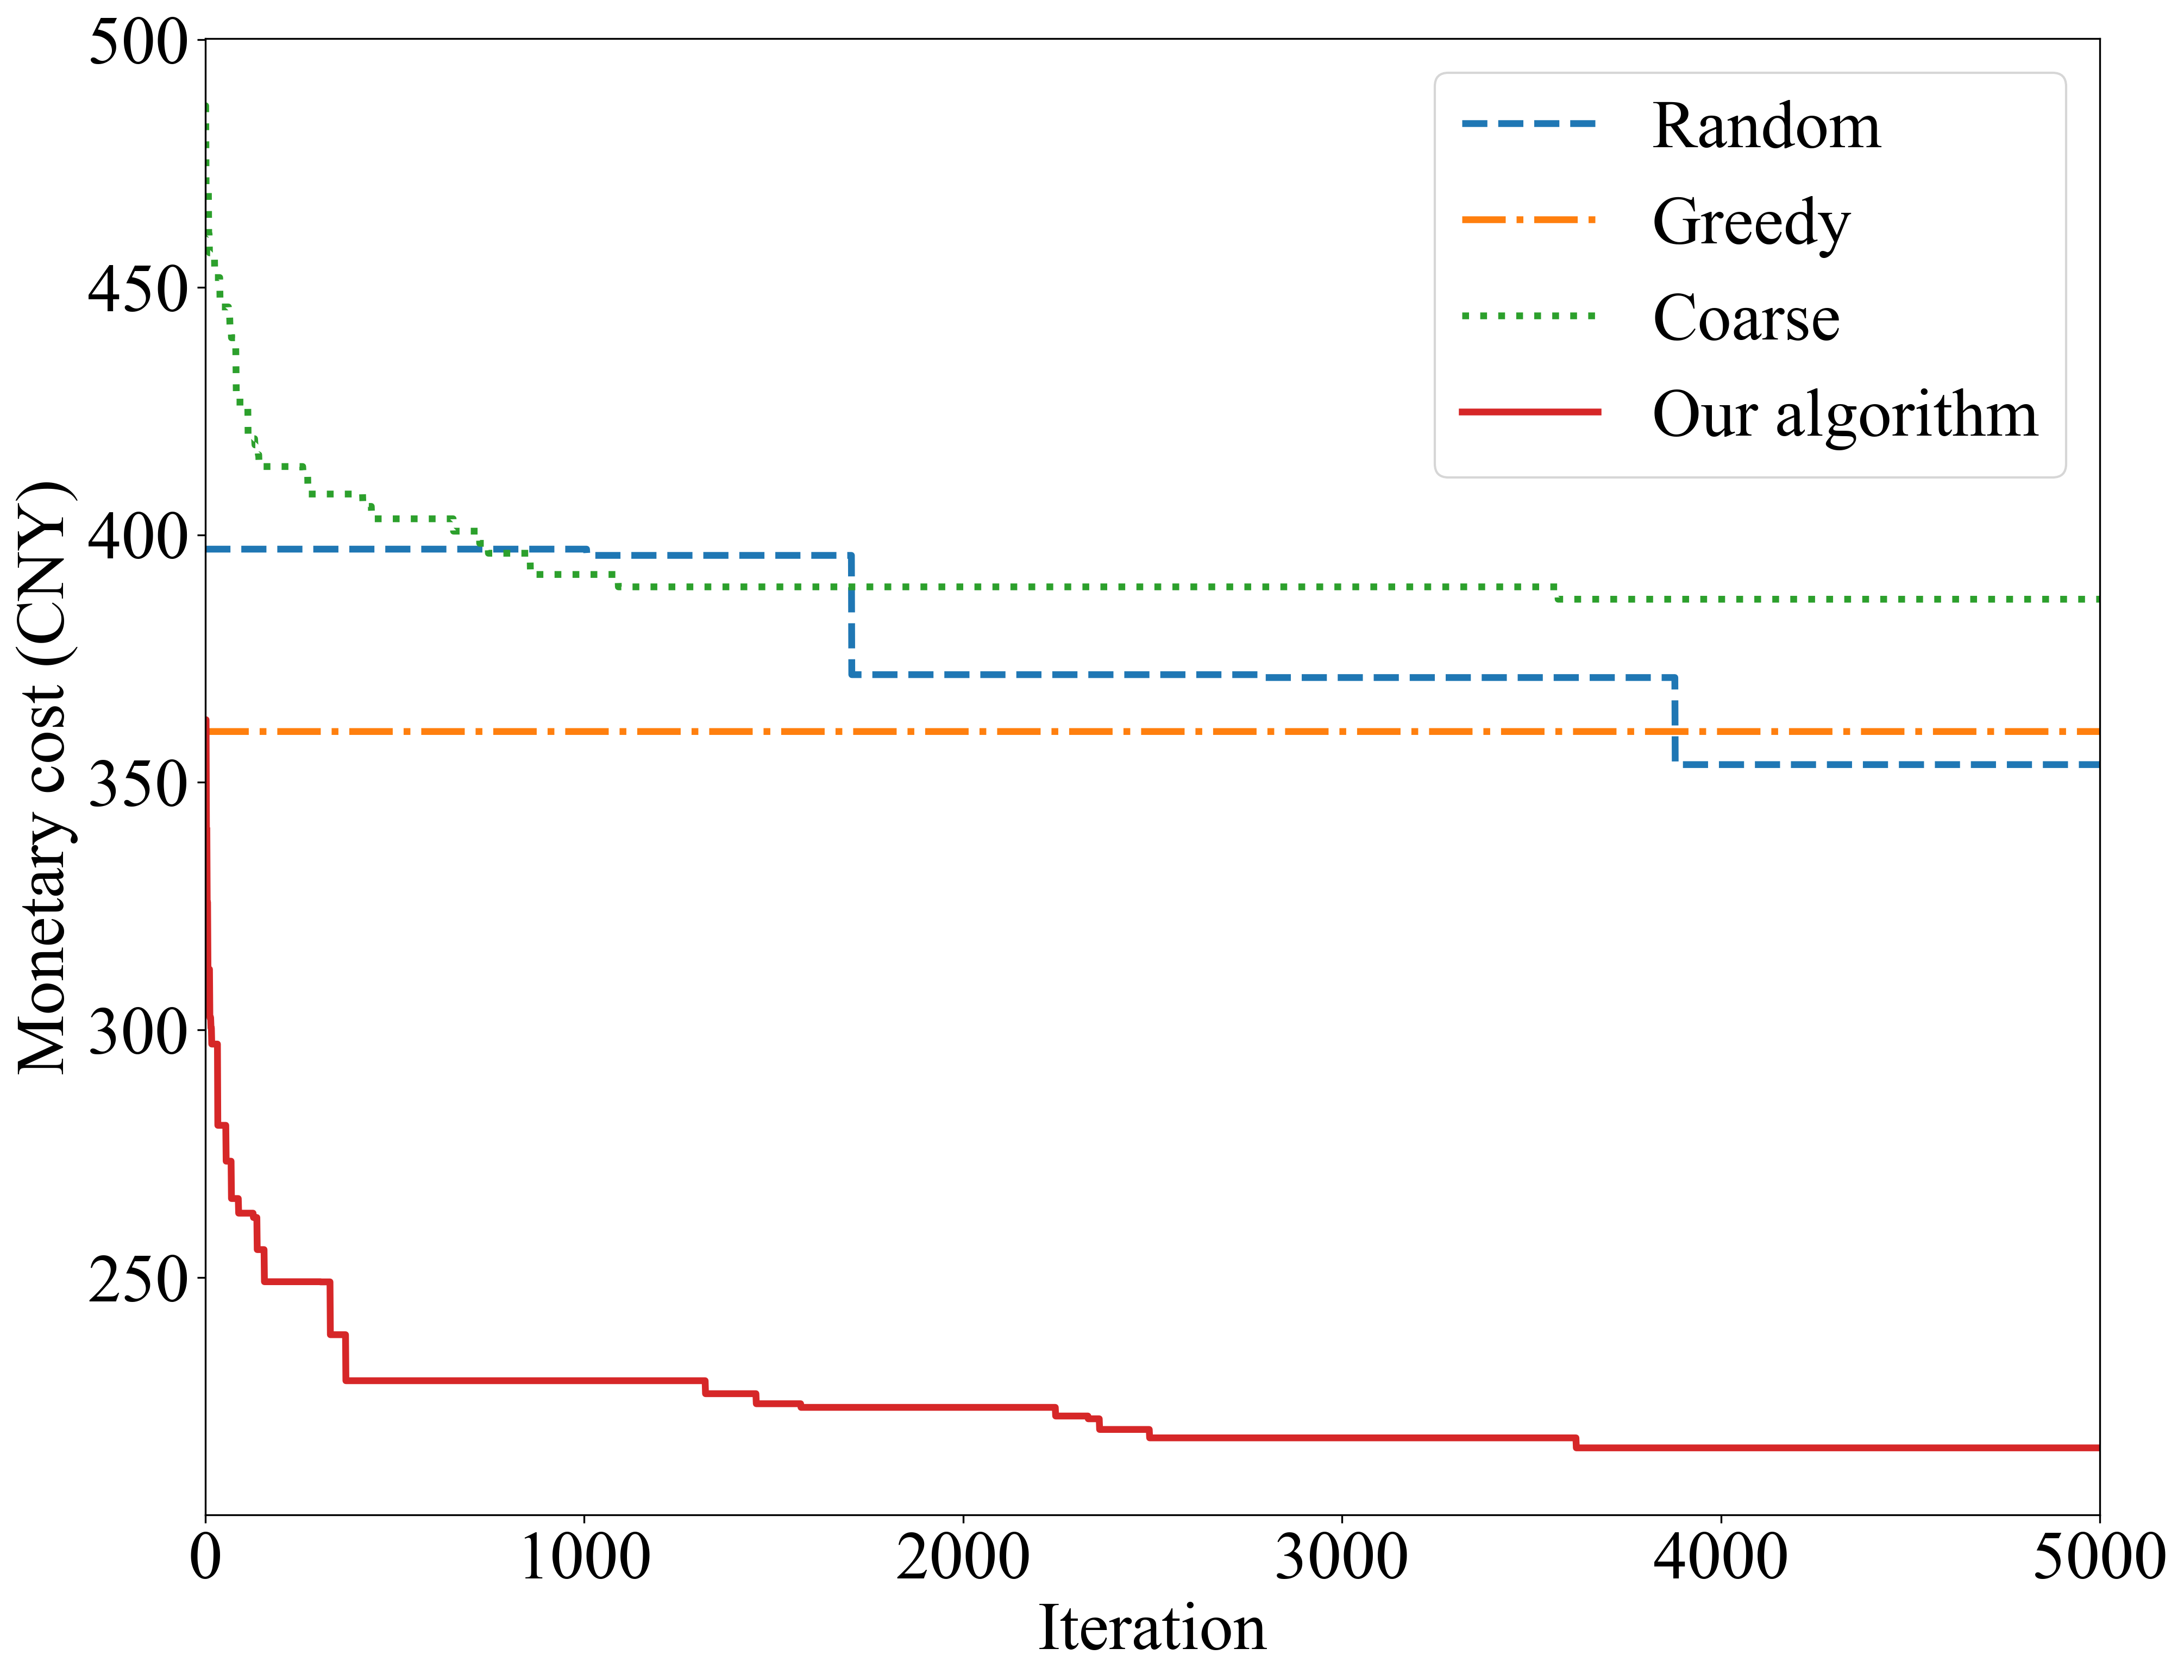

In [21]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rc('font',family='Times New Roman')

#result_random_ondemand = guess_x_random(total_iters, greedy=False)
x_data = range(len(result_gibbs_ondemand))

figure(num=None, figsize=(15,12), dpi=300, facecolor='w', edgecolor='k')
plt.margins(x=0)
plt.xlim(0,5000)

plt.plot(x_data, result_random_ondemand, '--', linewidth = 3.0, label="Random")
plt.plot(x_data, result_greedy, '-.', linewidth = 3.0, label="Greedy")
plt.plot(x_data, result_gibbs_greedy, ':', linewidth = 3.0, label="Coarse")
plt.plot(x_data, result_gibbs_ondemand, '-', linewidth = 3.0, label="Our algorithm")

ax = plt.subplot(111)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Monetary cost (CNY)", fontsize=30)
plt.xlabel("Iteration", fontsize=30)
plt.legend(fontsize=30)

plt.savefig("cost.png")
plt.show()


In [19]:
n = 10 #server 5,4,1
m = 8 #service
s = np.array([10, 5, 5, 15, 10, 15, 20, 25])
c = np.array([50, 70, 60, 65, 55, 130, 100, 160, 140, 200])
Pc = np.array([25, 30, 30, 32, 22, 33, 29, 38, 35, 40])
f = np.array([50, 55, 80, 53, 60, 75, 125, 130, 100, 150])
Pf = np.array([24, 22, 28, 25, 30, 39, 40, 50, 34, 48])
d = np.array([0.045, 0.02, 0.035, 0.04, 0.03, 0.045, 0.038, 0.04])
r = np.array([0.1, 0.2, 0.1, 0.3, 0.15, 0.2, 0.25, 0.14])
l = 5 #base station
t = np.array([[0.005,0.006,0.001,0.004,0.005, 0.011,0.013,0.010,0.012, 0.015],
        [0.001,0.002,0.005,0.005,0.004, 0.010,0.010,0.014,0.013, 0.015],
        [0.003,0.004,0.006,0.001,0.002, 0.013,0.010,0.011,0.013, 0.015],
        [0.006,0.001,0.003,0.004,0.005, 0.011,0.014,0.012,0.010, 0.015],
        [0.002,0.003,0.004,0.005,0.001, 0.012,0.013,0.010,0.010, 0.015]]) #l * n
la = np.array([[50,59,70,69,57],[69,50,50,60,57],[69,50,56,61,70],[70,59,63,54,60],[56,62,57,60,50],[50,57,60,51,70],[61,50,52,70,55],[50,69,56,70,61]]) # m * l


In [18]:
total_iters = 5000

n = 10 #server 5,4,1
m = 8 #service
s = np.array([10, 5, 5, 15, 10, 15, 20, 25])
c = np.array([50, 70, 60, 65, 55, 130, 100, 160, 140, 200])
Pc = np.array([25, 30, 30, 32, 22, 33, 29, 38, 35, 40])
f = np.array([50, 55, 80, 53, 60, 75, 125, 130, 100, 150])
Pf = np.array([24, 22, 28, 25, 30, 39, 40, 50, 34, 48])
d = np.array([0.045, 0.02, 0.035, 0.04, 0.03, 0.045, 0.038, 0.04])
r = np.array([0.1, 0.2, 0.1, 0.3, 0.15, 0.2, 0.25, 0.14])
l = 5 

f = np.array([49, 47, 72, 45, 52, 67, 117, 122, 92, 140])
Pf = np.array([26, 24, 30, 27, 32, 41, 42, 52, 36, 50])
#result_gibbs_ondemand1 = guess_x_gibbs(total_iters, 1e-2, greedy=False)

f = np.array([48, 50, 74, 57, 54, 69, 119, 124, 94, 140])
result_gibbs_ondemand2 = guess_x_gibbs(total_iters, 1e-3, greedy=False)

f = np.array([50, 55, 80, 53, 60, 75, 125, 130, 100, 150])
Pf = np.array([25, 23, 29, 26, 31, 40, 41, 51, 35, 49])
result_gibbs_ondemand3 = guess_x_gibbs(total_iters, 1e-4, greedy=False)

f = np.array([50, 55, 80, 53, 60, 75, 125, 130, 100, 145])
result_gibbs_ondemand4 = guess_x_gibbs(total_iters, 1e-5, greedy=False)

f = np.array([50, 55, 80, 53, 60, 75, 125, 130, 100, 150])
Pf = np.array([24, 22, 28, 25, 30, 39, 40, 50, 34, 48])
result_gibbs_ondemand5 = guess_x_gibbs(total_iters, 1e-6, greedy=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.


[INIT]		: cost=400.19845248086375
[  0][SKIP]		: False


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:241: RuntimeWarning: overflow encountered in exp


[  1][KEEP]		: new_cost=401.2827605523824, old_cost=400.19845248086375, prob=0.0 -- 400.19845248086375
[  2][SKIP]		: False
[  3][SKIP]		: False
[  4][SKIP]		: False
[  5][CHANGE]	: new_cost=394.7465840859035, old_cost=400.19845248086375, prob=1.0 -- 394.7465840859035
[  6][SKIP]		: True
[  7][CHANGE]	: new_cost=386.3453743336463, old_cost=394.7465840859035, prob=1.0 -- 386.3453743336463
[  8][SKIP]		: True
[  9][SKIP]		: False
[ 10][SKIP]		: False
[ 11][SKIP]		: False
[ 12][SKIP]		: False
[ 13][SKIP]		: False
[ 14][SKIP]		: False
[ 15][KEEP]		: new_cost=398.7097228947758, old_cost=386.3453743336463, prob=0.0 -- 386.3453743336463
[ 16][SKIP]		: False
[ 17][KEEP]		: new_cost=388.66604927362954, old_cost=386.3453743336463, prob=0.0 -- 386.3453743336463
[ 18][KEEP]		: new_cost=391.4657677482735, old_cost=386.3453743336463, prob=0.0 -- 386.3453743336463
[ 19][SKIP]		: False
[ 20][KEEP]		: new_cost=388.2492759114336, old_cost=386.3453743336463, prob=0.0 -- 386.3453743336463
[ 21][SKIP]		: F

[122][CHANGE]	: new_cost=291.2067255653506, old_cost=306.1886710753401, prob=1.0 -- 291.2067255653506
[123][SKIP]		: False
[124][KEEP]		: new_cost=298.7316478654552, old_cost=291.2067255653506, prob=0.0 -- 291.2067255653506
[125][SKIP]		: False
[126][CHANGE]	: new_cost=283.1334980720023, old_cost=291.2067255653506, prob=1.0 -- 283.1334980720023
[127][KEEP]		: new_cost=312.70959746214015, old_cost=283.1334980720023, prob=0.0 -- 283.1334980720023
[128][KEEP]		: new_cost=314.38033577806425, old_cost=283.1334980720023, prob=0.0 -- 283.1334980720023
[129][KEEP]		: new_cost=298.81087721956, old_cost=283.1334980720023, prob=0.0 -- 283.1334980720023
[130][SKIP]		: False
[131][CHANGE]	: new_cost=274.7322883955105, old_cost=283.1334980720023, prob=1.0 -- 274.7322883955105
[132][KEEP]		: new_cost=275.7150296279594, old_cost=274.7322883955105, prob=0.0 -- 274.7322883955105
[133][KEEP]		: new_cost=299.342789111303, old_cost=274.7322883955105, prob=0.0 -- 274.7322883955105
[134][KEEP]		: new_cost=29

[246][SKIP]		: False
[247][KEEP]		: new_cost=275.32801732765193, old_cost=258.9159623668831, prob=0.0 -- 258.9159623668831
[248][KEEP]		: new_cost=287.6231520224895, old_cost=258.9159623668831, prob=0.0 -- 258.9159623668831
[249][SKIP]		: True
[250][SKIP]		: False
[251][KEEP]		: new_cost=266.18079726559745, old_cost=258.9159623668831, prob=0.0 -- 258.9159623668831
[252][KEEP]		: new_cost=290.02953952362185, old_cost=258.9159623668831, prob=0.0 -- 258.9159623668831
[253][SKIP]		: False
[254][KEEP]		: new_cost=270.0567024873174, old_cost=258.9159623668831, prob=0.0 -- 258.9159623668831
[255][KEEP]		: new_cost=273.38047371518326, old_cost=258.9159623668831, prob=0.0 -- 258.9159623668831
[256][KEEP]		: new_cost=299.81863227619544, old_cost=258.9159623668831, prob=0.0 -- 258.9159623668831
[257][KEEP]		: new_cost=282.5434756959426, old_cost=258.9159623668831, prob=0.0 -- 258.9159623668831
[258][KEEP]		: new_cost=266.18079726559745, old_cost=258.9159623668831, prob=0.0 -- 258.9159623668831
[2

[383][SKIP]		: False
[384][KEEP]		: new_cost=265.4713851375616, old_cost=247.50595295560436, prob=0.0 -- 247.50595295560436
[385][SKIP]		: False
[386][SKIP]		: False
[387][SKIP]		: False
[388][KEEP]		: new_cost=279.3784171445117, old_cost=247.50595295560436, prob=0.0 -- 247.50595295560436
[389][SKIP]		: True
[390][SKIP]		: False
[391][SKIP]		: False
[392][KEEP]		: new_cost=267.09691182717296, old_cost=247.50595295560436, prob=0.0 -- 247.50595295560436
[393][SKIP]		: False
[394][KEEP]		: new_cost=258.5830594586711, old_cost=247.50595295560436, prob=0.0 -- 247.50595295560436
[395][KEEP]		: new_cost=286.03344591110476, old_cost=247.50595295560436, prob=0.0 -- 247.50595295560436
[396][KEEP]		: new_cost=276.59439672345184, old_cost=247.50595295560436, prob=0.0 -- 247.50595295560436
[397][SKIP]		: True
[398][KEEP]		: new_cost=288.2022825449922, old_cost=247.50595295560436, prob=0.0 -- 247.50595295560436
[399][KEEP]		: new_cost=287.31813849509047, old_cost=247.50595295560436, prob=0.0 -- 247.

[512][KEEP]		: new_cost=262.27038207404706, old_cost=247.50595295560436, prob=0.0 -- 247.50595295560436
[513][SKIP]		: False
[514][SKIP]		: False
[515][SKIP]		: True
[516][SKIP]		: False
[517][KEEP]		: new_cost=258.5249052249648, old_cost=247.50595295560436, prob=0.0 -- 247.50595295560436
[518][KEEP]		: new_cost=285.98214521500284, old_cost=247.50595295560436, prob=0.0 -- 247.50595295560436
[519][KEEP]		: new_cost=265.212010920044, old_cost=247.50595295560436, prob=0.0 -- 247.50595295560436
[520][SKIP]		: False
[521][SKIP]		: False
[522][SKIP]		: True
[523][KEEP]		: new_cost=257.91582960573066, old_cost=247.50595295560436, prob=0.0 -- 247.50595295560436
[524][SKIP]		: False
[525][KEEP]		: new_cost=272.85377437371585, old_cost=247.50595295560436, prob=0.0 -- 247.50595295560436
[526][SKIP]		: False
[527][SKIP]		: False
[528][KEEP]		: new_cost=266.5828571579693, old_cost=247.50595295560436, prob=0.0 -- 247.50595295560436
[529][KEEP]		: new_cost=280.6260362989001, old_cost=247.505952955604

[664][SKIP]		: False
[665][SKIP]		: False
[666][SKIP]		: True
[667][SKIP]		: False
[668][KEEP]		: new_cost=263.73394597539396, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[669][KEEP]		: new_cost=264.7544717700511, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[670][SKIP]		: False
[671][SKIP]		: False
[672][KEEP]		: new_cost=261.95239124496453, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[673][SKIP]		: False
[674][SKIP]		: False
[675][SKIP]		: False
[676][KEEP]		: new_cost=259.8256586317282, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[677][KEEP]		: new_cost=284.18235029978445, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[678][SKIP]		: False
[679][KEEP]		: new_cost=274.2639956466197, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[680][SKIP]		: False
[681][KEEP]		: new_cost=265.5287847376221, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[682][KEEP]		: new_cost=275.3228104887356, old

[810][SKIP]		: False
[811][SKIP]		: True
[812][KEEP]		: new_cost=252.1669543656795, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[813][SKIP]		: True
[814][SKIP]		: False
[815][SKIP]		: False
[816][KEEP]		: new_cost=274.52486507459923, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[817][SKIP]		: False
[818][KEEP]		: new_cost=255.73943345302632, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[819][KEEP]		: new_cost=274.4901858283286, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[820][SKIP]		: False
[821][SKIP]		: False
[822][SKIP]		: False
[823][SKIP]		: False
[824][KEEP]		: new_cost=254.22683943283695, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[825][KEEP]		: new_cost=259.00851360321263, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[826][KEEP]		: new_cost=262.5047246699153, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[827][KEEP]		: new_cost=250.73150345169375, old_cost=243.0486748470

[971][SKIP]		: False
[972][SKIP]		: True
[973][KEEP]		: new_cost=273.423724632693, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[974][KEEP]		: new_cost=292.1462143085942, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[975][SKIP]		: False
[976][SKIP]		: True
[977][KEEP]		: new_cost=271.2937578607708, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[978][KEEP]		: new_cost=281.5761675039598, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[979][KEEP]		: new_cost=265.32580307402515, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[980][SKIP]		: False
[981][KEEP]		: new_cost=275.03915114152187, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[982][SKIP]		: False
[983][SKIP]		: False
[984][SKIP]		: False
[985][SKIP]		: False
[986][SKIP]		: True
[987][KEEP]		: new_cost=248.65581791275872, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[988][SKIP]		: True
[989][SKIP]		: False
[990][KEEP]		: new_cost=268.6

[1115][KEEP]		: new_cost=278.1199803772087, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1116][SKIP]		: False
[1117][SKIP]		: False
[1118][KEEP]		: new_cost=270.64950797691006, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1119][SKIP]		: False
[1120][KEEP]		: new_cost=257.71789961912407, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1121][KEEP]		: new_cost=267.8702791540805, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1122][SKIP]		: False
[1123][KEEP]		: new_cost=270.097997124618, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1124][KEEP]		: new_cost=261.95485988342944, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1125][SKIP]		: False
[1126][SKIP]		: True
[1127][KEEP]		: new_cost=255.18900450462237, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1128][SKIP]		: True
[1129][SKIP]		: False
[1130][SKIP]		: True
[1131][SKIP]		: False
[1132][KEEP]		: new_cost=282.3640896832677, old_cost

[1265][KEEP]		: new_cost=281.58086658016333, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1266][SKIP]		: False
[1267][KEEP]		: new_cost=266.8501203973851, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1268][SKIP]		: False
[1269][KEEP]		: new_cost=258.9363636597387, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1270][SKIP]		: False
[1271][SKIP]		: True
[1272][KEEP]		: new_cost=260.7168427215532, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1273][SKIP]		: True
[1274][SKIP]		: True
[1275][KEEP]		: new_cost=262.8307525753289, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1276][SKIP]		: False
[1277][SKIP]		: False
[1278][SKIP]		: False
[1279][KEEP]		: new_cost=282.8608630316514, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1280][SKIP]		: False
[1281][SKIP]		: False
[1282][SKIP]		: False
[1283][KEEP]		: new_cost=254.39682358988145, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1284][SK

[1400][SKIP]		: True
[1401][KEEP]		: new_cost=285.4212019151398, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1402][KEEP]		: new_cost=276.5724846302169, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1403][KEEP]		: new_cost=286.99811287728556, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1404][SKIP]		: True
[1405][KEEP]		: new_cost=245.43449688634365, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1406][KEEP]		: new_cost=269.355964686164, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1407][KEEP]		: new_cost=264.89598535624367, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1408][KEEP]		: new_cost=258.58497113368657, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1409][KEEP]		: new_cost=253.50700828810827, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1410][KEEP]		: new_cost=262.74834238761764, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1411][SKIP]		: T

[1546][KEEP]		: new_cost=261.7401860986606, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1547][KEEP]		: new_cost=256.9824235431427, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1548][KEEP]		: new_cost=251.34018075040623, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1549][KEEP]		: new_cost=263.3597875670018, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1550][SKIP]		: False
[1551][SKIP]		: False
[1552][SKIP]		: True
[1553][SKIP]		: False
[1554][KEEP]		: new_cost=274.5567907865104, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1555][KEEP]		: new_cost=275.308152439115, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1556][KEEP]		: new_cost=275.48508810802514, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1557][SKIP]		: False
[1558][SKIP]		: True
[1559][SKIP]		: False
[1560][SKIP]		: False
[1561][KEEP]		: new_cost=262.8307525753289, old_cost=243.04867484701748, prob=0.0 -- 243.04867484

[1676][KEEP]		: new_cost=281.5761675039598, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1677][KEEP]		: new_cost=253.09805690465814, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1678][KEEP]		: new_cost=256.7604088125617, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1679][SKIP]		: False
[1680][SKIP]		: False
[1681][SKIP]		: False
[1682][KEEP]		: new_cost=256.53780516218046, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1683][KEEP]		: new_cost=276.0252223266097, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1684][KEEP]		: new_cost=259.2391508790395, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1685][KEEP]		: new_cost=264.47757425479796, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1686][SKIP]		: False
[1687][SKIP]		: False
[1688][SKIP]		: False
[1689][KEEP]		: new_cost=252.9754297815007, old_cost=243.04867484701748, prob=0.0 -- 243.04867484701748
[1690][SKIP]		: False
[1691][KEEP

[1820][SKIP]		: False
[1821][SKIP]		: True
[1822][KEEP]		: new_cost=271.69496174289367, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[1823][SKIP]		: False
[1824][KEEP]		: new_cost=273.29297209548673, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[1825][SKIP]		: True
[1826][SKIP]		: False
[1827][SKIP]		: True
[1828][KEEP]		: new_cost=263.311614973407, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[1829][SKIP]		: False
[1830][KEEP]		: new_cost=259.75343647782495, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[1831][SKIP]		: True
[1832][SKIP]		: False
[1833][SKIP]		: False
[1834][SKIP]		: True
[1835][KEEP]		: new_cost=277.10923421694037, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[1836][KEEP]		: new_cost=251.63442121375667, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[1837][KEEP]		: new_cost=264.9238505580857, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[1838][SKIP]		: True
[1839][SKI

[1958][KEEP]		: new_cost=270.0458525701883, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[1959][SKIP]		: True
[1960][SKIP]		: True
[1961][SKIP]		: True
[1962][SKIP]		: True
[1963][SKIP]		: False
[1964][SKIP]		: False
[1965][SKIP]		: True
[1966][KEEP]		: new_cost=276.94391289401125, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[1967][SKIP]		: True
[1968][KEEP]		: new_cost=245.45833384033278, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[1969][KEEP]		: new_cost=262.27248100406416, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[1970][SKIP]		: True
[1971][KEEP]		: new_cost=266.66593234487664, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[1972][SKIP]		: True
[1973][SKIP]		: True
[1974][SKIP]		: False
[1975][SKIP]		: False
[1976][KEEP]		: new_cost=254.82747491459475, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[1977][SKIP]		: True
[1978][KEEP]		: new_cost=273.6631514024788, old_cost=241.00105562782872, 

[2099][KEEP]		: new_cost=277.16875792632254, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2100][KEEP]		: new_cost=259.63601312813097, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2101][SKIP]		: True
[2102][SKIP]		: False
[2103][SKIP]		: False
[2104][KEEP]		: new_cost=249.69332913155327, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2105][SKIP]		: False
[2106][SKIP]		: False
[2107][SKIP]		: False
[2108][SKIP]		: False
[2109][SKIP]		: True
[2110][SKIP]		: True
[2111][SKIP]		: False
[2112][KEEP]		: new_cost=262.10923371370995, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2113][KEEP]		: new_cost=269.0367701479346, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2114][SKIP]		: False
[2115][KEEP]		: new_cost=256.8633698021795, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2116][SKIP]		: False
[2117][SKIP]		: False
[2118][SKIP]		: False
[2119][SKIP]		: True
[2120][SKIP]		: True
[2121][KEEP]		: new_cost=

[2236][KEEP]		: new_cost=260.84280129074233, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2237][SKIP]		: False
[2238][SKIP]		: False
[2239][SKIP]		: True
[2240][SKIP]		: False
[2241][KEEP]		: new_cost=258.51927521564414, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2242][SKIP]		: True
[2243][SKIP]		: False
[2244][KEEP]		: new_cost=251.14509564353193, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2245][SKIP]		: True
[2246][KEEP]		: new_cost=261.5618442497415, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2247][SKIP]		: False
[2248][SKIP]		: True
[2249][SKIP]		: False
[2250][KEEP]		: new_cost=270.6974842327498, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2251][KEEP]		: new_cost=277.02590075759434, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2252][KEEP]		: new_cost=263.7813027148409, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2253][SKIP]		: False
[2254][SKIP]		: True
[2255][KE

[2383][KEEP]		: new_cost=263.49040973058123, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2384][KEEP]		: new_cost=249.95725647411336, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2385][SKIP]		: False
[2386][SKIP]		: False
[2387][KEEP]		: new_cost=264.7544717700511, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2388][SKIP]		: False
[2389][SKIP]		: True
[2390][KEEP]		: new_cost=262.5606299898896, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2391][KEEP]		: new_cost=249.69332913155327, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2392][KEEP]		: new_cost=258.4578458923278, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2393][SKIP]		: False
[2394][KEEP]		: new_cost=269.3763161401332, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2395][SKIP]		: False
[2396][KEEP]		: new_cost=273.5239559043286, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2397][SKIP]		: True
[2398][KEEP]	

[2521][SKIP]		: False
[2522][SKIP]		: True
[2523][SKIP]		: False
[2524][KEEP]		: new_cost=265.6201030141167, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2525][SKIP]		: False
[2526][SKIP]		: False
[2527][KEEP]		: new_cost=262.19963976413726, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2528][SKIP]		: False
[2529][KEEP]		: new_cost=268.82667954656864, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2530][KEEP]		: new_cost=250.0486745234234, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2531][SKIP]		: False
[2532][SKIP]		: True
[2533][SKIP]		: True
[2534][KEEP]		: new_cost=264.8724856071566, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2535][SKIP]		: False
[2536][KEEP]		: new_cost=265.8226590149125, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2537][SKIP]		: True
[2538][SKIP]		: True
[2539][KEEP]		: new_cost=264.384237078895, old_cost=241.00105562782872, prob=0.0 -- 241.00105562782872
[2540][KEEP]

[2662][KEEP]		: new_cost=278.5175766875509, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2663][SKIP]		: True
[2664][SKIP]		: False
[2665][SKIP]		: False
[2666][SKIP]		: True
[2667][KEEP]		: new_cost=247.40190091782338, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2668][KEEP]		: new_cost=260.0770336107814, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2669][SKIP]		: False
[2670][KEEP]		: new_cost=263.3348891995248, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2671][SKIP]		: False
[2672][SKIP]		: False
[2673][KEEP]		: new_cost=278.96526580940906, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2674][SKIP]		: False
[2675][KEEP]		: new_cost=267.4821968142375, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2676][KEEP]		: new_cost=281.1070052504981, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2677][SKIP]		: True
[2678][SKIP]		: True
[2679][KEEP]		: new_cost=290.16411242574884, old_cost=239.9733296588

[2815][SKIP]		: True
[2816][SKIP]		: False
[2817][SKIP]		: False
[2818][SKIP]		: False
[2819][SKIP]		: False
[2820][SKIP]		: False
[2821][KEEP]		: new_cost=278.92682910783645, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2822][KEEP]		: new_cost=254.93361828370863, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2823][KEEP]		: new_cost=274.4624604427763, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2824][SKIP]		: True
[2825][KEEP]		: new_cost=264.83303823610316, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2826][KEEP]		: new_cost=275.14103217985894, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2827][KEEP]		: new_cost=277.3879258045657, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2828][SKIP]		: False
[2829][SKIP]		: False
[2830][KEEP]		: new_cost=287.1223928719514, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2831][SKIP]		: True
[2832][KEEP]		: new_cost=278.50082403240106, old_cost=239.9733296

[2959][SKIP]		: False
[2960][SKIP]		: False
[2961][SKIP]		: False
[2962][KEEP]		: new_cost=287.62380897324545, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2963][KEEP]		: new_cost=256.38538468617605, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2964][SKIP]		: False
[2965][SKIP]		: True
[2966][SKIP]		: True
[2967][SKIP]		: False
[2968][KEEP]		: new_cost=262.4341537629008, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2969][SKIP]		: False
[2970][KEEP]		: new_cost=251.05269498961277, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2971][KEEP]		: new_cost=252.83047244083573, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2972][KEEP]		: new_cost=263.92879503201044, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2973][KEEP]		: new_cost=254.17576011212904, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[2974][KEEP]		: new_cost=263.60340823222015, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[29

[3111][SKIP]		: True
[3112][SKIP]		: True
[3113][KEEP]		: new_cost=265.18865061945365, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[3114][SKIP]		: True
[3115][SKIP]		: False
[3116][SKIP]		: False
[3117][SKIP]		: True
[3118][KEEP]		: new_cost=260.0551636087318, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[3119][SKIP]		: True
[3120][SKIP]		: False
[3121][KEEP]		: new_cost=269.289461202237, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[3122][SKIP]		: True
[3123][SKIP]		: False
[3124][SKIP]		: False
[3125][KEEP]		: new_cost=272.91144228748664, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[3126][SKIP]		: True
[3127][KEEP]		: new_cost=259.19503638329616, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[3128][SKIP]		: True
[3129][SKIP]		: True
[3130][SKIP]		: False
[3131][SKIP]		: False
[3132][KEEP]		: new_cost=254.08836930767694, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[3133][KEEP]		: new_cost=258.2705090880319

[3258][KEEP]		: new_cost=252.47928229529967, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[3259][SKIP]		: False
[3260][KEEP]		: new_cost=272.67810051375227, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[3261][SKIP]		: False
[3262][KEEP]		: new_cost=250.01272355945895, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[3263][SKIP]		: True
[3264][KEEP]		: new_cost=261.8735766196827, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[3265][KEEP]		: new_cost=261.2257106396452, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[3266][KEEP]		: new_cost=261.9471702886333, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[3267][KEEP]		: new_cost=283.95528837644474, old_cost=239.9733296588781, prob=0.0 -- 239.9733296588781
[3268][SKIP]		: False
[3269][CHANGE]	: new_cost=237.93677490225278, old_cost=239.9733296588781, prob=1.0 -- 237.93677490225278
[3270][SKIP]		: True
[3271][SKIP]		: False
[3272][KEEP]		: new_cost=263.5839881098148, old

[3387][SKIP]		: False
[3388][KEEP]		: new_cost=237.93677490225278, old_cost=237.93677490225278, prob=0.5 -- 237.93677490225278
[3389][SKIP]		: True
[3390][SKIP]		: False
[3391][SKIP]		: False
[3392][KEEP]		: new_cost=266.1044770925363, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3393][KEEP]		: new_cost=260.5341182466809, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3394][KEEP]		: new_cost=248.21209948502306, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3395][SKIP]		: False
[3396][SKIP]		: False
[3397][SKIP]		: True
[3398][SKIP]		: True
[3399][SKIP]		: False
[3400][SKIP]		: True
[3401][KEEP]		: new_cost=267.472935936655, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3402][SKIP]		: True
[3403][SKIP]		: True
[3404][KEEP]		: new_cost=265.2224896605938, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3405][KEEP]		: new_cost=261.3199546516114, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3406][SKIP]	

[3530][KEEP]		: new_cost=269.0879653125501, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3531][KEEP]		: new_cost=261.34139483396154, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3532][SKIP]		: True
[3533][SKIP]		: False
[3534][SKIP]		: False
[3535][KEEP]		: new_cost=250.2934550414023, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3536][KEEP]		: new_cost=253.64046731920104, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3537][KEEP]		: new_cost=258.1629652470164, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3538][SKIP]		: True
[3539][KEEP]		: new_cost=255.50962557774974, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3540][SKIP]		: False
[3541][SKIP]		: True
[3542][KEEP]		: new_cost=270.3223664171687, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3543][KEEP]		: new_cost=250.17487004726075, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3544][SKIP]		: True
[3545][KEEP]		

[3667][KEEP]		: new_cost=258.0404789827272, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3668][KEEP]		: new_cost=255.75082173749047, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3669][KEEP]		: new_cost=282.17122247326574, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3670][KEEP]		: new_cost=251.56876234591618, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3671][KEEP]		: new_cost=263.72607495559043, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3672][SKIP]		: True
[3673][SKIP]		: False
[3674][SKIP]		: False
[3675][SKIP]		: False
[3676][SKIP]		: False
[3677][SKIP]		: False
[3678][SKIP]		: False
[3679][SKIP]		: False
[3680][KEEP]		: new_cost=270.14892039372563, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3681][KEEP]		: new_cost=259.8721787387827, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3682][KEEP]		: new_cost=251.64850968891943, old_cost=237.93677490225278, prob=0.0 -- 237.93

[3816][SKIP]		: False
[3817][KEEP]		: new_cost=255.752013202578, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3818][KEEP]		: new_cost=250.954296894604, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3819][SKIP]		: True
[3820][KEEP]		: new_cost=268.3454890774266, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3821][SKIP]		: False
[3822][SKIP]		: False
[3823][SKIP]		: True
[3824][KEEP]		: new_cost=278.6121177782838, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3825][SKIP]		: False
[3826][SKIP]		: False
[3827][KEEP]		: new_cost=247.71384717699033, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3828][SKIP]		: False
[3829][KEEP]		: new_cost=268.905851927928, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3830][SKIP]		: False
[3831][KEEP]		: new_cost=263.94289253743017, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3832][SKIP]		: False
[3833][SKIP]		: False
[3834][KEEP]		: new_cost=246.5224

[3973][SKIP]		: False
[3974][SKIP]		: True
[3975][SKIP]		: False
[3976][CHANGE]	: new_cost=237.93677490225278, old_cost=237.93677490225278, prob=0.5 -- 237.93677490225278
[3977][KEEP]		: new_cost=253.46468611081778, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3978][KEEP]		: new_cost=280.2373883203965, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3979][SKIP]		: False
[3980][KEEP]		: new_cost=268.10447770590787, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3981][KEEP]		: new_cost=286.3425736900035, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3982][KEEP]		: new_cost=260.62795155209676, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3983][SKIP]		: True
[3984][KEEP]		: new_cost=284.0169759329849, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3985][KEEP]		: new_cost=257.7284414468659, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[3986][SKIP]		: False
[3987][KEEP]		: new_cost=274.4788

[4127][SKIP]		: True
[4128][KEEP]		: new_cost=274.9331552134054, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[4129][KEEP]		: new_cost=251.75405886612373, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[4130][SKIP]		: False
[4131][SKIP]		: False
[4132][KEEP]		: new_cost=244.43060784620627, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[4133][SKIP]		: True
[4134][SKIP]		: True
[4135][KEEP]		: new_cost=254.99182161940675, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[4136][SKIP]		: False
[4137][KEEP]		: new_cost=246.71410299047403, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[4138][SKIP]		: True
[4139][SKIP]		: False
[4140][KEEP]		: new_cost=267.798953545879, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[4141][SKIP]		: False
[4142][KEEP]		: new_cost=255.27223956663434, old_cost=237.93677490225278, prob=0.0 -- 237.93677490225278
[4143][KEEP]		: new_cost=268.75923862692474, old_cost=237.93677490225278, 

[4263][KEEP]		: new_cost=281.48430421663875, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4264][SKIP]		: False
[4265][KEEP]		: new_cost=259.2319231549942, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4266][KEEP]		: new_cost=257.32287799418253, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4267][KEEP]		: new_cost=258.9075241620789, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4268][SKIP]		: True
[4269][SKIP]		: False
[4270][SKIP]		: False
[4271][KEEP]		: new_cost=267.75812676253037, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4272][SKIP]		: False
[4273][KEEP]		: new_cost=252.36711000371827, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4274][SKIP]		: False
[4275][KEEP]		: new_cost=246.68389509813673, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4276][KEEP]		: new_cost=269.5439997996796, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4277][SKIP]		: True
[4278][SKIP]		: False
[4279

[4403][KEEP]		: new_cost=258.7785069710677, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4404][KEEP]		: new_cost=272.6947525571243, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4405][KEEP]		: new_cost=264.4992382101289, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4406][KEEP]		: new_cost=250.88668499945325, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4407][SKIP]		: False
[4408][KEEP]		: new_cost=263.42136410439883, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4409][SKIP]		: False
[4410][SKIP]		: True
[4411][KEEP]		: new_cost=259.2319231549942, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4412][KEEP]		: new_cost=249.73088802714534, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4413][KEEP]		: new_cost=263.75500359843096, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4414][KEEP]		: new_cost=268.6018369332919, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4415][SKIP]	

[4534][SKIP]		: False
[4535][SKIP]		: True
[4536][KEEP]		: new_cost=252.34993562360265, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4537][KEEP]		: new_cost=251.70857034200625, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4538][SKIP]		: True
[4539][KEEP]		: new_cost=261.26411181826273, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4540][SKIP]		: False
[4541][KEEP]		: new_cost=251.26665101210568, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4542][KEEP]		: new_cost=262.2795423874366, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4543][KEEP]		: new_cost=263.4095927251316, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4544][SKIP]		: False
[4545][KEEP]		: new_cost=240.3671116900601, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4546][SKIP]		: True
[4547][SKIP]		: True
[4548][SKIP]		: False
[4549][KEEP]		: new_cost=267.23192423983613, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4550][

[4674][SKIP]		: True
[4675][KEEP]		: new_cost=257.91684961775064, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4676][SKIP]		: False
[4677][SKIP]		: True
[4678][KEEP]		: new_cost=257.2904117099141, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4679][KEEP]		: new_cost=254.39755479966345, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4680][KEEP]		: new_cost=273.0070785978981, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4681][SKIP]		: False
[4682][SKIP]		: False
[4683][SKIP]		: True
[4684][SKIP]		: False
[4685][SKIP]		: False
[4686][SKIP]		: False
[4687][SKIP]		: False
[4688][SKIP]		: False
[4689][SKIP]		: True
[4690][KEEP]		: new_cost=268.22136431733117, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4691][SKIP]		: False
[4692][SKIP]		: False
[4693][SKIP]		: True
[4694][SKIP]		: True
[4695][KEEP]		: new_cost=286.16176018599384, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4696][KEEP]		: new_cost=262.898590790

[4821][SKIP]		: False
[4822][SKIP]		: False
[4823][KEEP]		: new_cost=272.5761265544395, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4824][SKIP]		: False
[4825][SKIP]		: False
[4826][KEEP]		: new_cost=280.0235901123683, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4827][SKIP]		: True
[4828][KEEP]		: new_cost=263.37151047608023, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4829][KEEP]		: new_cost=254.3627540645968, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4830][SKIP]		: False
[4831][SKIP]		: False
[4832][KEEP]		: new_cost=249.3985407752979, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4833][SKIP]		: False
[4834][KEEP]		: new_cost=270.75404250954364, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4835][SKIP]		: False
[4836][SKIP]		: False
[4837][KEEP]		: new_cost=264.0810218620544, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4838][SKIP]		: True
[4839][SKIP]		: False
[4840][SKIP]		: True
[

[4972][SKIP]		: False
[4973][SKIP]		: False
[4974][KEEP]		: new_cost=246.3591732635428, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4975][SKIP]		: False
[4976][KEEP]		: new_cost=251.1514812232679, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4977][SKIP]		: False
[4978][SKIP]		: False
[4979][SKIP]		: False
[4980][SKIP]		: False
[4981][SKIP]		: True
[4982][SKIP]		: False
[4983][SKIP]		: False
[4984][SKIP]		: True
[4985][KEEP]		: new_cost=254.5210115925414, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4986][KEEP]		: new_cost=260.51395679711135, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4987][KEEP]		: new_cost=247.47416814050453, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4988][KEEP]		: new_cost=291.02113063790614, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4989][KEEP]		: new_cost=266.85097134671287, old_cost=237.0642212681491, prob=0.0 -- 237.0642212681491
[4990][SKIP]		: False
[4991][KEEP]		: new_

[ 97][SKIP]		: False
[ 98][SKIP]		: False
[ 99][KEEP]		: new_cost=325.75348153511635, old_cost=307.18783115161034, prob=0.0 -- 307.18783115161034
[100][SKIP]		: False
[101][CHANGE]	: new_cost=292.86679982140885, old_cost=307.18783115161034, prob=1.0 -- 292.86679982140885
[102][KEEP]		: new_cost=296.9209886242049, old_cost=292.86679982140885, prob=0.0 -- 292.86679982140885
[103][KEEP]		: new_cost=318.49801590877433, old_cost=292.86679982140885, prob=0.0 -- 292.86679982140885
[104][SKIP]		: True
[105][SKIP]		: False
[106][SKIP]		: False
[107][SKIP]		: False
[108][KEEP]		: new_cost=314.2662918356968, old_cost=292.86679982140885, prob=0.0 -- 292.86679982140885
[109][KEEP]		: new_cost=306.1207257372642, old_cost=292.86679982140885, prob=0.0 -- 292.86679982140885
[110][KEEP]		: new_cost=323.4720078795161, old_cost=292.86679982140885, prob=0.0 -- 292.86679982140885
[111][KEEP]		: new_cost=303.25324959984425, old_cost=292.86679982140885, prob=0.0 -- 292.86679982140885
[112][SKIP]		: True
[113]

[220][SKIP]		: True
[221][SKIP]		: False
[222][SKIP]		: False
[223][SKIP]		: False
[224][SKIP]		: False
[225][SKIP]		: False
[226][KEEP]		: new_cost=298.3826277490091, old_cost=270.0799922881952, prob=0.0 -- 270.0799922881952
[227][SKIP]		: False
[228][CHANGE]	: new_cost=266.0401701540835, old_cost=270.0799922881952, prob=1.0 -- 266.0401701540835
[229][SKIP]		: True
[230][KEEP]		: new_cost=287.6415727158956, old_cost=266.0401701540835, prob=0.0 -- 266.0401701540835
[231][CHANGE]	: new_cost=261.1697796400603, old_cost=266.0401701540835, prob=1.0 -- 261.1697796400603
[232][KEEP]		: new_cost=285.91699732578, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[233][KEEP]		: new_cost=282.45775970750856, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[234][KEEP]		: new_cost=272.1010313556436, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[235][KEEP]		: new_cost=266.34755379644105, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[236][KEEP]		: new_cost=

[349][KEEP]		: new_cost=263.2099332634634, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[350][KEEP]		: new_cost=292.1019270955928, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[351][KEEP]		: new_cost=261.30986825792775, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[352][SKIP]		: False
[353][SKIP]		: True
[354][SKIP]		: False
[355][KEEP]		: new_cost=290.8186680659969, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[356][SKIP]		: False
[357][SKIP]		: False
[358][SKIP]		: False
[359][SKIP]		: False
[360][SKIP]		: False
[361][SKIP]		: False
[362][KEEP]		: new_cost=290.9622149305254, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[363][SKIP]		: True
[364][KEEP]		: new_cost=289.3894861532943, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[365][SKIP]		: True
[366][KEEP]		: new_cost=269.9598536905798, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[367][SKIP]		: False
[368][SKIP]		: False
[369][KEEP]		: new_cos

[478][KEEP]		: new_cost=297.1699921686033, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[479][SKIP]		: True
[480][SKIP]		: False
[481][KEEP]		: new_cost=278.70174501270594, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[482][KEEP]		: new_cost=297.92543217774806, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[483][SKIP]		: True
[484][SKIP]		: True
[485][SKIP]		: True
[486][SKIP]		: False
[487][KEEP]		: new_cost=297.01208208647324, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[488][KEEP]		: new_cost=275.65934688376774, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[489][SKIP]		: True
[490][SKIP]		: False
[491][KEEP]		: new_cost=272.8687031843074, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[492][SKIP]		: False
[493][KEEP]		: new_cost=272.6662920720683, old_cost=261.1697796400603, prob=0.0 -- 261.1697796400603
[494][SKIP]		: False
[495][SKIP]		: True
[496][KEEP]		: new_cost=289.690025301208, old_cost=261.169779640

[609][SKIP]		: False
[610][KEEP]		: new_cost=275.1721115954091, old_cost=260.4519402296212, prob=0.0 -- 260.4519402296212
[611][SKIP]		: False
[612][SKIP]		: False
[613][KEEP]		: new_cost=260.55932685369373, old_cost=260.4519402296212, prob=0.0 -- 260.4519402296212
[614][SKIP]		: True
[615][SKIP]		: True
[616][SKIP]		: False
[617][KEEP]		: new_cost=288.31754010447844, old_cost=260.4519402296212, prob=0.0 -- 260.4519402296212
[618][SKIP]		: False
[619][SKIP]		: False
[620][KEEP]		: new_cost=281.7438604215681, old_cost=260.4519402296212, prob=0.0 -- 260.4519402296212
[621][SKIP]		: False
[622][SKIP]		: False
[623][SKIP]		: False
[624][SKIP]		: True
[625][KEEP]		: new_cost=276.591021040688, old_cost=260.4519402296212, prob=0.0 -- 260.4519402296212
[626][SKIP]		: False
[627][SKIP]		: True
[628][KEEP]		: new_cost=270.8401496416107, old_cost=260.4519402296212, prob=0.0 -- 260.4519402296212
[629][SKIP]		: False
[630][KEEP]		: new_cost=277.8071520261531, old_cost=260.4519402296212, prob=0.0 --

[765][SKIP]		: False
[766][SKIP]		: True
[767][KEEP]		: new_cost=261.96782719162235, old_cost=251.5795984562102, prob=0.0 -- 251.5795984562102
[768][SKIP]		: True
[769][KEEP]		: new_cost=277.56583206435687, old_cost=251.5795984562102, prob=0.0 -- 251.5795984562102
[770][SKIP]		: False
[771][SKIP]		: False
[772][SKIP]		: True
[773][SKIP]		: False
[774][SKIP]		: True
[775][SKIP]		: True
[776][SKIP]		: False
[777][SKIP]		: False
[778][SKIP]		: False
[779][SKIP]		: False
[780][SKIP]		: True
[781][KEEP]		: new_cost=269.55241499572355, old_cost=251.5795984562102, prob=0.0 -- 251.5795984562102
[782][KEEP]		: new_cost=271.58870660826574, old_cost=251.5795984562102, prob=0.0 -- 251.5795984562102
[783][KEEP]		: new_cost=290.8936566746322, old_cost=251.5795984562102, prob=0.0 -- 251.5795984562102
[784][SKIP]		: False
[785][SKIP]		: True
[786][SKIP]		: False
[787][KEEP]		: new_cost=267.3738883811949, old_cost=251.5795984562102, prob=0.0 -- 251.5795984562102
[788][SKIP]		: False
[789][KEEP]		: new_

[893][SKIP]		: True
[894][SKIP]		: False
[895][SKIP]		: False
[896][SKIP]		: False
[897][KEEP]		: new_cost=267.71337346889334, old_cost=241.40550894435344, prob=0.0 -- 241.40550894435344
[898][SKIP]		: True
[899][SKIP]		: False
[900][KEEP]		: new_cost=276.5155943393854, old_cost=241.40550894435344, prob=0.0 -- 241.40550894435344
[901][KEEP]		: new_cost=253.95901639980622, old_cost=241.40550894435344, prob=0.0 -- 241.40550894435344
[902][SKIP]		: False
[903][SKIP]		: True
[904][KEEP]		: new_cost=256.95146922751536, old_cost=241.40550894435344, prob=0.0 -- 241.40550894435344
[905][KEEP]		: new_cost=276.8496676336932, old_cost=241.40550894435344, prob=0.0 -- 241.40550894435344
[906][KEEP]		: new_cost=265.7561006142211, old_cost=241.40550894435344, prob=0.0 -- 241.40550894435344
[907][KEEP]		: new_cost=249.496067742285, old_cost=241.40550894435344, prob=0.0 -- 241.40550894435344
[908][SKIP]		: False
[909][SKIP]		: False
[910][SKIP]		: False
[911][KEEP]		: new_cost=268.24132797411994, old_c

[1052][KEEP]		: new_cost=240.43431338298973, old_cost=233.05482459360508, prob=0.0 -- 233.05482459360508
[1053][SKIP]		: True
[1054][SKIP]		: False
[1055][SKIP]		: False
[1056][KEEP]		: new_cost=253.25115263242492, old_cost=233.05482459360508, prob=0.0 -- 233.05482459360508
[1057][SKIP]		: False
[1058][KEEP]		: new_cost=264.0766603330057, old_cost=233.05482459360508, prob=0.0 -- 233.05482459360508
[1059][SKIP]		: True
[1060][SKIP]		: False
[1061][KEEP]		: new_cost=255.41387027708055, old_cost=233.05482459360508, prob=0.0 -- 233.05482459360508
[1062][SKIP]		: False
[1063][KEEP]		: new_cost=254.43171362322096, old_cost=233.05482459360508, prob=0.0 -- 233.05482459360508
[1064][KEEP]		: new_cost=249.8243584801322, old_cost=233.05482459360508, prob=0.0 -- 233.05482459360508
[1065][SKIP]		: True
[1066][KEEP]		: new_cost=273.35885046838325, old_cost=233.05482459360508, prob=0.0 -- 233.05482459360508
[1067][SKIP]		: True
[1068][SKIP]		: True
[1069][SKIP]		: False
[1070][SKIP]		: False
[1071][S

[1201][KEEP]		: new_cost=254.74510485725907, old_cost=233.05482459360508, prob=0.0 -- 233.05482459360508
[1202][KEEP]		: new_cost=268.04439366756594, old_cost=233.05482459360508, prob=0.0 -- 233.05482459360508
[1203][KEEP]		: new_cost=260.62982557239616, old_cost=233.05482459360508, prob=0.0 -- 233.05482459360508
[1204][KEEP]		: new_cost=251.1549558036052, old_cost=233.05482459360508, prob=0.0 -- 233.05482459360508
[1205][SKIP]		: False
[1206][KEEP]		: new_cost=256.48123784203193, old_cost=233.05482459360508, prob=0.0 -- 233.05482459360508
[1207][CHANGE]	: new_cost=226.82568727756163, old_cost=233.05482459360508, prob=1.0 -- 226.82568727756163
[1208][SKIP]		: False
[1209][SKIP]		: True
[1210][SKIP]		: False
[1211][SKIP]		: False
[1212][SKIP]		: False
[1213][SKIP]		: False
[1214][SKIP]		: False
[1215][SKIP]		: True
[1216][SKIP]		: True
[1217][SKIP]		: True
[1218][SKIP]		: False
[1219][KEEP]		: new_cost=247.8852431317107, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1220]

[1354][SKIP]		: True
[1355][SKIP]		: True
[1356][SKIP]		: False
[1357][SKIP]		: True
[1358][KEEP]		: new_cost=260.1399971119777, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1359][SKIP]		: True
[1360][KEEP]		: new_cost=234.87561272179286, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1361][KEEP]		: new_cost=243.75135320238053, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1362][SKIP]		: True
[1363][KEEP]		: new_cost=265.50903028441473, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1364][SKIP]		: False
[1365][SKIP]		: False
[1366][SKIP]		: False
[1367][KEEP]		: new_cost=251.65018907639174, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1368][SKIP]		: True
[1369][SKIP]		: False
[1370][SKIP]		: True
[1371][SKIP]		: True
[1372][KEEP]		: new_cost=249.39684361451918, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1373][SKIP]		: True
[1374][SKIP]		: False
[1375][SKIP]		: False
[1376][SKIP]		: True
[1377][

[1516][KEEP]		: new_cost=254.19593781950167, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1517][SKIP]		: False
[1518][KEEP]		: new_cost=247.8123540596214, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1519][SKIP]		: False
[1520][SKIP]		: True
[1521][KEEP]		: new_cost=256.41758494693556, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1522][SKIP]		: False
[1523][KEEP]		: new_cost=258.25679776537476, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1524][SKIP]		: True
[1525][SKIP]		: False
[1526][SKIP]		: True
[1527][KEEP]		: new_cost=254.05019463664604, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1528][SKIP]		: True
[1529][SKIP]		: False
[1530][KEEP]		: new_cost=250.5773565500039, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1531][KEEP]		: new_cost=254.19593781950167, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1532][SKIP]		: True
[1533][KEEP]		: new_cost=264.2359686588761, old_cost

[1654][KEEP]		: new_cost=263.24814897017575, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1655][KEEP]		: new_cost=266.8164341146504, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1656][SKIP]		: False
[1657][SKIP]		: True
[1658][SKIP]		: True
[1659][KEEP]		: new_cost=245.831475914147, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1660][KEEP]		: new_cost=234.993930175318, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1661][SKIP]		: False
[1662][KEEP]		: new_cost=241.80095568883925, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1663][SKIP]		: False
[1664][SKIP]		: True
[1665][SKIP]		: True
[1666][SKIP]		: False
[1667][KEEP]		: new_cost=242.93590973689945, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1668][SKIP]		: True
[1669][SKIP]		: False
[1670][SKIP]		: True
[1671][SKIP]		: False
[1672][KEEP]		: new_cost=259.06864638308053, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1673][KEEP]

[1803][KEEP]		: new_cost=251.3367987800887, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1804][KEEP]		: new_cost=266.32530503052465, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1805][SKIP]		: False
[1806][KEEP]		: new_cost=249.76503787135954, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1807][KEEP]		: new_cost=269.37556501125533, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1808][SKIP]		: True
[1809][SKIP]		: True
[1810][KEEP]		: new_cost=251.5246362065807, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1811][KEEP]		: new_cost=238.8495026779798, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1812][KEEP]		: new_cost=261.71745383622084, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1813][KEEP]		: new_cost=260.4501891146528, old_cost=226.82568727756163, prob=0.0 -- 226.82568727756163
[1814][SKIP]		: True
[1815][SKIP]		: False
[1816][KEEP]		: new_cost=251.51686335558202, old_cost=226

[1941][KEEP]		: new_cost=255.83441745515734, old_cost=224.9620687231522, prob=0.0 -- 224.9620687231522
[1942][KEEP]		: new_cost=243.21189410833034, old_cost=224.9620687231522, prob=0.0 -- 224.9620687231522
[1943][SKIP]		: True
[1944][SKIP]		: False
[1945][SKIP]		: False
[1946][KEEP]		: new_cost=254.85461048120717, old_cost=224.9620687231522, prob=0.0 -- 224.9620687231522
[1947][KEEP]		: new_cost=243.32041257053973, old_cost=224.9620687231522, prob=0.0 -- 224.9620687231522
[1948][KEEP]		: new_cost=269.9690523714787, old_cost=224.9620687231522, prob=0.0 -- 224.9620687231522
[1949][SKIP]		: False
[1950][SKIP]		: False
[1951][KEEP]		: new_cost=239.85568221505886, old_cost=224.9620687231522, prob=0.0 -- 224.9620687231522
[1952][KEEP]		: new_cost=262.2456740500417, old_cost=224.9620687231522, prob=0.0 -- 224.9620687231522
[1953][KEEP]		: new_cost=243.6880133385723, old_cost=224.9620687231522, prob=0.0 -- 224.9620687231522
[1954][SKIP]		: True
[1955][KEEP]		: new_cost=240.07646845377622, old_

[2072][KEEP]		: new_cost=243.58059735963724, old_cost=224.9620687231522, prob=0.0 -- 224.9620687231522
[2073][SKIP]		: True
[2074][KEEP]		: new_cost=236.8762093324731, old_cost=224.9620687231522, prob=0.0 -- 224.9620687231522
[2075][KEEP]		: new_cost=241.06709430023994, old_cost=224.9620687231522, prob=0.0 -- 224.9620687231522
[2076][KEEP]		: new_cost=245.48001682263123, old_cost=224.9620687231522, prob=0.0 -- 224.9620687231522
[2077][SKIP]		: True
[2078][KEEP]		: new_cost=246.30573360051105, old_cost=224.9620687231522, prob=0.0 -- 224.9620687231522
[2079][SKIP]		: False
[2080][KEEP]		: new_cost=267.13781230215534, old_cost=224.9620687231522, prob=0.0 -- 224.9620687231522
[2081][KEEP]		: new_cost=247.00234948587948, old_cost=224.9620687231522, prob=0.0 -- 224.9620687231522
[2082][KEEP]		: new_cost=253.83168262584235, old_cost=224.9620687231522, prob=0.0 -- 224.9620687231522
[2083][KEEP]		: new_cost=241.21468176390644, old_cost=224.9620687231522, prob=0.0 -- 224.9620687231522
[2084][SKI

[2216][SKIP]		: False
[2217][SKIP]		: False
[2218][SKIP]		: True
[2219][KEEP]		: new_cost=240.96582419914674, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2220][SKIP]		: True
[2221][SKIP]		: True
[2222][KEEP]		: new_cost=244.20749084643103, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2223][SKIP]		: True
[2224][SKIP]		: False
[2225][SKIP]		: False
[2226][KEEP]		: new_cost=262.7303366726681, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2227][SKIP]		: True
[2228][KEEP]		: new_cost=252.49366064254502, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2229][KEEP]		: new_cost=250.35110832476846, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2230][SKIP]		: True
[2231][SKIP]		: False
[2232][SKIP]		: False
[2233][KEEP]		: new_cost=250.28426378422319, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2234][SKIP]		: False
[2235][SKIP]		: True
[2236][SKIP]		: True
[2237][SKIP]		: True
[2238][SKIP]		: True
[2239][

[2368][KEEP]		: new_cost=231.93909471335948, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2369][SKIP]		: False
[2370][SKIP]		: False
[2371][SKIP]		: False
[2372][SKIP]		: False
[2373][SKIP]		: False
[2374][SKIP]		: True
[2375][SKIP]		: False
[2376][SKIP]		: False
[2377][KEEP]		: new_cost=266.15531129694284, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2378][SKIP]		: False
[2379][SKIP]		: True
[2380][SKIP]		: False
[2381][KEEP]		: new_cost=267.4555621508511, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2382][SKIP]		: True
[2383][KEEP]		: new_cost=248.6423475737477, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2384][SKIP]		: True
[2385][SKIP]		: True
[2386][KEEP]		: new_cost=237.4370968342217, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2387][KEEP]		: new_cost=242.62404166513488, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2388][KEEP]		: new_cost=235.55420581515668, old_cost=223.066206656797

[2511][SKIP]		: False
[2512][SKIP]		: False
[2513][SKIP]		: False
[2514][SKIP]		: False
[2515][KEEP]		: new_cost=243.32984683710484, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2516][SKIP]		: False
[2517][SKIP]		: True
[2518][SKIP]		: True
[2519][SKIP]		: True
[2520][SKIP]		: False
[2521][SKIP]		: True
[2522][KEEP]		: new_cost=257.5269569094629, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2523][SKIP]		: False
[2524][KEEP]		: new_cost=248.6423475737477, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2525][KEEP]		: new_cost=248.22435480032163, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2526][SKIP]		: False
[2527][KEEP]		: new_cost=252.98567067084392, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2528][KEEP]		: new_cost=249.1399836166501, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2529][SKIP]		: False
[2530][KEEP]		: new_cost=262.15598599204264, old_cost=223.06620665679733, prob=0.0 -- 223.0

[2653][KEEP]		: new_cost=247.68287250364963, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2654][KEEP]		: new_cost=250.29565511979783, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2655][KEEP]		: new_cost=262.8197907826649, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2656][SKIP]		: False
[2657][SKIP]		: True
[2658][KEEP]		: new_cost=245.29878139571653, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2659][KEEP]		: new_cost=252.8495705646743, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2660][KEEP]		: new_cost=247.96925690762805, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2661][KEEP]		: new_cost=247.88566570493236, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2662][KEEP]		: new_cost=242.83069854054872, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2663][SKIP]		: True
[2664][SKIP]		: True
[2665][KEEP]		: new_cost=254.49732026769846, old_cost=223.06620665679733, pro

[2795][SKIP]		: False
[2796][SKIP]		: True
[2797][SKIP]		: True
[2798][SKIP]		: False
[2799][KEEP]		: new_cost=243.35838359855907, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2800][KEEP]		: new_cost=251.93589531840405, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2801][KEEP]		: new_cost=242.3107015865572, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2802][SKIP]		: True
[2803][SKIP]		: False
[2804][SKIP]		: False
[2805][SKIP]		: False
[2806][SKIP]		: False
[2807][SKIP]		: False
[2808][SKIP]		: False
[2809][SKIP]		: False
[2810][SKIP]		: False
[2811][SKIP]		: False
[2812][KEEP]		: new_cost=237.78636154479776, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2813][SKIP]		: False
[2814][SKIP]		: False
[2815][SKIP]		: True
[2816][KEEP]		: new_cost=246.83190065363823, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2817][KEEP]		: new_cost=247.13825446725576, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[

[2948][SKIP]		: True
[2949][SKIP]		: False
[2950][SKIP]		: False
[2951][SKIP]		: True
[2952][SKIP]		: False
[2953][SKIP]		: False
[2954][KEEP]		: new_cost=252.48224976885697, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2955][SKIP]		: False
[2956][SKIP]		: False
[2957][SKIP]		: True
[2958][KEEP]		: new_cost=229.10370581060803, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2959][KEEP]		: new_cost=268.3591054828558, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2960][SKIP]		: False
[2961][KEEP]		: new_cost=259.8153049466293, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2962][SKIP]		: False
[2963][KEEP]		: new_cost=235.16220586518205, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2964][SKIP]		: True
[2965][SKIP]		: False
[2966][SKIP]		: False
[2967][SKIP]		: False
[2968][KEEP]		: new_cost=256.90682214455677, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[2969][SKIP]		: True
[2970][KEEP]		: new_cost=

[3104][SKIP]		: True
[3105][KEEP]		: new_cost=245.26362428072804, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3106][SKIP]		: False
[3107][SKIP]		: False
[3108][SKIP]		: True
[3109][KEEP]		: new_cost=251.49358578702828, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3110][KEEP]		: new_cost=258.31710743782924, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3111][SKIP]		: False
[3112][SKIP]		: True
[3113][SKIP]		: False
[3114][SKIP]		: False
[3115][KEEP]		: new_cost=237.78636154479776, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3116][KEEP]		: new_cost=233.37059316667592, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3117][SKIP]		: True
[3118][SKIP]		: True
[3119][KEEP]		: new_cost=250.64120582194192, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3120][SKIP]		: False
[3121][SKIP]		: True
[3122][SKIP]		: True
[3123][SKIP]		: False
[3124][KEEP]		: new_cost=251.01348983284802, old_cost=223.06620665679

[3255][KEEP]		: new_cost=243.32984683710484, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3256][SKIP]		: False
[3257][KEEP]		: new_cost=243.16386206335383, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3258][SKIP]		: True
[3259][SKIP]		: True
[3260][SKIP]		: False
[3261][SKIP]		: False
[3262][KEEP]		: new_cost=242.38102126851706, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3263][SKIP]		: False
[3264][SKIP]		: True
[3265][SKIP]		: True
[3266][SKIP]		: True
[3267][KEEP]		: new_cost=262.0276877274964, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3268][SKIP]		: True
[3269][SKIP]		: False
[3270][SKIP]		: False
[3271][KEEP]		: new_cost=233.19625469512164, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3272][SKIP]		: True
[3273][KEEP]		: new_cost=245.26362428072804, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3274][KEEP]		: new_cost=244.21397787557717, old_cost=223.06620665679733, prob=0.0 -- 223.06

[3396][SKIP]		: False
[3397][KEEP]		: new_cost=230.3105497103529, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3398][SKIP]		: False
[3399][SKIP]		: False
[3400][SKIP]		: False
[3401][KEEP]		: new_cost=236.65935147125714, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3402][SKIP]		: False
[3403][SKIP]		: False
[3404][SKIP]		: False
[3405][SKIP]		: True
[3406][SKIP]		: False
[3407][KEEP]		: new_cost=237.78636154479776, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3408][KEEP]		: new_cost=248.80402794760298, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3409][SKIP]		: False
[3410][SKIP]		: True
[3411][SKIP]		: False
[3412][SKIP]		: True
[3413][KEEP]		: new_cost=267.94990195500253, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3414][SKIP]		: True
[3415][KEEP]		: new_cost=268.70533728599946, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3416][SKIP]		: False
[3417][SKIP]		: True
[3418][SKIP]		: True
[34

[3553][KEEP]		: new_cost=253.55648600640546, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3554][SKIP]		: True
[3555][KEEP]		: new_cost=241.83134955329513, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3556][SKIP]		: True
[3557][SKIP]		: False
[3558][SKIP]		: False
[3559][KEEP]		: new_cost=241.3160325139426, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3560][SKIP]		: False
[3561][SKIP]		: True
[3562][KEEP]		: new_cost=271.1915686246542, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3563][SKIP]		: True
[3564][SKIP]		: True
[3565][KEEP]		: new_cost=243.64195026906052, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3566][KEEP]		: new_cost=252.64571219142744, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3567][SKIP]		: False
[3568][KEEP]		: new_cost=235.49620672867115, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3569][KEEP]		: new_cost=251.51327538378058, old_cost=223.06620665679733, 

[3714][KEEP]		: new_cost=241.06137490170457, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3715][SKIP]		: True
[3716][SKIP]		: True
[3717][KEEP]		: new_cost=250.6483660162699, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3718][KEEP]		: new_cost=250.73963459453643, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3719][SKIP]		: False
[3720][KEEP]		: new_cost=246.5631613166607, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3721][SKIP]		: False
[3722][SKIP]		: True
[3723][SKIP]		: True
[3724][SKIP]		: False
[3725][SKIP]		: False
[3726][KEEP]		: new_cost=259.97979721878687, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3727][SKIP]		: True
[3728][SKIP]		: True
[3729][KEEP]		: new_cost=249.17728474017542, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3730][SKIP]		: True
[3731][KEEP]		: new_cost=251.8451817761002, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3732][SKIP]		: True
[3733][SKIP]

[3849][SKIP]		: False
[3850][SKIP]		: True
[3851][KEEP]		: new_cost=249.5069407278006, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3852][SKIP]		: True
[3853][KEEP]		: new_cost=247.57467032832875, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3854][SKIP]		: True
[3855][SKIP]		: False
[3856][SKIP]		: True
[3857][KEEP]		: new_cost=242.73358774990567, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3858][SKIP]		: True
[3859][SKIP]		: False
[3860][SKIP]		: True
[3861][SKIP]		: False
[3862][SKIP]		: False
[3863][SKIP]		: True
[3864][KEEP]		: new_cost=249.51075822313433, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3865][SKIP]		: True
[3866][KEEP]		: new_cost=253.83191215114007, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3867][KEEP]		: new_cost=239.42213566097996, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3868][KEEP]		: new_cost=245.41975616516206, old_cost=223.06620665679733, prob=0.0 -- 223.066

[3992][SKIP]		: False
[3993][KEEP]		: new_cost=248.46989212078094, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[3994][SKIP]		: True
[3995][SKIP]		: True
[3996][SKIP]		: False
[3997][SKIP]		: True
[3998][SKIP]		: False
[3999][SKIP]		: False
[4000][SKIP]		: False
[4001][SKIP]		: False
[4002][SKIP]		: False
[4003][KEEP]		: new_cost=253.68235970404774, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4004][KEEP]		: new_cost=244.47581613768955, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4005][SKIP]		: False
[4006][KEEP]		: new_cost=250.44300764244113, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4007][SKIP]		: False
[4008][SKIP]		: True
[4009][SKIP]		: False
[4010][SKIP]		: True
[4011][KEEP]		: new_cost=237.2057613724406, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4012][KEEP]		: new_cost=243.26253384295796, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4013][KEEP]		: new_cost=251.35166106654776, o

[4130][SKIP]		: False
[4131][KEEP]		: new_cost=259.4056361311421, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4132][SKIP]		: False
[4133][SKIP]		: True
[4134][SKIP]		: False
[4135][KEEP]		: new_cost=254.82953915117983, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4136][KEEP]		: new_cost=239.7951069278269, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4137][KEEP]		: new_cost=246.71455815859017, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4138][SKIP]		: False
[4139][SKIP]		: True
[4140][SKIP]		: False
[4141][KEEP]		: new_cost=236.65935147125714, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4142][SKIP]		: False
[4143][SKIP]		: False
[4144][SKIP]		: False
[4145][SKIP]		: False
[4146][SKIP]		: False
[4147][KEEP]		: new_cost=257.1715971241835, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4148][SKIP]		: True
[4149][SKIP]		: False
[4150][KEEP]		: new_cost=246.4967957133046, old_cost=223.06620665679

[4271][SKIP]		: True
[4272][SKIP]		: False
[4273][SKIP]		: False
[4274][SKIP]		: False
[4275][KEEP]		: new_cost=246.08539240332658, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4276][KEEP]		: new_cost=234.98034855534644, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4277][KEEP]		: new_cost=249.9503265851537, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4278][SKIP]		: False
[4279][KEEP]		: new_cost=249.88127556113773, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4280][SKIP]		: False
[4281][SKIP]		: True
[4282][SKIP]		: True
[4283][KEEP]		: new_cost=249.98378829758357, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4284][SKIP]		: True
[4285][KEEP]		: new_cost=246.5631613166607, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4286][SKIP]		: True
[4287][KEEP]		: new_cost=237.4515754056749, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4288][KEEP]		: new_cost=251.60359711894188, old_cost

[4418][KEEP]		: new_cost=245.7085467178879, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4419][SKIP]		: False
[4420][SKIP]		: True
[4421][SKIP]		: True
[4422][SKIP]		: True
[4423][KEEP]		: new_cost=260.0939117381759, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4424][SKIP]		: False
[4425][SKIP]		: True
[4426][SKIP]		: True
[4427][KEEP]		: new_cost=239.57357106825734, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4428][KEEP]		: new_cost=246.08539240332658, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4429][SKIP]		: False
[4430][SKIP]		: True
[4431][KEEP]		: new_cost=252.60030842606798, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4432][KEEP]		: new_cost=252.00304931186844, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4433][KEEP]		: new_cost=253.84033277077316, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4434][SKIP]		: True
[4435][KEEP]		: new_cost=243.98910823393473, old_cost=

[4563][KEEP]		: new_cost=245.79179640118667, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4564][KEEP]		: new_cost=248.61043799877706, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4565][SKIP]		: False
[4566][KEEP]		: new_cost=259.4056361311421, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4567][KEEP]		: new_cost=247.89259587191216, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4568][SKIP]		: False
[4569][SKIP]		: False
[4570][SKIP]		: False
[4571][SKIP]		: True
[4572][SKIP]		: True
[4573][KEEP]		: new_cost=235.13822176081567, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4574][KEEP]		: new_cost=235.0340920352898, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4575][KEEP]		: new_cost=229.96555735836287, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4576][SKIP]		: False
[4577][KEEP]		: new_cost=256.59082421834785, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4578][KEE

[4698][SKIP]		: True
[4699][KEEP]		: new_cost=242.65675596218486, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4700][KEEP]		: new_cost=247.96925690762805, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4701][SKIP]		: False
[4702][KEEP]		: new_cost=233.25814572675796, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4703][KEEP]		: new_cost=251.18357944227287, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4704][KEEP]		: new_cost=250.79913272559938, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4705][KEEP]		: new_cost=251.80561490270807, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4706][SKIP]		: False
[4707][SKIP]		: True
[4708][SKIP]		: True
[4709][KEEP]		: new_cost=256.29678447843867, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4710][SKIP]		: True
[4711][SKIP]		: False
[4712][SKIP]		: True
[4713][SKIP]		: True
[4714][SKIP]		: True
[4715][SKIP]		: True
[4716][KEEP]		: new_cost=257.20

[4866][SKIP]		: False
[4867][SKIP]		: True
[4868][SKIP]		: False
[4869][KEEP]		: new_cost=245.57956557037932, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4870][SKIP]		: True
[4871][SKIP]		: False
[4872][SKIP]		: True
[4873][KEEP]		: new_cost=228.65444187131195, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4874][SKIP]		: True
[4875][SKIP]		: False
[4876][SKIP]		: False
[4877][SKIP]		: False
[4878][SKIP]		: False
[4879][KEEP]		: new_cost=242.8501690466793, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4880][KEEP]		: new_cost=238.58030999833107, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4881][SKIP]		: True
[4882][SKIP]		: True
[4883][SKIP]		: False
[4884][SKIP]		: False
[4885][SKIP]		: True
[4886][SKIP]		: True
[4887][KEEP]		: new_cost=260.57071947240047, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4888][KEEP]		: new_cost=238.66478146503445, old_cost=223.06620665679733, prob=0.0 -- 223.06620665679733
[4889

[ 18][KEEP]		: new_cost=334.23581374897856, old_cost=330.79285256188234, prob=0.0 -- 330.79285256188234
[ 19][KEEP]		: new_cost=340.241319284772, old_cost=330.79285256188234, prob=0.0 -- 330.79285256188234
[ 20][SKIP]		: False
[ 21][KEEP]		: new_cost=332.19734308873035, old_cost=330.79285256188234, prob=0.0 -- 330.79285256188234
[ 22][SKIP]		: False
[ 23][CHANGE]	: new_cost=328.8128988522512, old_cost=330.79285256188234, prob=1.0 -- 328.8128988522512
[ 24][CHANGE]	: new_cost=328.6823478416511, old_cost=328.8128988522512, prob=1.0 -- 328.6823478416511
[ 25][SKIP]		: True
[ 26][KEEP]		: new_cost=348.4186842601128, old_cost=328.6823478416511, prob=0.0 -- 328.6823478416511
[ 27][SKIP]		: True
[ 28][CHANGE]	: new_cost=321.7922022079414, old_cost=328.6823478416511, prob=1.0 -- 321.7922022079414
[ 29][CHANGE]	: new_cost=313.9588090704301, old_cost=321.7922022079414, prob=1.0 -- 313.9588090704301
[ 30][SKIP]		: True
[ 31][SKIP]		: True
[ 32][KEEP]		: new_cost=333.6810432992772, old_cost=313.95

[153][SKIP]		: True
[154][SKIP]		: False
[155][KEEP]		: new_cost=269.21185935478456, old_cost=261.9462343579072, prob=0.0 -- 261.9462343579072
[156][KEEP]		: new_cost=277.7991527870875, old_cost=261.9462343579072, prob=0.0 -- 261.9462343579072
[157][KEEP]		: new_cost=283.8442818385425, old_cost=261.9462343579072, prob=0.0 -- 261.9462343579072
[158][SKIP]		: False
[159][KEEP]		: new_cost=283.34572153376024, old_cost=261.9462343579072, prob=0.0 -- 261.9462343579072
[160][CHANGE]	: new_cost=261.9351900515548, old_cost=261.9462343579072, prob=1.0 -- 261.9351900515548
[161][SKIP]		: False
[162][SKIP]		: False
[163][KEEP]		: new_cost=276.61273849700757, old_cost=261.9351900515548, prob=0.0 -- 261.9351900515548
[164][KEEP]		: new_cost=273.1568525843837, old_cost=261.9351900515548, prob=0.0 -- 261.9351900515548
[165][SKIP]		: False
[166][KEEP]		: new_cost=281.70380758658, old_cost=261.9351900515548, prob=0.0 -- 261.9351900515548
[167][KEEP]		: new_cost=274.2675162559171, old_cost=261.935190051

[292][KEEP]		: new_cost=261.8654903991785, old_cost=251.4019141865094, prob=0.0 -- 251.4019141865094
[293][SKIP]		: True
[294][SKIP]		: False
[295][SKIP]		: False
[296][KEEP]		: new_cost=256.669452764487, old_cost=251.4019141865094, prob=0.0 -- 251.4019141865094
[297][SKIP]		: False
[298][SKIP]		: False
[299][KEEP]		: new_cost=274.8988697416334, old_cost=251.4019141865094, prob=0.0 -- 251.4019141865094
[300][KEEP]		: new_cost=267.56687609139453, old_cost=251.4019141865094, prob=0.0 -- 251.4019141865094
[301][KEEP]		: new_cost=273.2089472647738, old_cost=251.4019141865094, prob=0.0 -- 251.4019141865094
[302][SKIP]		: True
[303][SKIP]		: False
[304][KEEP]		: new_cost=255.2342403902537, old_cost=251.4019141865094, prob=0.0 -- 251.4019141865094
[305][KEEP]		: new_cost=270.0345929679635, old_cost=251.4019141865094, prob=0.0 -- 251.4019141865094
[306][KEEP]		: new_cost=271.45941795804146, old_cost=251.4019141865094, prob=0.0 -- 251.4019141865094
[307][KEEP]		: new_cost=273.2236320956129, old

[420][SKIP]		: False
[421][SKIP]		: False
[422][SKIP]		: False
[423][SKIP]		: True
[424][SKIP]		: False
[425][KEEP]		: new_cost=272.365826995509, old_cost=237.86737606394234, prob=0.0 -- 237.86737606394234
[426][SKIP]		: False
[427][SKIP]		: False
[428][SKIP]		: False
[429][KEEP]		: new_cost=271.12317173884236, old_cost=237.86737606394234, prob=0.0 -- 237.86737606394234
[430][SKIP]		: True
[431][SKIP]		: True
[432][KEEP]		: new_cost=259.89564008025985, old_cost=237.86737606394234, prob=0.0 -- 237.86737606394234
[433][KEEP]		: new_cost=256.1601275123176, old_cost=237.86737606394234, prob=0.0 -- 237.86737606394234
[434][SKIP]		: True
[435][SKIP]		: False
[436][KEEP]		: new_cost=272.6032923104453, old_cost=237.86737606394234, prob=0.0 -- 237.86737606394234
[437][SKIP]		: False
[438][CHANGE]	: new_cost=233.68578515510697, old_cost=237.86737606394234, prob=1.0 -- 233.68578515510697
[439][SKIP]		: True
[440][KEEP]		: new_cost=254.09934837344613, old_cost=233.68578515510697, prob=0.0 -- 233.6

[577][KEEP]		: new_cost=256.6643354723425, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[578][SKIP]		: True
[579][KEEP]		: new_cost=267.6181581517116, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[580][KEEP]		: new_cost=271.77088328291165, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[581][KEEP]		: new_cost=269.32389133002255, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[582][SKIP]		: True
[583][SKIP]		: False
[584][KEEP]		: new_cost=263.22467471023356, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[585][KEEP]		: new_cost=265.2599075362141, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[586][KEEP]		: new_cost=237.12873389900906, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[587][SKIP]		: False
[588][KEEP]		: new_cost=261.7218152270985, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[589][SKIP]		: True
[590][KEEP]		: new_cost=272.925799960449, old_cost=233.68578515510697,

[705][SKIP]		: False
[706][KEEP]		: new_cost=266.71048225055335, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[707][SKIP]		: False
[708][SKIP]		: True
[709][KEEP]		: new_cost=249.2199408792918, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[710][KEEP]		: new_cost=261.09209363894433, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[711][SKIP]		: False
[712][SKIP]		: False
[713][KEEP]		: new_cost=268.18423629393817, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[714][SKIP]		: True
[715][SKIP]		: False
[716][SKIP]		: True
[717][KEEP]		: new_cost=256.038424044646, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[718][SKIP]		: True
[719][KEEP]		: new_cost=256.94860375128496, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[720][SKIP]		: True
[721][SKIP]		: False
[722][SKIP]		: False
[723][KEEP]		: new_cost=253.27633526453525, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[724][SKIP]		: False
[725][S

[860][KEEP]		: new_cost=249.59029875559224, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[861][KEEP]		: new_cost=250.96203526891733, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[862][KEEP]		: new_cost=259.90762424100967, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[863][KEEP]		: new_cost=245.7208973330748, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[864][SKIP]		: False
[865][SKIP]		: False
[866][SKIP]		: True
[867][SKIP]		: False
[868][SKIP]		: True
[869][KEEP]		: new_cost=239.13664723676084, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[870][SKIP]		: True
[871][KEEP]		: new_cost=255.83883526463256, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[872][KEEP]		: new_cost=248.28652957322754, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[873][KEEP]		: new_cost=275.2056168164478, old_cost=233.68578515510697, prob=0.0 -- 233.68578515510697
[874][SKIP]		: False
[875][SKIP]		: True
[876][

[999][SKIP]		: False
[1000][SKIP]		: False
[1001][SKIP]		: False
[1002][KEEP]		: new_cost=261.224812563982, old_cost=230.60865871745764, prob=0.0 -- 230.60865871745764
[1003][KEEP]		: new_cost=257.2531499594818, old_cost=230.60865871745764, prob=0.0 -- 230.60865871745764
[1004][KEEP]		: new_cost=270.5994062637317, old_cost=230.60865871745764, prob=0.0 -- 230.60865871745764
[1005][SKIP]		: False
[1006][KEEP]		: new_cost=253.31109047841383, old_cost=230.60865871745764, prob=0.0 -- 230.60865871745764
[1007][KEEP]		: new_cost=248.7977634323251, old_cost=230.60865871745764, prob=0.0 -- 230.60865871745764
[1008][SKIP]		: True
[1009][KEEP]		: new_cost=252.7990635138679, old_cost=230.60865871745764, prob=0.0 -- 230.60865871745764
[1010][KEEP]		: new_cost=251.10613347335914, old_cost=230.60865871745764, prob=0.0 -- 230.60865871745764
[1011][KEEP]		: new_cost=262.1959680340661, old_cost=230.60865871745764, prob=0.0 -- 230.60865871745764
[1012][KEEP]		: new_cost=252.06594162461678, old_cost=230.6

[1131][KEEP]		: new_cost=241.59037098572753, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1132][SKIP]		: False
[1133][SKIP]		: True
[1134][KEEP]		: new_cost=255.98117558490767, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1135][KEEP]		: new_cost=236.76968198269452, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1136][SKIP]		: False
[1137][KEEP]		: new_cost=256.4551525978475, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1138][KEEP]		: new_cost=242.39933179319132, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1139][KEEP]		: new_cost=253.4732036203596, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1140][KEEP]		: new_cost=249.2761937477286, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1141][KEEP]		: new_cost=248.71065313309816, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1142][KEEP]		: new_cost=239.39240871532766, old_cost=228.13490871642364, prob=0.0 -- 228.13490871

[1277][SKIP]		: False
[1278][SKIP]		: True
[1279][SKIP]		: False
[1280][SKIP]		: False
[1281][KEEP]		: new_cost=230.17998416550432, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1282][SKIP]		: False
[1283][SKIP]		: True
[1284][KEEP]		: new_cost=240.37848492095657, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1285][KEEP]		: new_cost=238.25334222615197, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1286][KEEP]		: new_cost=259.72221802453026, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1287][KEEP]		: new_cost=238.93404666276922, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1288][SKIP]		: True
[1289][SKIP]		: True
[1290][SKIP]		: False
[1291][SKIP]		: True
[1292][KEEP]		: new_cost=262.25579973583643, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1293][KEEP]		: new_cost=240.10274962491792, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1294][SKIP]		: False
[1295][SKIP]		: False
[1296]

[1412][SKIP]		: False
[1413][KEEP]		: new_cost=239.1700811304383, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1414][SKIP]		: False
[1415][SKIP]		: True
[1416][KEEP]		: new_cost=235.43283975103336, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1417][KEEP]		: new_cost=249.5445638885915, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1418][KEEP]		: new_cost=256.961252273051, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1419][SKIP]		: False
[1420][KEEP]		: new_cost=255.5379571944384, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1421][SKIP]		: True
[1422][SKIP]		: False
[1423][KEEP]		: new_cost=264.2729001365981, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1424][KEEP]		: new_cost=254.6054971942499, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1425][SKIP]		: True
[1426][KEEP]		: new_cost=235.40053371622847, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1427][KEEP]		: 

[1539][KEEP]		: new_cost=255.80645333291426, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1540][KEEP]		: new_cost=238.26493513779218, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1541][KEEP]		: new_cost=258.7828840428483, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1542][KEEP]		: new_cost=257.92684782175155, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1543][SKIP]		: False
[1544][SKIP]		: False
[1545][SKIP]		: True
[1546][KEEP]		: new_cost=259.83144233778773, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1547][KEEP]		: new_cost=241.3620328984776, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1548][KEEP]		: new_cost=256.0374389066953, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1549][SKIP]		: True
[1550][KEEP]		: new_cost=238.43929634002743, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1551][KEEP]		: new_cost=241.72681676379304, old_cost=228.13490871642364, pro

[1673][SKIP]		: True
[1674][SKIP]		: False
[1675][SKIP]		: True
[1676][SKIP]		: True
[1677][SKIP]		: False
[1678][KEEP]		: new_cost=257.7082424297204, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1679][KEEP]		: new_cost=244.78445586285196, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1680][KEEP]		: new_cost=256.29615871714924, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1681][KEEP]		: new_cost=245.4138831436797, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1682][SKIP]		: False
[1683][KEEP]		: new_cost=249.42684771937917, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1684][SKIP]		: True
[1685][KEEP]		: new_cost=228.748591048389, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1686][SKIP]		: False
[1687][SKIP]		: False
[1688][KEEP]		: new_cost=267.4754588247876, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1689][KEEP]		: new_cost=263.5886124215597, old_cost=228.13490871642364, pro

[1811][SKIP]		: False
[1812][SKIP]		: True
[1813][KEEP]		: new_cost=261.3499390906366, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1814][SKIP]		: True
[1815][SKIP]		: False
[1816][SKIP]		: True
[1817][SKIP]		: False
[1818][KEEP]		: new_cost=257.1143975078571, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1819][SKIP]		: True
[1820][SKIP]		: False
[1821][KEEP]		: new_cost=237.8531296062369, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1822][KEEP]		: new_cost=250.49312720350454, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1823][KEEP]		: new_cost=253.6791385156604, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1824][SKIP]		: False
[1825][KEEP]		: new_cost=244.6972722789809, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1826][SKIP]		: True
[1827][KEEP]		: new_cost=247.17347353303808, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1828][SKIP]		: False
[1829][SKIP]		: False
[1830][KEEP

[1945][SKIP]		: False
[1946][KEEP]		: new_cost=244.6997235322425, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1947][SKIP]		: True
[1948][SKIP]		: False
[1949][KEEP]		: new_cost=247.88490890191835, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1950][KEEP]		: new_cost=246.76372543043595, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1951][SKIP]		: True
[1952][KEEP]		: new_cost=256.2416385159767, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1953][SKIP]		: False
[1954][KEEP]		: new_cost=249.99841696303878, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1955][SKIP]		: True
[1956][KEEP]		: new_cost=255.3643479629199, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1957][SKIP]		: False
[1958][KEEP]		: new_cost=245.22234232729193, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[1959][SKIP]		: True
[1960][SKIP]		: True
[1961][SKIP]		: True
[1962][SKIP]		: True
[1963][KEEP]		: new_cost=231.7732

[2096][SKIP]		: False
[2097][SKIP]		: False
[2098][KEEP]		: new_cost=236.26952410177395, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2099][SKIP]		: False
[2100][KEEP]		: new_cost=238.06442232656948, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2101][KEEP]		: new_cost=251.38668650327207, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2102][SKIP]		: False
[2103][SKIP]		: True
[2104][SKIP]		: True
[2105][KEEP]		: new_cost=246.09906319115277, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2106][KEEP]		: new_cost=254.24681464300232, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2107][SKIP]		: True
[2108][KEEP]		: new_cost=252.50065612330945, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2109][KEEP]		: new_cost=235.89869992438412, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2110][KEEP]		: new_cost=267.04025605571496, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2111][KE

[2238][SKIP]		: True
[2239][KEEP]		: new_cost=238.25334222615197, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2240][KEEP]		: new_cost=250.15016126694957, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2241][SKIP]		: True
[2242][SKIP]		: False
[2243][KEEP]		: new_cost=248.89284977853637, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2244][SKIP]		: True
[2245][KEEP]		: new_cost=250.28795883046294, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2246][SKIP]		: False
[2247][SKIP]		: True
[2248][SKIP]		: True
[2249][SKIP]		: True
[2250][SKIP]		: False
[2251][KEEP]		: new_cost=264.53743862564625, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2252][SKIP]		: False
[2253][KEEP]		: new_cost=259.06095543840206, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2254][SKIP]		: False
[2255][KEEP]		: new_cost=256.5028397520843, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2256][KEEP]		: new_cost=255.6

[2380][KEEP]		: new_cost=250.15016126694957, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2381][KEEP]		: new_cost=255.7645912552772, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2382][KEEP]		: new_cost=251.95231983112413, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2383][KEEP]		: new_cost=262.2567826456947, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2384][SKIP]		: True
[2385][SKIP]		: False
[2386][SKIP]		: False
[2387][SKIP]		: False
[2388][SKIP]		: True
[2389][SKIP]		: False
[2390][KEEP]		: new_cost=271.02350006938406, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2391][SKIP]		: False
[2392][KEEP]		: new_cost=254.58131672297677, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2393][KEEP]		: new_cost=243.8386124216862, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2394][KEEP]		: new_cost=255.0857829002273, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2395][KEEP]

[2512][SKIP]		: False
[2513][KEEP]		: new_cost=254.96019607503072, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2514][KEEP]		: new_cost=248.93793955547173, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2515][KEEP]		: new_cost=259.2857962903922, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2516][KEEP]		: new_cost=253.1105004656938, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2517][SKIP]		: True
[2518][SKIP]		: False
[2519][SKIP]		: True
[2520][SKIP]		: False
[2521][SKIP]		: False
[2522][SKIP]		: False
[2523][KEEP]		: new_cost=264.2729001365981, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2524][SKIP]		: False
[2525][SKIP]		: False
[2526][KEEP]		: new_cost=255.41152041191935, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2527][KEEP]		: new_cost=262.17913993197755, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2528][SKIP]		: True
[2529][SKIP]		: False
[2530][SKIP]		: False
[2531][

[2649][SKIP]		: False
[2650][SKIP]		: False
[2651][SKIP]		: False
[2652][SKIP]		: False
[2653][KEEP]		: new_cost=258.27611253767566, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2654][SKIP]		: True
[2655][SKIP]		: True
[2656][SKIP]		: True
[2657][KEEP]		: new_cost=234.817612677684, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2658][SKIP]		: False
[2659][SKIP]		: False
[2660][KEEP]		: new_cost=249.8315321508045, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2661][KEEP]		: new_cost=230.80904664835197, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2662][KEEP]		: new_cost=242.08249492685317, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2663][SKIP]		: False
[2664][SKIP]		: False
[2665][KEEP]		: new_cost=241.70467659196567, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2666][KEEP]		: new_cost=274.35462221906056, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2667][KEEP]		: new_cost=273.

[2789][SKIP]		: True
[2790][KEEP]		: new_cost=250.60824204979258, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2791][KEEP]		: new_cost=246.53097860506435, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2792][KEEP]		: new_cost=248.15824542588095, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2793][SKIP]		: False
[2794][KEEP]		: new_cost=255.57818707903382, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2795][SKIP]		: True
[2796][KEEP]		: new_cost=243.10600317274583, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2797][SKIP]		: False
[2798][SKIP]		: False
[2799][SKIP]		: True
[2800][KEEP]		: new_cost=252.62394446857286, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2801][SKIP]		: True
[2802][KEEP]		: new_cost=236.22403593538846, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2803][SKIP]		: False
[2804][KEEP]		: new_cost=261.6709203650293, old_cost=228.13490871642364, prob=0.0 -- 228.1349

[2930][KEEP]		: new_cost=247.17347353303808, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2931][KEEP]		: new_cost=255.57818707903382, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2932][SKIP]		: False
[2933][KEEP]		: new_cost=248.8784849217526, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2934][SKIP]		: False
[2935][SKIP]		: True
[2936][SKIP]		: True
[2937][SKIP]		: False
[2938][KEEP]		: new_cost=256.8424949247302, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2939][SKIP]		: False
[2940][SKIP]		: False
[2941][KEEP]		: new_cost=242.13722353218876, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2942][KEEP]		: new_cost=244.61097353299283, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2943][KEEP]		: new_cost=239.17798861830872, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[2944][SKIP]		: False
[2945][KEEP]		: new_cost=228.85274962543593, old_cost=228.13490871642364, prob=0.0 -- 228.134

[3088][SKIP]		: True
[3089][SKIP]		: False
[3090][SKIP]		: True
[3091][KEEP]		: new_cost=256.20108470014725, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[3092][KEEP]		: new_cost=250.15016126694957, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[3093][SKIP]		: True
[3094][SKIP]		: False
[3095][KEEP]		: new_cost=239.9733828462406, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[3096][SKIP]		: False
[3097][SKIP]		: False
[3098][SKIP]		: True
[3099][SKIP]		: False
[3100][KEEP]		: new_cost=263.8643477200181, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[3101][KEEP]		: new_cost=244.84848337745768, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[3102][KEEP]		: new_cost=262.6333614329705, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[3103][KEEP]		: new_cost=236.49163851558117, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[3104][KEEP]		: new_cost=264.33565314227127, old_cost=228.13490871642364, 

[3223][SKIP]		: True
[3224][SKIP]		: False
[3225][KEEP]		: new_cost=242.4048651733349, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[3226][KEEP]		: new_cost=263.91728862131663, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[3227][KEEP]		: new_cost=261.3604861004665, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[3228][SKIP]		: False
[3229][KEEP]		: new_cost=257.2887548762078, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[3230][KEEP]		: new_cost=257.53632206185705, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[3231][KEEP]		: new_cost=265.33868094829666, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[3232][KEEP]		: new_cost=234.92093092820247, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[3233][KEEP]		: new_cost=260.57747580822456, old_cost=228.13490871642364, prob=0.0 -- 228.13490871642364
[3234][SKIP]		: False
[3235][SKIP]		: False
[3236][SKIP]		: False
[3237][SKIP]		: False
[3238][SKI

[3366][SKIP]		: True
[3367][KEEP]		: new_cost=250.92836482406545, old_cost=227.6765870379, prob=0.0 -- 227.6765870379
[3368][SKIP]		: False
[3369][SKIP]		: False
[3370][SKIP]		: False
[3371][SKIP]		: True
[3372][KEEP]		: new_cost=263.81457853329744, old_cost=227.6765870379, prob=0.0 -- 227.6765870379
[3373][KEEP]		: new_cost=253.03455155904504, old_cost=227.6765870379, prob=0.0 -- 227.6765870379
[3374][SKIP]		: False
[3375][SKIP]		: True
[3376][KEEP]		: new_cost=248.32658717986936, old_cost=227.6765870379, prob=0.0 -- 227.6765870379
[3377][KEEP]		: new_cost=265.60404349683307, old_cost=227.6765870379, prob=0.0 -- 227.6765870379
[3378][SKIP]		: False
[3379][SKIP]		: False
[3380][KEEP]		: new_cost=254.3983930401356, old_cost=227.6765870379, prob=0.0 -- 227.6765870379
[3381][KEEP]		: new_cost=259.71842612009493, old_cost=227.6765870379, prob=0.0 -- 227.6765870379
[3382][KEEP]		: new_cost=259.1902280571127, old_cost=227.6765870379, prob=0.0 -- 227.6765870379
[3383][SKIP]		: False
[3384][KE

[3508][KEEP]		: new_cost=247.460548941506, old_cost=227.6765870379, prob=0.0 -- 227.6765870379
[3509][KEEP]		: new_cost=252.83473640134122, old_cost=227.6765870379, prob=0.0 -- 227.6765870379
[3510][SKIP]		: False
[3511][SKIP]		: False
[3512][KEEP]		: new_cost=252.83473640134122, old_cost=227.6765870379, prob=0.0 -- 227.6765870379
[3513][KEEP]		: new_cost=252.24881017810847, old_cost=227.6765870379, prob=0.0 -- 227.6765870379
[3514][KEEP]		: new_cost=260.1214146272784, old_cost=227.6765870379, prob=0.0 -- 227.6765870379
[3515][SKIP]		: False
[3516][SKIP]		: False
[3517][KEEP]		: new_cost=260.5101519802455, old_cost=227.6765870379, prob=0.0 -- 227.6765870379
[3518][KEEP]		: new_cost=255.14283099329418, old_cost=227.6765870379, prob=0.0 -- 227.6765870379
[3519][SKIP]		: False
[3520][SKIP]		: True
[3521][SKIP]		: False
[3522][SKIP]		: True
[3523][SKIP]		: True
[3524][KEEP]		: new_cost=249.68636694656797, old_cost=227.6765870379, prob=0.0 -- 227.6765870379
[3525][SKIP]		: True
[3526][KEEP]

[3647][KEEP]		: new_cost=258.32616669088856, old_cost=225.10058932954396, prob=0.0 -- 225.10058932954396
[3648][KEEP]		: new_cost=243.11771009272297, old_cost=225.10058932954396, prob=0.0 -- 225.10058932954396
[3649][SKIP]		: False
[3650][SKIP]		: False
[3651][SKIP]		: False
[3652][KEEP]		: new_cost=238.69250206495568, old_cost=225.10058932954396, prob=0.0 -- 225.10058932954396
[3653][SKIP]		: True
[3654][SKIP]		: True
[3655][SKIP]		: True
[3656][SKIP]		: False
[3657][SKIP]		: False
[3658][SKIP]		: True
[3659][SKIP]		: False
[3660][SKIP]		: False
[3661][KEEP]		: new_cost=241.81151656605735, old_cost=225.10058932954396, prob=0.0 -- 225.10058932954396
[3662][SKIP]		: True
[3663][KEEP]		: new_cost=266.89443624345176, old_cost=225.10058932954396, prob=0.0 -- 225.10058932954396
[3664][SKIP]		: False
[3665][KEEP]		: new_cost=245.96383837834063, old_cost=225.10058932954396, prob=0.0 -- 225.10058932954396
[3666][SKIP]		: False
[3667][SKIP]		: True
[3668][KEEP]		: new_cost=233.15677238399792, o

[3799][SKIP]		: False
[3800][SKIP]		: False
[3801][KEEP]		: new_cost=236.93905725095945, old_cost=225.10058932954396, prob=0.0 -- 225.10058932954396
[3802][SKIP]		: False
[3803][KEEP]		: new_cost=246.7213458984383, old_cost=225.10058932954396, prob=0.0 -- 225.10058932954396
[3804][SKIP]		: False
[3805][SKIP]		: True
[3806][KEEP]		: new_cost=257.7155368921864, old_cost=225.10058932954396, prob=0.0 -- 225.10058932954396
[3807][KEEP]		: new_cost=256.6589799732245, old_cost=225.10058932954396, prob=0.0 -- 225.10058932954396
[3808][KEEP]		: new_cost=247.41493366188192, old_cost=225.10058932954396, prob=0.0 -- 225.10058932954396
[3809][KEEP]		: new_cost=234.21217652537672, old_cost=225.10058932954396, prob=0.0 -- 225.10058932954396
[3810][KEEP]		: new_cost=225.64623575748803, old_cost=225.10058932954396, prob=0.0 -- 225.10058932954396
[3811][SKIP]		: False
[3812][SKIP]		: False
[3813][SKIP]		: True
[3814][SKIP]		: False
[3815][SKIP]		: True
[3816][SKIP]		: True
[3817][KEEP]		: new_cost=240.4

[3935][KEEP]		: new_cost=248.4531995575645, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[3936][SKIP]		: False
[3937][KEEP]		: new_cost=239.61981091676398, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[3938][SKIP]		: True
[3939][KEEP]		: new_cost=251.6906496244249, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[3940][SKIP]		: True
[3941][SKIP]		: False
[3942][KEEP]		: new_cost=247.60113841768273, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[3943][KEEP]		: new_cost=245.11642826827892, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[3944][SKIP]		: True
[3945][KEEP]		: new_cost=257.42838170269124, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[3946][SKIP]		: True
[3947][SKIP]		: False
[3948][SKIP]		: True
[3949][KEEP]		: new_cost=249.31176169838736, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[3950][SKIP]		: False
[3951][KEEP]		: new_cost=236.42169780643297, old_cost=223.0926758094446, prob=0.0 -- 223

[4075][SKIP]		: True
[4076][SKIP]		: True
[4077][SKIP]		: False
[4078][SKIP]		: True
[4079][KEEP]		: new_cost=252.9553386564869, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4080][KEEP]		: new_cost=243.26577422307125, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4081][KEEP]		: new_cost=242.2734925472312, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4082][SKIP]		: False
[4083][SKIP]		: True
[4084][KEEP]		: new_cost=243.66889666929413, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4085][KEEP]		: new_cost=250.45339969899229, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4086][KEEP]		: new_cost=229.69120291540546, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4087][SKIP]		: True
[4088][SKIP]		: False
[4089][SKIP]		: False
[4090][SKIP]		: False
[4091][SKIP]		: False
[4092][KEEP]		: new_cost=231.66576531159345, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4093][SKIP]		: False
[4094][KEEP]		: new_co

[4231][SKIP]		: True
[4232][KEEP]		: new_cost=245.58790822801234, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4233][SKIP]		: False
[4234][SKIP]		: True
[4235][SKIP]		: True
[4236][KEEP]		: new_cost=247.15323449600365, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4237][SKIP]		: True
[4238][KEEP]		: new_cost=248.01421913847614, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4239][KEEP]		: new_cost=243.28968573012878, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4240][KEEP]		: new_cost=231.16882708361888, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4241][KEEP]		: new_cost=237.77231860205896, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4242][KEEP]		: new_cost=256.05174756699404, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4243][SKIP]		: True
[4244][KEEP]		: new_cost=241.3312917996161, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4245][KEEP]		: new_cost=240.11078977235474, old_c

[4367][KEEP]		: new_cost=238.01290077036424, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4368][KEEP]		: new_cost=250.79591520027148, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4369][SKIP]		: True
[4370][KEEP]		: new_cost=264.0458624582399, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4371][KEEP]		: new_cost=232.50154223677092, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4372][SKIP]		: True
[4373][KEEP]		: new_cost=236.5245966490976, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4374][SKIP]		: True
[4375][KEEP]		: new_cost=247.5817138108673, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4376][SKIP]		: True
[4377][SKIP]		: False
[4378][SKIP]		: False
[4379][KEEP]		: new_cost=256.6751117088801, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4380][KEEP]		: new_cost=254.9428458296641, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4381][SKIP]		: False
[4382][KEEP]		: new_cost=233.63

[4503][SKIP]		: True
[4504][SKIP]		: False
[4505][SKIP]		: True
[4506][KEEP]		: new_cost=237.19548054282603, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4507][KEEP]		: new_cost=244.38461680438485, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4508][KEEP]		: new_cost=249.9179595474513, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4509][SKIP]		: False
[4510][SKIP]		: True
[4511][SKIP]		: False
[4512][SKIP]		: False
[4513][KEEP]		: new_cost=245.28307546264185, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4514][SKIP]		: True
[4515][SKIP]		: False
[4516][SKIP]		: False
[4517][KEEP]		: new_cost=241.4510042715446, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4518][SKIP]		: False
[4519][SKIP]		: True
[4520][KEEP]		: new_cost=241.4510042715446, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4521][KEEP]		: new_cost=245.06853708766445, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4522][KEEP]		: new_cos

[4642][KEEP]		: new_cost=256.41906004777564, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4643][KEEP]		: new_cost=248.2138992080079, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4644][KEEP]		: new_cost=248.7944438589002, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4645][KEEP]		: new_cost=256.3076997260145, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4646][SKIP]		: True
[4647][SKIP]		: False
[4648][SKIP]		: False
[4649][SKIP]		: False
[4650][SKIP]		: False
[4651][KEEP]		: new_cost=238.77600315907566, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4652][SKIP]		: False
[4653][KEEP]		: new_cost=254.9428458296641, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4654][KEEP]		: new_cost=239.86608368095372, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4655][KEEP]		: new_cost=238.52774973363196, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4656][SKIP]		: False
[4657][KEEP]		: new_cost=24

[4779][SKIP]		: False
[4780][KEEP]		: new_cost=243.83625923154753, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4781][SKIP]		: False
[4782][KEEP]		: new_cost=241.35734046514625, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4783][SKIP]		: False
[4784][KEEP]		: new_cost=243.74073243248498, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4785][KEEP]		: new_cost=253.55769973222496, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4786][SKIP]		: True
[4787][SKIP]		: True
[4788][SKIP]		: False
[4789][KEEP]		: new_cost=235.40072135660932, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4790][SKIP]		: True
[4791][KEEP]		: new_cost=247.65895933236305, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4792][KEEP]		: new_cost=244.46463163809594, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4793][KEEP]		: new_cost=241.10227394234764, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4794][KEEP]		: new_cost=

[4922][KEEP]		: new_cost=253.93321993529293, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4923][SKIP]		: False
[4924][SKIP]		: True
[4925][SKIP]		: True
[4926][SKIP]		: True
[4927][KEEP]		: new_cost=241.94706136829367, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4928][KEEP]		: new_cost=251.4991062661288, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4929][SKIP]		: True
[4930][SKIP]		: False
[4931][SKIP]		: False
[4932][SKIP]		: True
[4933][KEEP]		: new_cost=243.07283385718662, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4934][KEEP]		: new_cost=248.41714311675344, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4935][KEEP]		: new_cost=246.91515633886934, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4936][SKIP]		: False
[4937][SKIP]		: False
[4938][SKIP]		: False
[4939][KEEP]		: new_cost=269.2687669582828, old_cost=223.0926758094446, prob=0.0 -- 223.0926758094446
[4940][KEEP]		: new_cost=230.337018854845, o

[ 47][CHANGE]	: new_cost=331.1499222012229, old_cost=339.0205632264141, prob=1.0 -- 331.1499222012229
[ 48][SKIP]		: False
[ 49][KEEP]		: new_cost=334.57269639413437, old_cost=331.1499222012229, prob=0.0 -- 331.1499222012229
[ 50][SKIP]		: False
[ 51][KEEP]		: new_cost=340.63529097955285, old_cost=331.1499222012229, prob=0.0 -- 331.1499222012229
[ 52][KEEP]		: new_cost=342.42556322583755, old_cost=331.1499222012229, prob=0.0 -- 331.1499222012229
[ 53][KEEP]		: new_cost=351.5140497394683, old_cost=331.1499222012229, prob=0.0 -- 331.1499222012229
[ 54][CHANGE]	: new_cost=324.09225449934047, old_cost=331.1499222012229, prob=1.0 -- 324.09225449934047
[ 55][CHANGE]	: new_cost=316.37013804121597, old_cost=324.09225449934047, prob=1.0 -- 316.37013804121597
[ 56][SKIP]		: True
[ 57][KEEP]		: new_cost=324.764405466652, old_cost=316.37013804121597, prob=0.0 -- 316.37013804121597
[ 58][SKIP]		: True
[ 59][KEEP]		: new_cost=351.916663972333, old_cost=316.37013804121597, prob=0.0 -- 316.37013804121

[162][KEEP]		: new_cost=282.55684788329035, old_cost=268.2705870384388, prob=0.0 -- 268.2705870384388
[163][KEEP]		: new_cost=278.43682745971194, old_cost=268.2705870384388, prob=0.0 -- 268.2705870384388
[164][CHANGE]	: new_cost=265.37064592961764, old_cost=268.2705870384388, prob=1.0 -- 265.37064592961764
[165][SKIP]		: True
[166][SKIP]		: False
[167][SKIP]		: False
[168][KEEP]		: new_cost=288.80048809912944, old_cost=265.37064592961764, prob=0.0 -- 265.37064592961764
[169][KEEP]		: new_cost=286.97994557899034, old_cost=265.37064592961764, prob=0.0 -- 265.37064592961764
[170][KEEP]		: new_cost=272.017095460046, old_cost=265.37064592961764, prob=0.0 -- 265.37064592961764
[171][SKIP]		: True
[172][SKIP]		: False
[173][SKIP]		: False
[174][KEEP]		: new_cost=279.78389351891, old_cost=265.37064592961764, prob=0.0 -- 265.37064592961764
[175][SKIP]		: True
[176][SKIP]		: False
[177][KEEP]		: new_cost=304.15048791167897, old_cost=265.37064592961764, prob=0.0 -- 265.37064592961764
[178][KEEP]	

[298][SKIP]		: True
[299][SKIP]		: False
[300][SKIP]		: False
[301][KEEP]		: new_cost=256.4839662623377, old_cost=251.1139701990699, prob=0.0 -- 251.1139701990699
[302][KEEP]		: new_cost=277.9175595140715, old_cost=251.1139701990699, prob=0.0 -- 251.1139701990699
[303][SKIP]		: True
[304][KEEP]		: new_cost=272.20372999314213, old_cost=251.1139701990699, prob=0.0 -- 251.1139701990699
[305][KEEP]		: new_cost=269.2183404477355, old_cost=251.1139701990699, prob=0.0 -- 251.1139701990699
[306][SKIP]		: True
[307][KEEP]		: new_cost=277.1388946093581, old_cost=251.1139701990699, prob=0.0 -- 251.1139701990699
[308][KEEP]		: new_cost=269.2870072188867, old_cost=251.1139701990699, prob=0.0 -- 251.1139701990699
[309][KEEP]		: new_cost=273.5633447766374, old_cost=251.1139701990699, prob=0.0 -- 251.1139701990699
[310][KEEP]		: new_cost=278.2887268525207, old_cost=251.1139701990699, prob=0.0 -- 251.1139701990699
[311][SKIP]		: True
[312][SKIP]		: False
[313][KEEP]		: new_cost=259.8889765932066, old_c

[429][CHANGE]	: new_cost=237.32404681498124, old_cost=239.34491394804226, prob=1.0 -- 237.32404681498124
[430][KEEP]		: new_cost=259.76121563279713, old_cost=237.32404681498124, prob=0.0 -- 237.32404681498124
[431][SKIP]		: False
[432][SKIP]		: True
[433][SKIP]		: True
[434][SKIP]		: True
[435][SKIP]		: True
[436][SKIP]		: False
[437][KEEP]		: new_cost=241.7187671591878, old_cost=237.32404681498124, prob=0.0 -- 237.32404681498124
[438][SKIP]		: False
[439][KEEP]		: new_cost=267.8627184225068, old_cost=237.32404681498124, prob=0.0 -- 237.32404681498124
[440][SKIP]		: False
[441][SKIP]		: False
[442][SKIP]		: False
[443][SKIP]		: False
[444][KEEP]		: new_cost=263.00965934999806, old_cost=237.32404681498124, prob=0.0 -- 237.32404681498124
[445][KEEP]		: new_cost=252.74988755726767, old_cost=237.32404681498124, prob=0.0 -- 237.32404681498124
[446][KEEP]		: new_cost=254.77261257337304, old_cost=237.32404681498124, prob=0.0 -- 237.32404681498124
[447][KEEP]		: new_cost=268.8078729771192, old

[570][SKIP]		: False
[571][KEEP]		: new_cost=254.05225288740894, old_cost=236.6104691639369, prob=0.0 -- 236.6104691639369
[572][SKIP]		: False
[573][KEEP]		: new_cost=272.91058423706266, old_cost=236.6104691639369, prob=0.0 -- 236.6104691639369
[574][SKIP]		: True
[575][KEEP]		: new_cost=250.0188163943927, old_cost=236.6104691639369, prob=0.0 -- 236.6104691639369
[576][SKIP]		: False
[577][KEEP]		: new_cost=258.7708613766046, old_cost=236.6104691639369, prob=0.0 -- 236.6104691639369
[578][KEEP]		: new_cost=253.15988579451147, old_cost=236.6104691639369, prob=0.0 -- 236.6104691639369
[579][SKIP]		: False
[580][KEEP]		: new_cost=263.06231483995913, old_cost=236.6104691639369, prob=0.0 -- 236.6104691639369
[581][SKIP]		: True
[582][KEEP]		: new_cost=262.29266553909616, old_cost=236.6104691639369, prob=0.0 -- 236.6104691639369
[583][KEEP]		: new_cost=248.82860189713506, old_cost=236.6104691639369, prob=0.0 -- 236.6104691639369
[584][KEEP]		: new_cost=260.1905154433626, old_cost=236.610469

[709][SKIP]		: True
[710][SKIP]		: True
[711][SKIP]		: True
[712][SKIP]		: True
[713][KEEP]		: new_cost=237.96778143516624, old_cost=230.16031894417114, prob=0.0 -- 230.16031894417114
[714][SKIP]		: True
[715][KEEP]		: new_cost=246.43410426649544, old_cost=230.16031894417114, prob=0.0 -- 230.16031894417114
[716][KEEP]		: new_cost=255.01256674430354, old_cost=230.16031894417114, prob=0.0 -- 230.16031894417114
[717][SKIP]		: False
[718][KEEP]		: new_cost=235.6459775735204, old_cost=230.16031894417114, prob=0.0 -- 230.16031894417114
[719][KEEP]		: new_cost=243.5257076117981, old_cost=230.16031894417114, prob=0.0 -- 230.16031894417114
[720][SKIP]		: False
[721][KEEP]		: new_cost=232.82749121736353, old_cost=230.16031894417114, prob=0.0 -- 230.16031894417114
[722][KEEP]		: new_cost=246.15154385960372, old_cost=230.16031894417114, prob=0.0 -- 230.16031894417114
[723][KEEP]		: new_cost=253.58997706110966, old_cost=230.16031894417114, prob=0.0 -- 230.16031894417114
[724][SKIP]		: True
[725][KE

[846][SKIP]		: False
[847][KEEP]		: new_cost=276.82202946773856, old_cost=230.16031894417114, prob=0.0 -- 230.16031894417114
[848][KEEP]		: new_cost=243.5913618064997, old_cost=230.16031894417114, prob=0.0 -- 230.16031894417114
[849][KEEP]		: new_cost=256.46260482814637, old_cost=230.16031894417114, prob=0.0 -- 230.16031894417114
[850][SKIP]		: False
[851][SKIP]		: True
[852][CHANGE]	: new_cost=228.13903127931678, old_cost=230.16031894417114, prob=1.0 -- 228.13903127931678
[853][KEEP]		: new_cost=244.3548028420575, old_cost=228.13903127931678, prob=0.0 -- 228.13903127931678
[854][SKIP]		: True
[855][KEEP]		: new_cost=250.19182816141839, old_cost=228.13903127931678, prob=0.0 -- 228.13903127931678
[856][KEEP]		: new_cost=260.85583771915236, old_cost=228.13903127931678, prob=0.0 -- 228.13903127931678
[857][KEEP]		: new_cost=242.19142837610326, old_cost=228.13903127931678, prob=0.0 -- 228.13903127931678
[858][KEEP]		: new_cost=257.880594675897, old_cost=228.13903127931678, prob=0.0 -- 228.

[987][SKIP]		: True
[988][SKIP]		: False
[989][SKIP]		: True
[990][KEEP]		: new_cost=235.05291075718543, old_cost=224.62513306142458, prob=0.0 -- 224.62513306142458
[991][KEEP]		: new_cost=242.40086897893468, old_cost=224.62513306142458, prob=0.0 -- 224.62513306142458
[992][KEEP]		: new_cost=256.56445802978516, old_cost=224.62513306142458, prob=0.0 -- 224.62513306142458
[993][SKIP]		: True
[994][KEEP]		: new_cost=253.7571847319785, old_cost=224.62513306142458, prob=0.0 -- 224.62513306142458
[995][KEEP]		: new_cost=250.6718493792517, old_cost=224.62513306142458, prob=0.0 -- 224.62513306142458
[996][KEEP]		: new_cost=253.71074778113606, old_cost=224.62513306142458, prob=0.0 -- 224.62513306142458
[997][KEEP]		: new_cost=231.6251341394213, old_cost=224.62513306142458, prob=0.0 -- 224.62513306142458
[998][KEEP]		: new_cost=263.2445347871407, old_cost=224.62513306142458, prob=0.0 -- 224.62513306142458
[999][SKIP]		: False
[1000][SKIP]		: True
[1001][KEEP]		: new_cost=235.08079992623954, old_

[1118][SKIP]		: False
[1119][SKIP]		: False
[1120][SKIP]		: True
[1121][SKIP]		: True
[1122][SKIP]		: False
[1123][SKIP]		: False
[1124][KEEP]		: new_cost=233.02513393222014, old_cost=224.62513306142458, prob=0.0 -- 224.62513306142458
[1125][KEEP]		: new_cost=241.46441792869587, old_cost=224.62513306142458, prob=0.0 -- 224.62513306142458
[1126][SKIP]		: False
[1127][SKIP]		: False
[1128][KEEP]		: new_cost=246.3042359372149, old_cost=224.62513306142458, prob=0.0 -- 224.62513306142458
[1129][SKIP]		: True
[1130][SKIP]		: True
[1131][KEEP]		: new_cost=241.3638395183655, old_cost=224.62513306142458, prob=0.0 -- 224.62513306142458
[1132][KEEP]		: new_cost=251.21603533190455, old_cost=224.62513306142458, prob=0.0 -- 224.62513306142458
[1133][SKIP]		: False
[1134][SKIP]		: False
[1135][SKIP]		: False
[1136][KEEP]		: new_cost=268.05351063625966, old_cost=224.62513306142458, prob=0.0 -- 224.62513306142458
[1137][SKIP]		: True
[1138][KEEP]		: new_cost=247.89453759849468, old_cost=224.62513306142

[1263][SKIP]		: True
[1264][KEEP]		: new_cost=246.93371506496126, old_cost=222.59753657007602, prob=0.0 -- 222.59753657007602
[1265][KEEP]		: new_cost=244.7383192868902, old_cost=222.59753657007602, prob=0.0 -- 222.59753657007602
[1266][KEEP]		: new_cost=241.16286875417708, old_cost=222.59753657007602, prob=0.0 -- 222.59753657007602
[1267][KEEP]		: new_cost=243.3159295291579, old_cost=222.59753657007602, prob=0.0 -- 222.59753657007602
[1268][KEEP]		: new_cost=230.500315880131, old_cost=222.59753657007602, prob=0.0 -- 222.59753657007602
[1269][KEEP]		: new_cost=243.68727899252465, old_cost=222.59753657007602, prob=0.0 -- 222.59753657007602
[1270][KEEP]		: new_cost=245.5049500160931, old_cost=222.59753657007602, prob=0.0 -- 222.59753657007602
[1271][KEEP]		: new_cost=241.5975355660057, old_cost=222.59753657007602, prob=0.0 -- 222.59753657007602
[1272][KEEP]		: new_cost=253.74904466170375, old_cost=222.59753657007602, prob=0.0 -- 222.59753657007602
[1273][SKIP]		: True
[1274][SKIP]		: Fal

[1386][KEEP]		: new_cost=250.99244973904095, old_cost=219.97563969404936, prob=0.0 -- 219.97563969404936
[1387][SKIP]		: False
[1388][SKIP]		: True
[1389][SKIP]		: False
[1390][KEEP]		: new_cost=236.14478717984812, old_cost=219.97563969404936, prob=0.0 -- 219.97563969404936
[1391][KEEP]		: new_cost=253.5278969058223, old_cost=219.97563969404936, prob=0.0 -- 219.97563969404936
[1392][KEEP]		: new_cost=241.99215760332788, old_cost=219.97563969404936, prob=0.0 -- 219.97563969404936
[1393][SKIP]		: False
[1394][SKIP]		: False
[1395][KEEP]		: new_cost=228.36361951888688, old_cost=219.97563969404936, prob=0.0 -- 219.97563969404936
[1396][SKIP]		: True
[1397][SKIP]		: False
[1398][SKIP]		: False
[1399][SKIP]		: False
[1400][SKIP]		: True
[1401][SKIP]		: False
[1402][SKIP]		: False
[1403][KEEP]		: new_cost=253.195233049132, old_cost=219.97563969404936, prob=0.0 -- 219.97563969404936
[1404][KEEP]		: new_cost=262.01718627211125, old_cost=219.97563969404936, prob=0.0 -- 219.97563969404936
[1405][

[1533][KEEP]		: new_cost=243.11396337994864, old_cost=219.97563969404936, prob=0.0 -- 219.97563969404936
[1534][SKIP]		: False
[1535][KEEP]		: new_cost=266.63735033197287, old_cost=219.97563969404936, prob=0.0 -- 219.97563969404936
[1536][SKIP]		: False
[1537][SKIP]		: False
[1538][SKIP]		: False
[1539][KEEP]		: new_cost=248.3998026756669, old_cost=219.97563969404936, prob=0.0 -- 219.97563969404936
[1540][SKIP]		: False
[1541][KEEP]		: new_cost=245.9201456845005, old_cost=219.97563969404936, prob=0.0 -- 219.97563969404936
[1542][KEEP]		: new_cost=245.93453035717474, old_cost=219.97563969404936, prob=0.0 -- 219.97563969404936
[1543][SKIP]		: True
[1544][SKIP]		: False
[1545][KEEP]		: new_cost=254.43093886924018, old_cost=219.97563969404936, prob=0.0 -- 219.97563969404936
[1546][SKIP]		: True
[1547][SKIP]		: True
[1548][KEEP]		: new_cost=250.34971627932768, old_cost=219.97563969404936, prob=0.0 -- 219.97563969404936
[1549][KEEP]		: new_cost=233.95677789037342, old_cost=219.97563969404936

[1671][KEEP]		: new_cost=234.61336947703023, old_cost=214.0032362236212, prob=0.0 -- 214.0032362236212
[1672][SKIP]		: True
[1673][KEEP]		: new_cost=244.4542209482006, old_cost=214.0032362236212, prob=0.0 -- 214.0032362236212
[1674][SKIP]		: True
[1675][KEEP]		: new_cost=241.9923875448629, old_cost=214.0032362236212, prob=0.0 -- 214.0032362236212
[1676][KEEP]		: new_cost=233.18137049196375, old_cost=214.0032362236212, prob=0.0 -- 214.0032362236212
[1677][KEEP]		: new_cost=252.0201633480918, old_cost=214.0032362236212, prob=0.0 -- 214.0032362236212
[1678][KEEP]		: new_cost=223.96478699636745, old_cost=214.0032362236212, prob=0.0 -- 214.0032362236212
[1679][SKIP]		: True
[1680][SKIP]		: True
[1681][KEEP]		: new_cost=257.09246841470434, old_cost=214.0032362236212, prob=0.0 -- 214.0032362236212
[1682][SKIP]		: True
[1683][SKIP]		: False
[1684][KEEP]		: new_cost=223.3603785188021, old_cost=214.0032362236212, prob=0.0 -- 214.0032362236212
[1685][SKIP]		: False
[1686][SKIP]		: False
[1687][KE

[1816][SKIP]		: False
[1817][KEEP]		: new_cost=225.0633131743562, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[1818][SKIP]		: False
[1819][SKIP]		: True
[1820][KEEP]		: new_cost=228.965553009851, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[1821][KEEP]		: new_cost=223.22183864945336, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[1822][SKIP]		: False
[1823][SKIP]		: True
[1824][SKIP]		: False
[1825][SKIP]		: False
[1826][SKIP]		: False
[1827][SKIP]		: False
[1828][SKIP]		: False
[1829][KEEP]		: new_cost=243.54152995042855, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[1830][SKIP]		: True
[1831][KEEP]		: new_cost=221.95733843450273, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[1832][KEEP]		: new_cost=241.23842840311465, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[1833][KEEP]		: new_cost=231.6310525193958, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[1834][KEEP]		: new_cost=234.6

[1979][KEEP]		: new_cost=242.11640721939534, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[1980][SKIP]		: False
[1981][SKIP]		: True
[1982][KEEP]		: new_cost=233.84819271044483, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[1983][KEEP]		: new_cost=231.53715395129547, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[1984][SKIP]		: False
[1985][KEEP]		: new_cost=251.79002586985516, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[1986][SKIP]		: False
[1987][SKIP]		: False
[1988][KEEP]		: new_cost=243.08601367196812, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[1989][SKIP]		: False
[1990][KEEP]		: new_cost=222.0832432768047, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[1991][SKIP]		: False
[1992][KEEP]		: new_cost=237.9623321262814, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[1993][KEEP]		: new_cost=245.31437175842905, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[1994][KE

[2124][KEEP]		: new_cost=233.39834991520573, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2125][SKIP]		: True
[2126][SKIP]		: True
[2127][SKIP]		: True
[2128][KEEP]		: new_cost=246.34162591863284, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2129][SKIP]		: False
[2130][KEEP]		: new_cost=233.24704444535618, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2131][SKIP]		: False
[2132][SKIP]		: False
[2133][KEEP]		: new_cost=242.13514490092138, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2134][KEEP]		: new_cost=241.57691349302212, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2135][SKIP]		: True
[2136][KEEP]		: new_cost=237.26609704726195, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2137][KEEP]		: new_cost=233.72997459702233, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2138][SKIP]		: True
[2139][SKIP]		: True
[2140][SKIP]		: False
[2141][SKIP]		: False
[2142][SKIP]		: True
[2143][K

[2258][SKIP]		: False
[2259][SKIP]		: False
[2260][SKIP]		: False
[2261][SKIP]		: False
[2262][SKIP]		: True
[2263][KEEP]		: new_cost=226.2590174609325, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2264][SKIP]		: False
[2265][SKIP]		: True
[2266][SKIP]		: False
[2267][KEEP]		: new_cost=242.65645077455403, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2268][SKIP]		: False
[2269][KEEP]		: new_cost=240.51438483953757, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2270][KEEP]		: new_cost=242.74138804317462, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2271][KEEP]		: new_cost=242.39531865600918, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2272][SKIP]		: True
[2273][SKIP]		: False
[2274][KEEP]		: new_cost=230.69797574875474, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2275][KEEP]		: new_cost=249.9426082657298, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2276][SKIP]		: False
[2277]

[2404][SKIP]		: False
[2405][SKIP]		: True
[2406][SKIP]		: True
[2407][SKIP]		: False
[2408][KEEP]		: new_cost=234.94038203944785, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2409][KEEP]		: new_cost=242.08016064380053, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2410][SKIP]		: False
[2411][KEEP]		: new_cost=240.38030118476536, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2412][SKIP]		: False
[2413][SKIP]		: True
[2414][SKIP]		: False
[2415][SKIP]		: False
[2416][SKIP]		: True
[2417][SKIP]		: False
[2418][KEEP]		: new_cost=239.63202604543508, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2419][KEEP]		: new_cost=240.9233211241595, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2420][KEEP]		: new_cost=222.49771970305352, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2421][KEEP]		: new_cost=242.42739949297723, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2422][SKIP]		: True
[2423][

[2561][SKIP]		: False
[2562][SKIP]		: False
[2563][KEEP]		: new_cost=221.0029043550676, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2564][KEEP]		: new_cost=234.6520230157774, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2565][KEEP]		: new_cost=229.8871096239424, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2566][SKIP]		: True
[2567][KEEP]		: new_cost=218.90277531566028, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2568][SKIP]		: True
[2569][SKIP]		: True
[2570][KEEP]		: new_cost=244.92894612151815, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2571][KEEP]		: new_cost=243.27374125408207, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2572][SKIP]		: True
[2573][KEEP]		: new_cost=243.56841485064243, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2574][SKIP]		: False
[2575][KEEP]		: new_cost=237.20658334391075, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2576][SKIP]	

[2708][SKIP]		: False
[2709][KEEP]		: new_cost=241.23842840311465, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2710][KEEP]		: new_cost=248.71694894365118, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2711][KEEP]		: new_cost=234.7746412571131, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2712][SKIP]		: True
[2713][SKIP]		: True
[2714][KEEP]		: new_cost=239.36465361547914, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2715][SKIP]		: True
[2716][SKIP]		: True
[2717][KEEP]		: new_cost=230.36392697262932, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2718][KEEP]		: new_cost=240.40653236641882, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2719][SKIP]		: False
[2720][KEEP]		: new_cost=224.01210577640853, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2721][SKIP]		: False
[2722][KEEP]		: new_cost=233.61286218903572, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2723][SKIP

[2857][KEEP]		: new_cost=221.12993310893063, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2858][SKIP]		: False
[2859][SKIP]		: False
[2860][KEEP]		: new_cost=223.08179660382936, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2861][SKIP]		: True
[2862][SKIP]		: False
[2863][KEEP]		: new_cost=251.71968751938982, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2864][KEEP]		: new_cost=229.53351703593648, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2865][SKIP]		: False
[2866][SKIP]		: True
[2867][KEEP]		: new_cost=240.51373124724873, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2868][SKIP]		: True
[2869][SKIP]		: True
[2870][SKIP]		: True
[2871][KEEP]		: new_cost=229.45858311608487, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2872][KEEP]		: new_cost=223.91807471903437, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[2873][SKIP]		: True
[2874][SKIP]		: True
[2875][SKIP]		: False
[2876][S

[3007][KEEP]		: new_cost=237.65803605812698, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3008][KEEP]		: new_cost=241.52003685364608, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3009][KEEP]		: new_cost=226.3010274990136, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3010][SKIP]		: True
[3011][SKIP]		: False
[3012][KEEP]		: new_cost=242.8545419983371, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3013][SKIP]		: False
[3014][SKIP]		: False
[3015][KEEP]		: new_cost=238.2953584633097, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3016][KEEP]		: new_cost=240.8183713200682, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3017][SKIP]		: False
[3018][KEEP]		: new_cost=237.83613402194158, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3019][SKIP]		: True
[3020][KEEP]		: new_cost=246.34162591863284, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3021][SKIP]		: True
[3022][SKIP]	

[3154][SKIP]		: False
[3155][KEEP]		: new_cost=239.10993538794807, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3156][KEEP]		: new_cost=231.33623661901365, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3157][KEEP]		: new_cost=259.67183628192345, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3158][SKIP]		: False
[3159][KEEP]		: new_cost=241.73598326922237, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3160][KEEP]		: new_cost=231.6310525193958, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3161][SKIP]		: False
[3162][KEEP]		: new_cost=237.20658334391075, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3163][SKIP]		: False
[3164][KEEP]		: new_cost=221.53318928288064, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3165][SKIP]		: True
[3166][SKIP]		: False
[3167][KEEP]		: new_cost=242.08016064380053, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3168][KEEP]		: new_cost=229.9

[3302][SKIP]		: True
[3303][SKIP]		: True
[3304][KEEP]		: new_cost=258.2045419981558, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3305][KEEP]		: new_cost=226.05660234847784, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3306][KEEP]		: new_cost=219.4970452845886, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3307][KEEP]		: new_cost=239.9707280631975, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3308][SKIP]		: True
[3309][KEEP]		: new_cost=251.53475155398286, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3310][SKIP]		: False
[3311][SKIP]		: True
[3312][SKIP]		: False
[3313][SKIP]		: True
[3314][SKIP]		: True
[3315][SKIP]		: True
[3316][SKIP]		: False
[3317][SKIP]		: True
[3318][SKIP]		: True
[3319][KEEP]		: new_cost=239.79396284959466, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3320][SKIP]		: False
[3321][SKIP]		: True
[3322][KEEP]		: new_cost=242.08016064380053, old_cost=213.52464204521652, p

[3460][KEEP]		: new_cost=254.9712087419627, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3461][SKIP]		: True
[3462][KEEP]		: new_cost=239.90170677509627, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3463][KEEP]		: new_cost=223.72464376461653, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3464][SKIP]		: True
[3465][SKIP]		: True
[3466][SKIP]		: False
[3467][KEEP]		: new_cost=229.77383640660196, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3468][KEEP]		: new_cost=237.83613402194158, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3469][SKIP]		: False
[3470][SKIP]		: False
[3471][SKIP]		: False
[3472][KEEP]		: new_cost=227.69354374510277, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3473][KEEP]		: new_cost=238.7639282526519, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3474][SKIP]		: True
[3475][SKIP]		: False
[3476][KEEP]		: new_cost=236.60461468679708, old_cost=213.52464204521652,

[3586][KEEP]		: new_cost=250.71714567533948, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3587][SKIP]		: True
[3588][SKIP]		: True
[3589][SKIP]		: True
[3590][SKIP]		: True
[3591][SKIP]		: False
[3592][KEEP]		: new_cost=227.71026093618133, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3593][SKIP]		: True
[3594][KEEP]		: new_cost=240.5858505530333, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3595][KEEP]		: new_cost=237.65803605812698, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3596][KEEP]		: new_cost=221.27790738805012, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3597][SKIP]		: False
[3598][SKIP]		: False
[3599][KEEP]		: new_cost=226.38103722878031, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3600][KEEP]		: new_cost=241.79265017051017, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3601][SKIP]		: True
[3602][KEEP]		: new_cost=250.58604261464424, old_cost=213.52464204521652, 

[3736][SKIP]		: False
[3737][SKIP]		: True
[3738][SKIP]		: False
[3739][SKIP]		: False
[3740][SKIP]		: False
[3741][SKIP]		: False
[3742][KEEP]		: new_cost=257.11327460275334, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3743][SKIP]		: False
[3744][SKIP]		: False
[3745][KEEP]		: new_cost=241.045456807826, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3746][KEEP]		: new_cost=233.87797528662244, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3747][KEEP]		: new_cost=232.02330792261318, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3748][SKIP]		: True
[3749][KEEP]		: new_cost=244.67611091869884, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3750][SKIP]		: False
[3751][KEEP]		: new_cost=230.27414307372018, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3752][KEEP]		: new_cost=245.92645538443298, old_cost=213.52464204521652, prob=0.0 -- 213.52464204521652
[3753][SKIP]		: True
[3754][SKIP]		: False
[3755]

[3870][SKIP]		: True
[3871][SKIP]		: True
[3872][SKIP]		: False
[3873][KEEP]		: new_cost=256.04900264903745, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[3874][SKIP]		: False
[3875][SKIP]		: True
[3876][KEEP]		: new_cost=229.47551292120684, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[3877][SKIP]		: False
[3878][KEEP]		: new_cost=231.91611823677937, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[3879][KEEP]		: new_cost=243.74912843038413, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[3880][SKIP]		: False
[3881][SKIP]		: True
[3882][SKIP]		: True
[3883][SKIP]		: False
[3884][SKIP]		: True
[3885][KEEP]		: new_cost=234.44909733329462, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[3886][SKIP]		: True
[3887][SKIP]		: False
[3888][SKIP]		: False
[3889][KEEP]		: new_cost=253.96890180892177, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[3890][SKIP]		: False
[3891][KEEP]		: new_cost=223.39341717420558, ol

[4028][KEEP]		: new_cost=227.64289502583017, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[4029][KEEP]		: new_cost=236.1988297152569, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[4030][KEEP]		: new_cost=230.7333883928561, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[4031][SKIP]		: True
[4032][SKIP]		: False
[4033][KEEP]		: new_cost=233.17187968111858, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[4034][SKIP]		: False
[4035][SKIP]		: True
[4036][KEEP]		: new_cost=224.8994773042123, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[4037][SKIP]		: False
[4038][SKIP]		: False
[4039][KEEP]		: new_cost=248.08585030783178, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[4040][SKIP]		: True
[4041][KEEP]		: new_cost=236.3809128054195, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[4042][SKIP]		: True
[4043][SKIP]		: True
[4044][SKIP]		: True
[4045][KEEP]		: new_cost=228.94144148805879, old_cost=2

[4178][SKIP]		: False
[4179][SKIP]		: True
[4180][SKIP]		: True
[4181][SKIP]		: True
[4182][SKIP]		: True
[4183][SKIP]		: True
[4184][SKIP]		: True
[4185][KEEP]		: new_cost=257.51629627838213, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[4186][KEEP]		: new_cost=249.0997551569917, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[4187][SKIP]		: True
[4188][SKIP]		: True
[4189][SKIP]		: False
[4190][SKIP]		: False
[4191][KEEP]		: new_cost=237.5808666256923, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[4192][SKIP]		: True
[4193][SKIP]		: False
[4194][KEEP]		: new_cost=245.2415744418432, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[4195][SKIP]		: False
[4196][SKIP]		: False
[4197][SKIP]		: False
[4198][SKIP]		: False
[4199][KEEP]		: new_cost=245.2415744418432, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[4200][KEEP]		: new_cost=233.3580948846463, old_cost=211.36910207341435, prob=0.0 -- 211.36910207341435
[4201][SKI

[4319][SKIP]		: True
[4320][KEEP]		: new_cost=226.0910061893419, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4321][SKIP]		: True
[4322][KEEP]		: new_cost=227.3540177605725, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4323][SKIP]		: False
[4324][SKIP]		: True
[4325][KEEP]		: new_cost=243.6860998631718, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4326][KEEP]		: new_cost=247.35161539612838, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4327][SKIP]		: False
[4328][KEEP]		: new_cost=236.72466070405727, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4329][SKIP]		: False
[4330][SKIP]		: True
[4331][SKIP]		: True
[4332][SKIP]		: False
[4333][SKIP]		: False
[4334][SKIP]		: False
[4335][KEEP]		: new_cost=227.3540177605725, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4336][KEEP]		: new_cost=239.76244954939614, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4337][KEEP]		: new_cost=217.900

[4465][SKIP]		: True
[4466][SKIP]		: False
[4467][KEEP]		: new_cost=210.07455081092826, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4468][SKIP]		: False
[4469][KEEP]		: new_cost=245.88774894715337, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4470][SKIP]		: True
[4471][KEEP]		: new_cost=235.082873543687, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4472][SKIP]		: False
[4473][KEEP]		: new_cost=229.33064182264232, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4474][SKIP]		: True
[4475][SKIP]		: True
[4476][SKIP]		: False
[4477][SKIP]		: True
[4478][SKIP]		: False
[4479][SKIP]		: True
[4480][KEEP]		: new_cost=249.7866080360712, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4481][KEEP]		: new_cost=225.94647392814133, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4482][KEEP]		: new_cost=250.95268806436394, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4483][SKIP]		: False
[4484][KEE

[4603][KEEP]		: new_cost=217.73783163814034, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4604][KEEP]		: new_cost=245.97909813846368, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4605][SKIP]		: True
[4606][SKIP]		: False
[4607][KEEP]		: new_cost=242.8416140370767, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4608][KEEP]		: new_cost=237.54710782827038, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4609][KEEP]		: new_cost=236.72466070405727, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4610][SKIP]		: False
[4611][SKIP]		: False
[4612][SKIP]		: False
[4613][KEEP]		: new_cost=237.96020625681942, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4614][KEEP]		: new_cost=232.4214967206797, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4615][SKIP]		: False
[4616][KEEP]		: new_cost=238.3210317754789, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4617][SKIP]		: False
[4618][SKI

[4750][KEEP]		: new_cost=246.87829066485907, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4751][SKIP]		: False
[4752][SKIP]		: False
[4753][KEEP]		: new_cost=231.09150508856067, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4754][SKIP]		: False
[4755][SKIP]		: True
[4756][SKIP]		: False
[4757][KEEP]		: new_cost=221.65817325552268, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4758][SKIP]		: True
[4759][SKIP]		: True
[4760][SKIP]		: True
[4761][SKIP]		: True
[4762][KEEP]		: new_cost=223.02023989074337, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4763][KEEP]		: new_cost=229.949570420442, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4764][KEEP]		: new_cost=244.4577156229278, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4765][KEEP]		: new_cost=247.97131876080286, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4766][SKIP]		: True
[4767][KEEP]		: new_cost=221.03883703761102, old_cost=

[4902][SKIP]		: True
[4903][SKIP]		: False
[4904][SKIP]		: True
[4905][KEEP]		: new_cost=253.7679899612561, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4906][SKIP]		: False
[4907][SKIP]		: False
[4908][SKIP]		: True
[4909][SKIP]		: True
[4910][SKIP]		: True
[4911][KEEP]		: new_cost=223.52712402497517, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4912][SKIP]		: True
[4913][SKIP]		: False
[4914][SKIP]		: True
[4915][SKIP]		: False
[4916][CHANGE]	: new_cost=209.34150541049564, old_cost=209.34150541049564, prob=0.5 -- 209.34150541049564
[4917][KEEP]		: new_cost=242.0583069005361, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4918][SKIP]		: True
[4919][KEEP]		: new_cost=225.1191027077614, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4920][SKIP]		: False
[4921][KEEP]		: new_cost=231.37539209579654, old_cost=209.34150541049564, prob=0.0 -- 209.34150541049564
[4922][KEEP]		: new_cost=237.45979448822467, old_cost=209.34150541049564

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


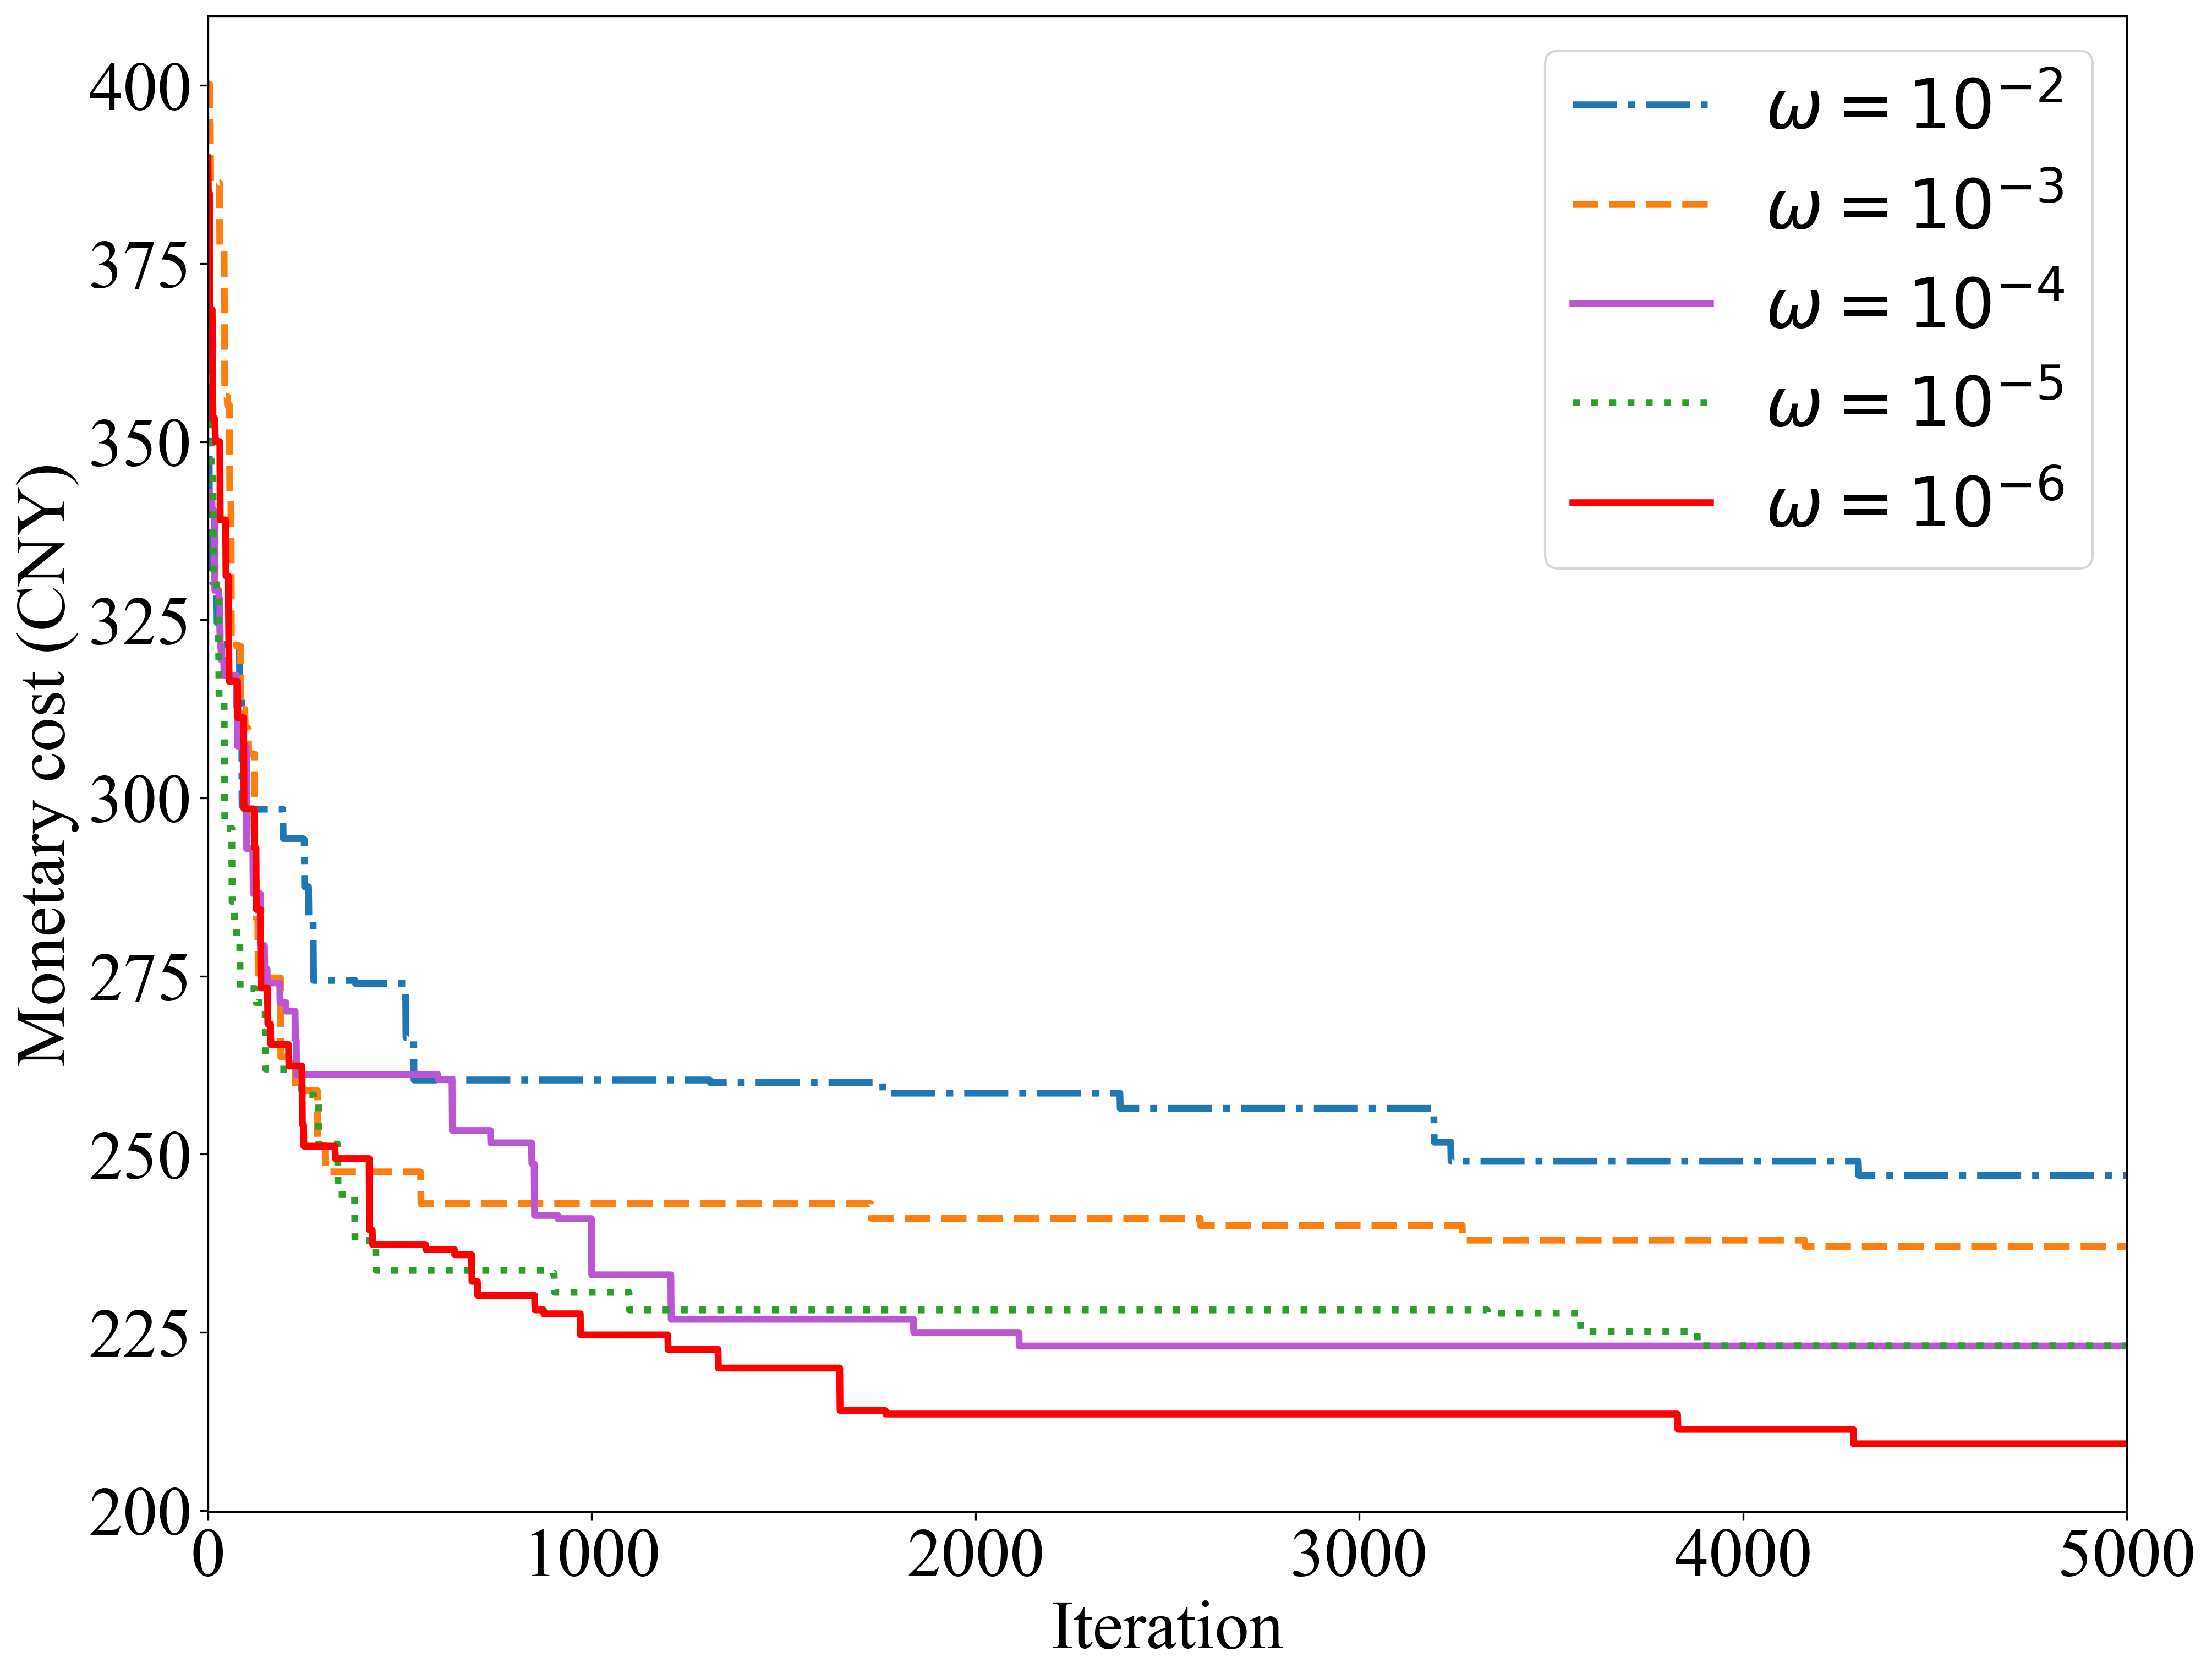

In [20]:
x_data = range(len(result_gibbs_ondemand1))
plt.rc('font',family='Times New Roman')

figure(num=None, figsize=(15, 12), dpi=300, facecolor='w', edgecolor='k')
plt.margins(x=0)
plt.xlim(0,5000)

plt.plot(x_data, result_gibbs_ondemand1, '-.', linewidth = 3.0, label="$\omega = 10^{-2}$")
plt.plot(x_data, result_gibbs_ondemand2, '--', linewidth = 3.0, label="$\omega = 10^{-3}$")
plt.plot(x_data, result_gibbs_ondemand3, '-', color = 'mediumorchid', linewidth = 3.0, label="$\omega = 10^{-4}$")
plt.plot(x_data, result_gibbs_ondemand4, ':', linewidth = 3.0, label="$\omega = 10^{-5}$")
plt.plot(x_data, result_gibbs_ondemand5, '-', color = 'red',linewidth = 3.0, label="$\omega = 10^{-6}$")
ax = plt.subplot(111)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Monetary cost (CNY)",fontsize=30)
plt.xlabel("Iteration",fontsize=30)
plt.legend(fontsize=30)

plt.savefig("omega.png")
plt.show()
